# __Appendix A__

## Assignment 8: Build & Evaluate Time Series Models
Dawud Ujamaa  
School of Technology & Engineering, National University  
TIM-8555: Predictive Analysis  
Dr. Larry Fulton  
January 12, 2025

In [1]:
import time
import gc
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

import numpy as np, pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels 
from statsmodels.tsa.exponential_smoothing.ets import ETSModel as ets 
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.graphics.tsaplots import plot_pacf 
from statsmodels.tsa.arima.model import ARIMA 
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from ISLP.models import (summarize , poly , ModelSpec as MS)
from l0bnb import fit_path

import sklearn.model_selection as skm
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold 
from sklearn.model_selection import cross_val_score 
import sklearn.linear_model as skl
from sklearn.svm import LinearSVC as svc
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import (accuracy_score , log_loss)
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report as cr 
from sklearn.metrics import log_loss
from sklearn.tree import (DecisionTreeClassifier as DTC ,
DecisionTreeRegressor as DTR , plot_tree , export_text)

from sklearnex import patch_sklearn 
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### __1. Compete in the Store Sales Time Series Forecasting competition on Kaggle.com__
https://www.kaggle.com/competitions/store-sales-time-series-forecasting/overview

Build one ETS and one ARIMA  model.  Submit models for evaluation.  Investigate assumptions.  Interpret findings.

#### __EDA and Preprocessing__

In [2]:
# import training data
SalesTrain = pd.read_csv(r'./store-sales-time-series-forecasting/train.csv', parse_dates=['date'],index_col=0)
SalesTrain

date  store_nbr                      family     sales  \
id                                                                    
0       2013-01-01          1                  AUTOMOTIVE     0.000   
1       2013-01-01          1                   BABY CARE     0.000   
2       2013-01-01          1                      BEAUTY     0.000   
3       2013-01-01          1                   BEVERAGES     0.000   
4       2013-01-01          1                       BOOKS     0.000   
...            ...        ...                         ...       ...   
3000883 2017-08-15          9                     POULTRY   438.133   
3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion  
id                    
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  
...              ...  
3000883            0  
3000884            1  
3000885          148  
3000886            8  
3000887            0  

[3000888 rows x 5 columns]

In [3]:
# check for missing values
missing_values = SalesTrain.isnull().sum()
print(missing_values)

date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [4]:
SalesTrain.describe()

store_nbr         sales   onpromotion
count  3.000888e+06  3.000888e+06  3.000888e+06
mean   2.750000e+01  3.577757e+02  2.602770e+00
std    1.558579e+01  1.101998e+03  1.221888e+01
min    1.000000e+00  0.000000e+00  0.000000e+00
25%    1.400000e+01  0.000000e+00  0.000000e+00
50%    2.750000e+01  1.100000e+01  0.000000e+00
75%    4.100000e+01  1.958473e+02  0.000000e+00
max    5.400000e+01  1.247170e+05  7.410000e+02

CPU times: total: 531 ms
Wall time: 880 ms


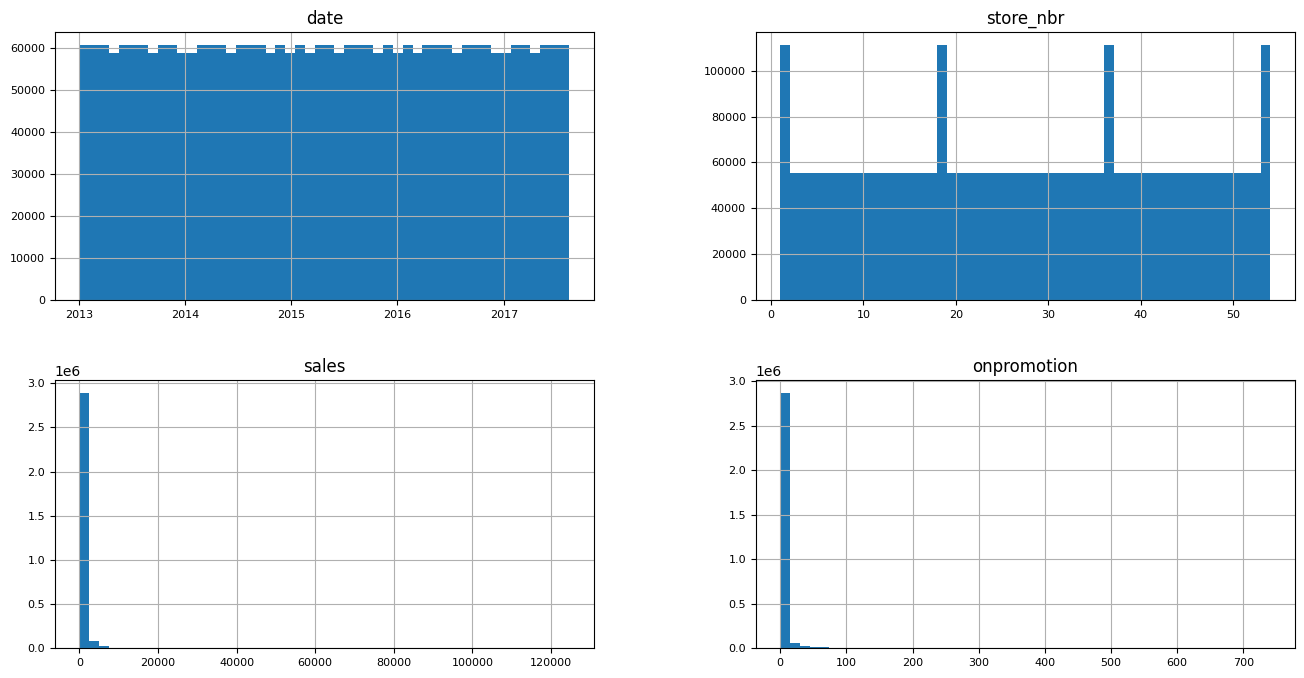

In [5]:
%%time
SalesTrain.hist(figsize=(16, 8), bins=50, xlabelsize=8, ylabelsize=8);

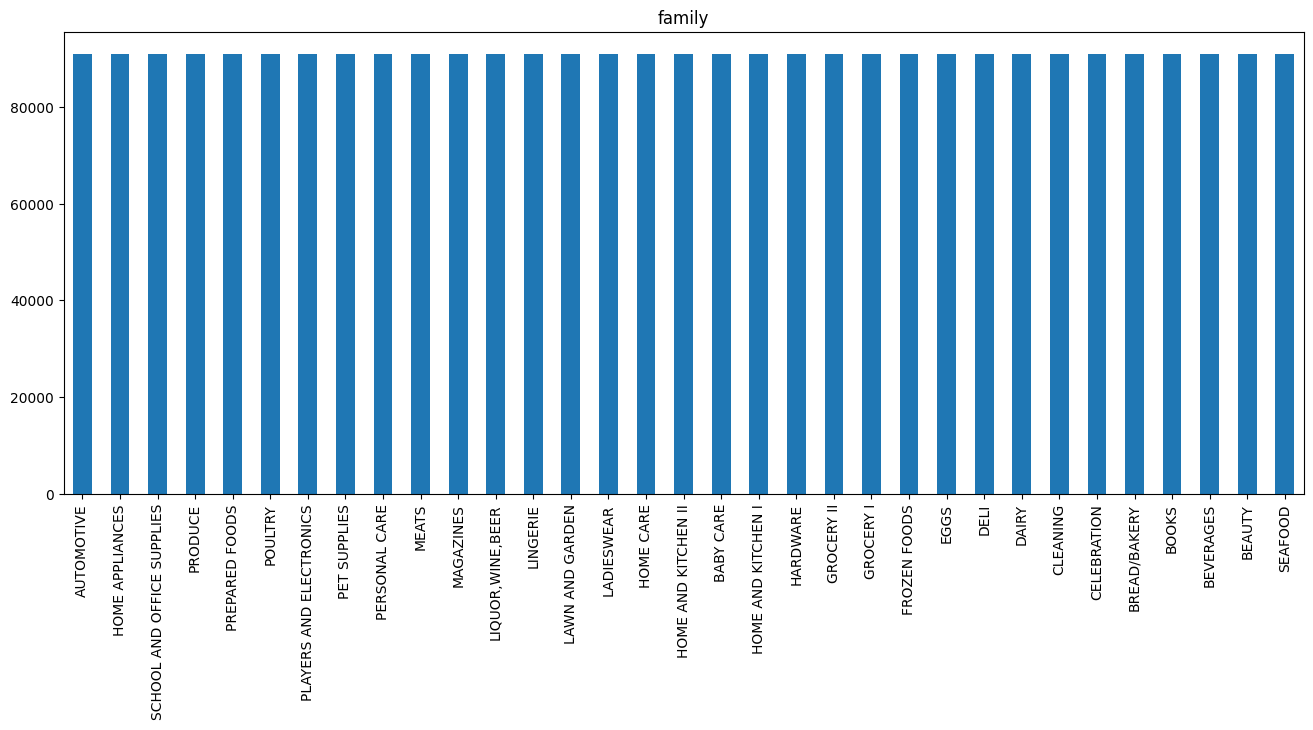

In [6]:
fig1 = plt.figure(figsize=(16, 6))
ax = fig1.add_subplot()
SalesTrain['family'].value_counts().plot(kind='bar')
ax.set_title('family');

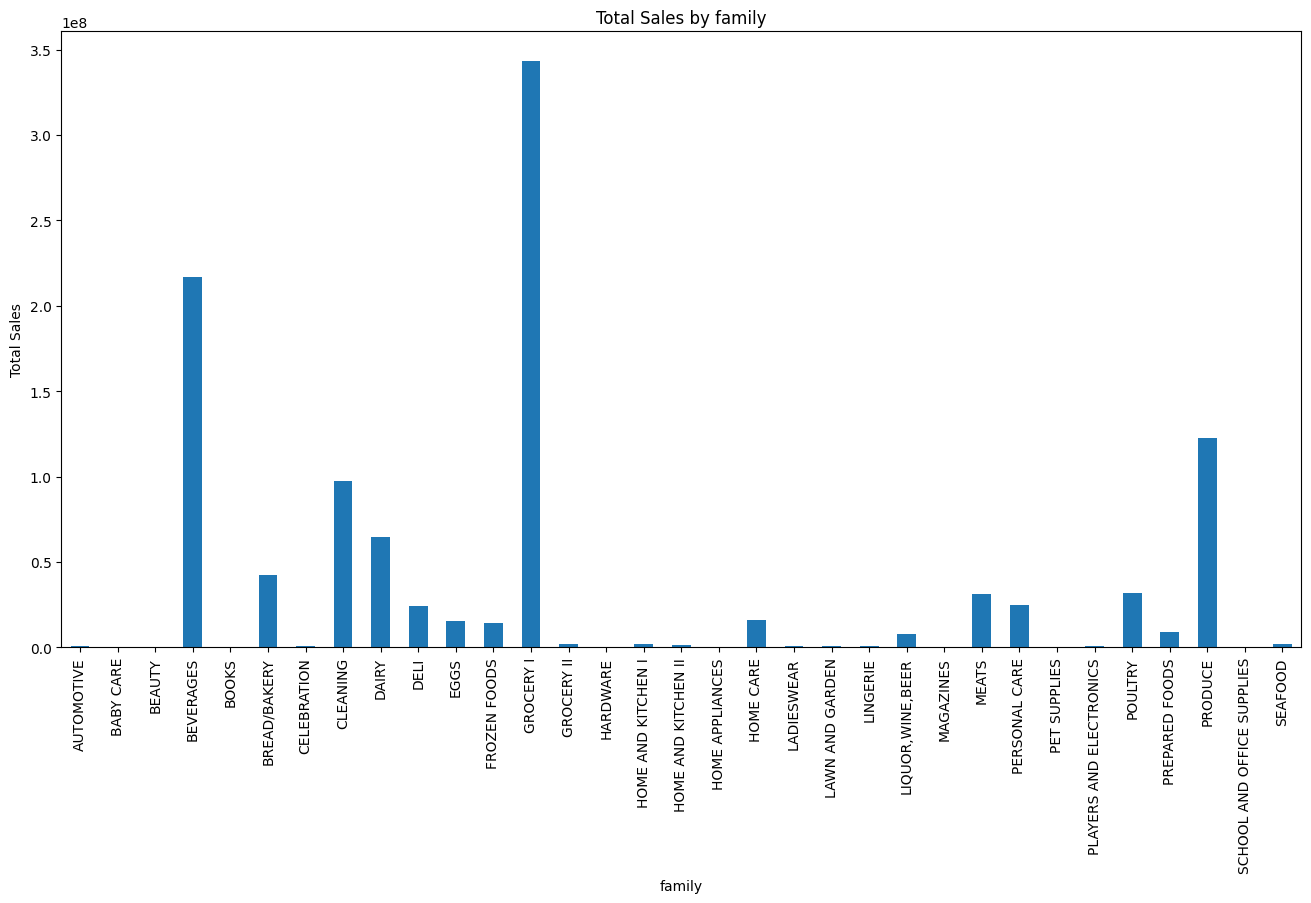

In [7]:
familySales = SalesTrain.groupby('family')['sales'].sum()
familySales.plot(kind='bar',figsize=(16, 8))
plt.title("Total Sales by family")
plt.ylabel("Total Sales") 
plt.xlabel("family");

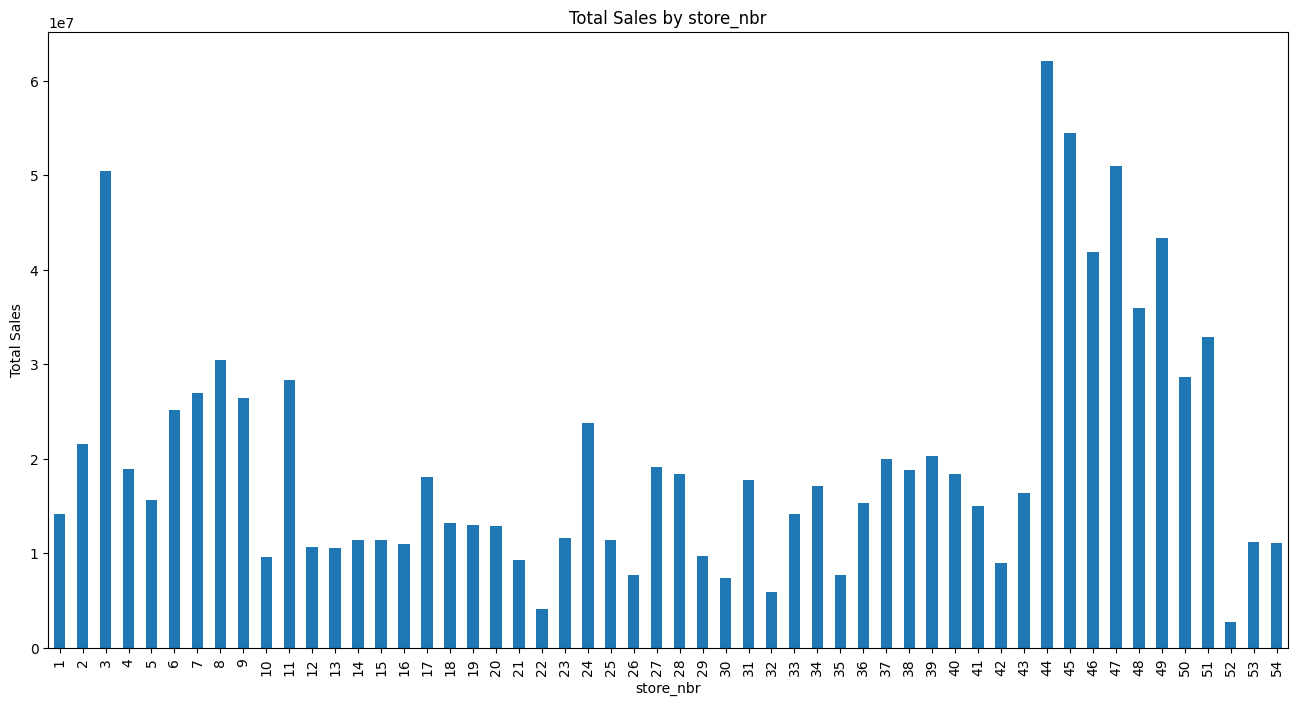

In [8]:
store_nbrSales = SalesTrain.groupby('store_nbr')['sales'].sum()
store_nbrSales.plot(kind='bar',figsize=(16, 8))
plt.title("Total Sales by store_nbr")
plt.ylabel("Total Sales") 
plt.xlabel("store_nbr");

In [9]:
%%time
SalesPerDay = pd.DataFrame(SalesTrain.groupby('date')['sales'].sum())

DateRange = pd.DataFrame(pd.date_range("2013-01-01", "2017-08-15", freq="D"))
DateRange.columns = ['date']

SalesOverDateRange = pd.merge(DateRange, SalesPerDay, on='date', how='left')
SalesOverDateRange.fillna(0.0, inplace=True) # fill the dates with missing value for sales with 0.0
SalesOverDateRange

CPU times: total: 62.5 ms
Wall time: 87.2 ms


date          sales
0    2013-01-01    2511.618999
1    2013-01-02  496092.417944
2    2013-01-03  361461.231124
3    2013-01-04  354459.677093
4    2013-01-05  477350.121229
...         ...            ...
1683 2017-08-11  826373.722022
1684 2017-08-12  792630.535079
1685 2017-08-13  865639.677471
1686 2017-08-14  760922.406081
1687 2017-08-15  762661.935939

[1688 rows x 2 columns]

CPU times: total: 15.6 ms
Wall time: 52.4 ms


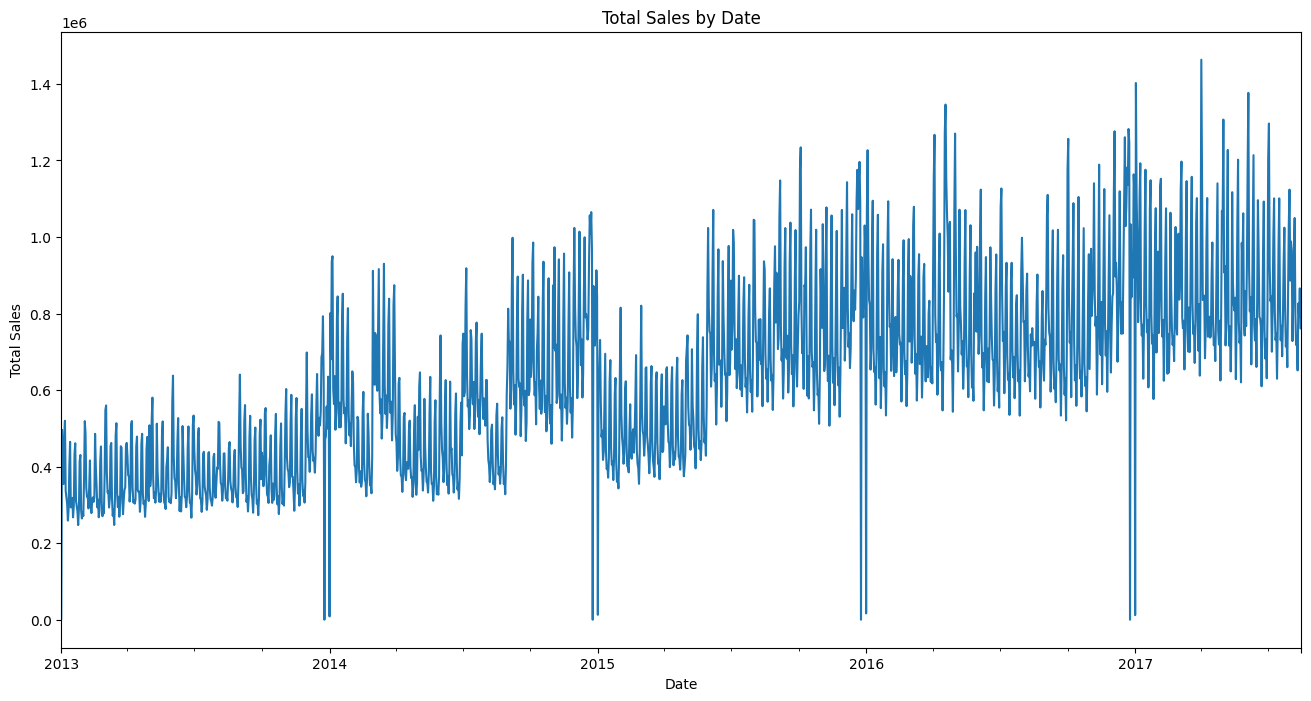

In [10]:
%%time
index = pd.date_range("2013-01-01", "2017-08-15", freq="D")
dailySales = pd.Series(SalesOverDateRange['sales'].tolist(), index=index) 
dailySales.plot(figsize=(16, 8))
plt.title("Total Sales by Date")
plt.ylabel("Total Sales") 
plt.xlabel("Date");

In [11]:
# what dates have 0 cumulative sales
ZeroSales = SalesOverDateRange[SalesOverDateRange['sales']==0.0]
ZeroSales

date  sales
358  2013-12-25    0.0
723  2014-12-25    0.0
1088 2015-12-25    0.0
1454 2016-12-25    0.0

#### __Feature Engineering__
1. Make `Group` variable that combines `store_nbr` and `family`
2. Make data for time series models

In [12]:
# how many unique stores are there
uniquestore_nbr = SalesTrain['store_nbr'].nunique()
print(uniquestore_nbr)

54


In [13]:
# how many unique family are there
uniquefamily = SalesTrain['family'].nunique()
print(uniquefamily)

33


There are 54 store_nbr, 33 family, and 1688 days from 01/01/2013 to 08/15/2017. Also, Christmas day (12/25) is missing for each year from 2013 to 2017, so there are only 1684 unique days in the data set.  So $54 * 33 * 1684 = 3000888$ total records
`Group` variable should have $54 * 33 = 1782$ unique values.

In [14]:
SalesTrain['STRstore_nbr'] = SalesTrain['store_nbr'].astype(str) 
SalesTrain['group']=SalesTrain['STRstore_nbr'].str.cat(SalesTrain['family'], sep = "-", na_rep = " ")
SalesTrain

date  store_nbr                      family     sales  \
id                                                                    
0       2013-01-01          1                  AUTOMOTIVE     0.000   
1       2013-01-01          1                   BABY CARE     0.000   
2       2013-01-01          1                      BEAUTY     0.000   
3       2013-01-01          1                   BEVERAGES     0.000   
4       2013-01-01          1                       BOOKS     0.000   
...            ...        ...                         ...       ...   
3000883 2017-08-15          9                     POULTRY   438.133   
3000884 2017-08-15          9              PREPARED FOODS   154.553   
3000885 2017-08-15          9                     PRODUCE  2419.729   
3000886 2017-08-15          9  SCHOOL AND OFFICE SUPPLIES   121.000   
3000887 2017-08-15          9                     SEAFOOD    16.000   

         onpromotion STRstore_nbr                         group  
id                                                               
0                  0            1                  1-AUTOMOTIVE  
1                  0            1                   1-BABY CARE  
2                  0            1                      1-BEAUTY  
3                  0            1                   1-BEVERAGES  
4                  0            1                       1-BOOKS  
...              ...          ...                           ...  
3000883            0            9                     9-POULTRY  
3000884            1            9              9-PREPARED FOODS  
3000885          148            9                     9-PRODUCE  
3000886            8            9  9-SCHOOL AND OFFICE SUPPLIES  
3000887            0            9                     9-SEAFOOD  

[3000888 rows x 7 columns]

In [15]:
uniqueGroup = SalesTrain['group'].nunique()
print(uniqueGroup)

1782


In [16]:
train = SalesTrain[['date','sales','group']]
train.set_index('date', inplace=True)
train.index = pd.DatetimeIndex(train.index).to_period('D')
train

sales                         group
date                                              
2013-01-01     0.000                  1-AUTOMOTIVE
2013-01-01     0.000                   1-BABY CARE
2013-01-01     0.000                      1-BEAUTY
2013-01-01     0.000                   1-BEVERAGES
2013-01-01     0.000                       1-BOOKS
...              ...                           ...
2017-08-15   438.133                     9-POULTRY
2017-08-15   154.553              9-PREPARED FOODS
2017-08-15  2419.729                     9-PRODUCE
2017-08-15   121.000  9-SCHOOL AND OFFICE SUPPLIES
2017-08-15    16.000                     9-SEAFOOD

[3000888 rows x 2 columns]

#### __ETS Time Series Modeling__
First try ETS using additive methods on cumulative sales data

In [17]:
#training and test sets on cumulative data
mytrain=dailySales[0:1350] 
mytest=dailySales[1351:1689] 
mytrain

2013-01-01    2.511619e+03
2013-01-02    4.960924e+05
2013-01-03    3.614612e+05
2013-01-04    3.544597e+05
2013-01-05    4.773501e+05
                  ...     
2016-09-07    7.385439e+05
2016-09-08    5.958493e+05
2016-09-09    6.589690e+05
2016-09-10    9.159386e+05
2016-09-11    1.017369e+06
Freq: D, Length: 1350, dtype: float64

In [18]:
mytest

2016-09-13    603427.946974
2016-09-14    624262.071976
2016-09-15    568324.812986
2016-09-16    691912.601466
2016-09-17    899219.297508
                  ...      
2017-08-11    826373.722022
2017-08-12    792630.535079
2017-08-13    865639.677471
2017-08-14    760922.406081
2017-08-15    762661.935939
Freq: D, Length: 337, dtype: float64

CPU times: total: 141 ms
Wall time: 208 ms


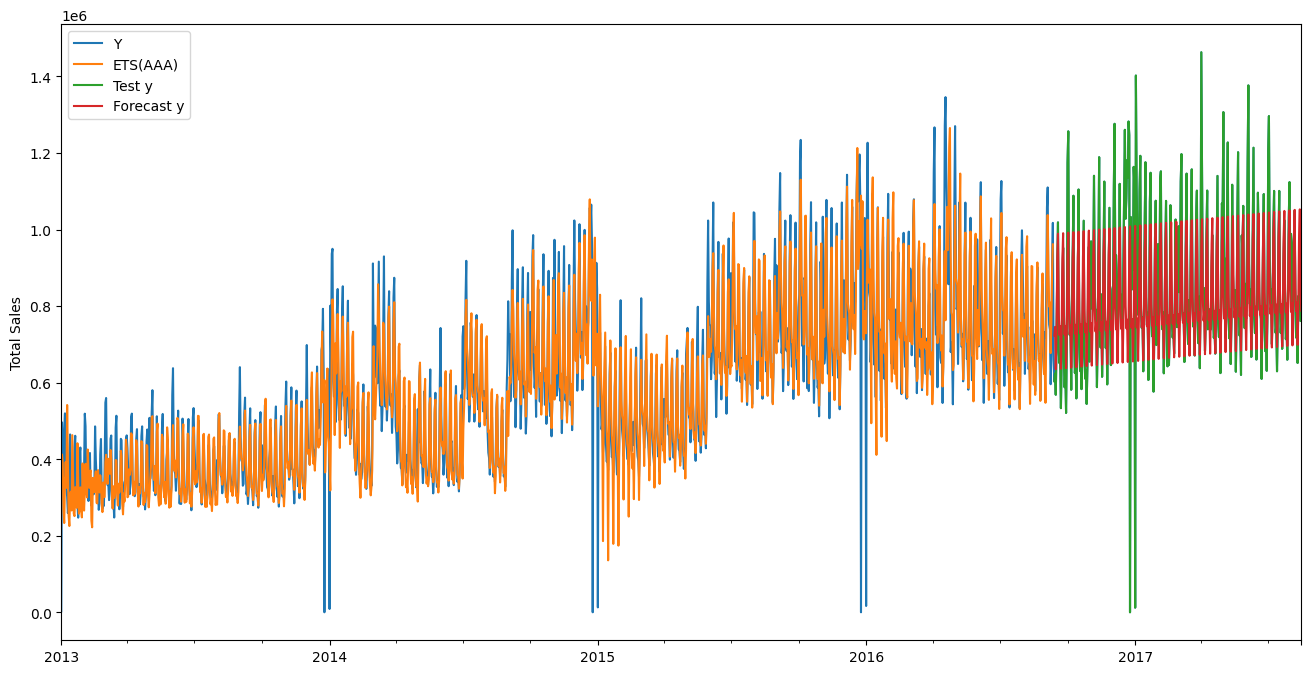

In [19]:
%%time
# fit ets using additive methods - ON CUMULATIVE DATA
addETSmodel = ets(mytrain, error="add", trend="add", seasonal="add", damped_trend=False, seasonal_periods=7,) 
fit = addETSmodel.fit() 
pred = fit.get_prediction(start="2016-09-13", end="2017-08-15") 
df = pred.summary_frame(alpha=0.05) 
df['test']=mytest 
dailySales.plot(figsize=(16, 8), label="Y") 
plt.ylabel("Total Sales") 
fit.fittedvalues.plot(label="ETS(AAA)") 
df['test'].plot(label='Test y') 
df['mean'].plot(label='Forecast y') 
plt.legend();

__Next, try ETS using additive methods on the store and family groups__

Running ets() produced a waring "ConvergenceWarning: Maximum Likelihood optimization failed to converge" which may mean the model is not a good fit for the data. This warning was turned off to suprress it from being printed in each iteration of the loop

In [20]:
%%time
# Fit ETS model by group
results = {}
for group, group_data in train.groupby('group'):
    ETSmodel = ets(group_data['sales'], error='add', trend='add', seasonal='add', damped_trend=False, seasonal_periods=7)
    results[group] = ETSmodel.fit()

CPU times: total: 1min 39s
Wall time: 5min 36s


In [21]:
%%time
# get fitted values for each group

# Create an empty DataFrame
ETSfitted_wide = pd.DataFrame()

for group, result in results.items():
    ETSfitted_wide = ETSfitted_wide.append(pd.DataFrame({'group': [group], **result.fittedvalues}), ignore_index=True)

ETSfitted = pd.melt(ETSfitted_wide, id_vars=['group'], value_vars=ETSfitted_wide.columns, var_name='date', value_name='sales')
ETSfitted 

CPU times: total: 3min 21s
Wall time: 3min 23s


group        date        sales
0                        1-AUTOMOTIVE  2013-01-01     1.322656
1                         1-BABY CARE  2013-01-01     0.000000
2                            1-BEAUTY  2013-01-01     1.532460
3                         1-BEVERAGES  2013-01-01   904.373634
4                             1-BOOKS  2013-01-01    -0.000969
...                               ...         ...          ...
3000883                     9-POULTRY  2017-08-15   370.232461
3000884              9-PREPARED FOODS  2017-08-15    94.073580
3000885                     9-PRODUCE  2017-08-15  2077.744594
3000886  9-SCHOOL AND OFFICE SUPPLIES  2017-08-15   175.202908
3000887                     9-SEAFOOD  2017-08-15    15.322599

[3000888 rows x 3 columns]

In [22]:
%%time
# get forecasted values for each group for the date range in test start="2017-08-16", end="2017-08-31"

ForecastVals = {} # Dictionary that will contain the forecasted values from ETSmodel on the date range in Test
for group, result in results.items():
    ForecastVals[group]=result.get_prediction(start="2017-08-16", end="2017-08-31")

ForecastWide = pd.DataFrame() # DataFrame that will contain the forecasted values from ETSmodel on the date range in Test
ForecastSummaryFrame = pd.DataFrame() # DataFrame for the summary_frame in the loop

for group, pred in ForecastVals.items():
    ForecastSummaryFrame = pred.summary_frame(alpha=0.05)
    ForecastWide = ForecastWide.append(pd.DataFrame({'group': [group], **ForecastSummaryFrame['mean']}), ignore_index=True)

# transpose from wide to long
ETSforecast = pd.melt(ForecastWide, id_vars=['group'], value_vars=ForecastWide.columns, var_name='date', value_name='sales')
ETSforecast

CPU times: total: 10.5 s
Wall time: 10.6 s


group        date        sales
0                      1-AUTOMOTIVE  2017-08-16     2.764629
1                       1-BABY CARE  2017-08-16     0.000000
2                          1-BEAUTY  2017-08-16     2.483723
3                       1-BEVERAGES  2017-08-16   751.058785
4                           1-BOOKS  2017-08-16     0.062814
...                             ...         ...          ...
28507                     9-POULTRY  2017-08-31   390.736857
28508              9-PREPARED FOODS  2017-08-31   109.804219
28509                     9-PRODUCE  2017-08-31  1495.496230
28510  9-SCHOOL AND OFFICE SUPPLIES  2017-08-31   150.662517
28511                     9-SEAFOOD  2017-08-31    16.518327

[28512 rows x 3 columns]

##### __Evaluate ETS Time Series Model__

In [23]:
# separate the group data into an 80%-20% train and test set
GroupTest = train[train.index >='2016-09-13']
GroupTrain = train[train.index <'2016-09-13']

print(GroupTrain.shape)
print(GroupTest.shape)

(2402136, 2)
(598752, 2)


In [24]:
GroupTrain.head(3)

sales         group
date                           
2013-01-01    0.0  1-AUTOMOTIVE
2013-01-01    0.0   1-BABY CARE
2013-01-01    0.0      1-BEAUTY

In [25]:
%%time
ValResults = {} # Dictionary that will ETSmodel.fit() on the data set GroupTrain
for group, group_data in GroupTrain.groupby('group'):
    ETSmodel = ets(group_data['sales'], error='add', trend='add', seasonal='add', damped_trend=False, seasonal_periods=7)
    ValResults[group] = ETSmodel.fit()

CPU times: total: 1min 10s
Wall time: 4min 56s


In [26]:
%%time
# get fitted values for each group in the Dictionary ValResults

GroupTrainFitted_wide = pd.DataFrame() # DataFrame that will contain ETSmodel fitted values on GroupTrain 

for group, result in ValResults.items():
    GroupTrainFitted_wide = GroupTrainFitted_wide.append(pd.DataFrame({'group': [group], **result.fittedvalues}), ignore_index=True)

# transpose from wide to long
GroupTrainFitted = pd.melt(GroupTrainFitted_wide, id_vars=['group'], value_vars=GroupTrainFitted_wide.columns, var_name='date', value_name='sales')
GroupTrainFitted

CPU times: total: 2min 37s
Wall time: 2min 38s


group        date        sales
0                        1-AUTOMOTIVE  2013-01-01     1.311794
1                         1-BABY CARE  2013-01-01     0.000000
2                            1-BEAUTY  2013-01-01     1.509269
3                         1-BEVERAGES  2013-01-01   904.373400
4                             1-BOOKS  2013-01-01     0.000000
...                               ...         ...          ...
2402131                     9-POULTRY  2016-09-12   430.632622
2402132              9-PREPARED FOODS  2016-09-12   107.128565
2402133                     9-PRODUCE  2016-09-12  1561.825357
2402134  9-SCHOOL AND OFFICE SUPPLIES  2016-09-12   154.780712
2402135                     9-SEAFOOD  2016-09-12    20.147562

[2402136 rows x 3 columns]

In [27]:
%%time
# get the forecasted values from ETSmodel on the date range in GroupTest

Valpreds = {} # Dictionary that will contain the predictions from ETSmodel on the date range in GroupTest
for group, result in ValResults.items():
    Valpreds[group]=result.get_prediction(start="2016-09-13", end="2017-08-15")

GroupPredsWide = pd.DataFrame() # DataFrame that will contain the forecasted values from ETSmodel on the date range in GroupTest
GroupPredSummaryFrame = pd.DataFrame() # DataFrame for the summary_frame in the loop

for group, pred in Valpreds.items():
    GroupPredSummaryFrame = pred.summary_frame(alpha=0.05)
    GroupPredsWide = GroupPredsWide.append(pd.DataFrame({'group': [group], **GroupPredSummaryFrame['mean']}), ignore_index=True)

# transpose from wide to long
GroupPreds = pd.melt(GroupPredsWide, id_vars=['group'], value_vars=GroupPredsWide.columns, var_name='date', value_name='sales')

# drop the rows corresponding to Christmas day '2016-12-25' since that date is not in the GroupTest DataFrame
GroupPreds = GroupPreds[GroupPreds['date'] != '2016-12-25']
GroupPreds

CPU times: total: 1min 8s
Wall time: 1min 9s


group        date        sales
0                       1-AUTOMOTIVE  2016-09-13     4.743385
1                        1-BABY CARE  2016-09-13     0.000000
2                           1-BEAUTY  2016-09-13     4.166391
3                        1-BEVERAGES  2016-09-13  2307.884938
4                            1-BOOKS  2016-09-13     0.000000
...                              ...         ...          ...
600529                     9-POULTRY  2017-08-15   471.035218
600530              9-PREPARED FOODS  2017-08-15   120.107410
600531                     9-PRODUCE  2017-08-15  1296.931955
600532  9-SCHOOL AND OFFICE SUPPLIES  2017-08-15   150.070745
600533                     9-SEAFOOD  2017-08-15    16.468221

[598752 rows x 3 columns]

In [28]:
%%time
# COMBINE ACTUAL AND FITTED TRAINING DATAFRAMES TO COMPARE VALUES

# Prepare actual training sales
GroupTrain2 = GroupTrain.copy()
GroupTrain2['date'] = GroupTrain2.index
GroupTrain2['date'] = GroupTrain2['date'].dt.to_timestamp()
GroupTrain2.reset_index(drop=True, inplace=True)

# Prepare fitted sales
GroupTrainFitted2 = GroupTrainFitted.copy()
GroupTrainFitted2['date'] = GroupTrainFitted2['date'].dt.to_timestamp()
GroupTrainFitted2 = GroupTrainFitted2.rename(columns={'sales': 'sales_pred','group': 'group_pred', 'date':'date_pred'})

# sort the dataframes
GroupTrain2.sort_values(by=['date','group'], ascending=[True, True], inplace=True)
GroupTrainFitted2.sort_values(by=['date_pred','group_pred'], ascending=[True, True], inplace=True)

# Horizontally concatenate the dataframes
CompareTrain = pd.concat([GroupTrain2, GroupTrainFitted2], axis=1)
CompareTrain

CPU times: total: 2.23 s
Wall time: 2.29 s


sales                         group       date  \
0           0.000                  1-AUTOMOTIVE 2013-01-01   
1           0.000                   1-BABY CARE 2013-01-01   
2           0.000                      1-BEAUTY 2013-01-01   
3           0.000                   1-BEVERAGES 2013-01-01   
4           0.000                       1-BOOKS 2013-01-01   
...           ...                           ...        ...   
2402131   381.827                     9-POULTRY 2016-09-12   
2402132    94.039              9-PREPARED FOODS 2016-09-12   
2402133  1301.606                     9-PRODUCE 2016-09-12   
2402134    47.000  9-SCHOOL AND OFFICE SUPPLIES 2016-09-12   
2402135    12.490                     9-SEAFOOD 2016-09-12   

                           group_pred  date_pred   sales_pred  
0                        1-AUTOMOTIVE 2013-01-01     1.311794  
1                         1-BABY CARE 2013-01-01     0.000000  
2                            1-BEAUTY 2013-01-01     1.509269  
3                         1-BEVERAGES 2013-01-01   904.373400  
4                             1-BOOKS 2013-01-01     0.000000  
...                               ...        ...          ...  
2402131                     9-POULTRY 2016-09-12   430.632622  
2402132              9-PREPARED FOODS 2016-09-12   107.128565  
2402133                     9-PRODUCE 2016-09-12  1561.825357  
2402134  9-SCHOOL AND OFFICE SUPPLIES 2016-09-12   154.780712  
2402135                     9-SEAFOOD 2016-09-12    20.147562  

[2402136 rows x 6 columns]

In [29]:
%%time
# COMBINE ACTUAL AND FITTED TEST DATAFRAMES TO COMPARE VALUES

# Prepare actual test sales
GroupTest2 = GroupTest.copy()
GroupTest2['date'] = GroupTest2.index
GroupTest2['date'] = GroupTest2['date'].dt.to_timestamp()
GroupTest2.reset_index(drop=True, inplace=True)

# Prepare forecasted sales
GroupPreds2 = GroupPreds.copy()
GroupPreds2['date'] = GroupPreds2['date'].dt.to_timestamp()
GroupPreds2 = GroupPreds2.rename(columns={'sales': 'sales_pred','group': 'group_pred', 'date':'date_pred'})
GroupPreds2.reset_index(drop=True, inplace=True)

# sort the dataframes
GroupTest2.sort_values(by=['date','group'], ascending=[True, True], inplace=True)
GroupPreds2.sort_values(by=['date_pred','group_pred'], ascending=[True, True], inplace=True)

# Horizontally concatenate the dataframes
CompareTest = pd.concat([GroupTest2, GroupPreds2], axis=1)
CompareTest

CPU times: total: 578 ms
Wall time: 621 ms


sales                         group       date  \
0          4.000                  1-AUTOMOTIVE 2016-09-13   
1          0.000                   1-BABY CARE 2016-09-13   
2          3.000                      1-BEAUTY 2016-09-13   
3       1942.000                   1-BEVERAGES 2016-09-13   
4          0.000                       1-BOOKS 2016-09-13   
...          ...                           ...        ...   
598747   438.133                     9-POULTRY 2017-08-15   
598748   154.553              9-PREPARED FOODS 2017-08-15   
598749  2419.729                     9-PRODUCE 2017-08-15   
598750   121.000  9-SCHOOL AND OFFICE SUPPLIES 2017-08-15   
598751    16.000                     9-SEAFOOD 2017-08-15   

                          group_pred  date_pred   sales_pred  
0                       1-AUTOMOTIVE 2016-09-13     4.743385  
1                        1-BABY CARE 2016-09-13     0.000000  
2                           1-BEAUTY 2016-09-13     4.166391  
3                        1-BEVERAGES 2016-09-13  2307.884938  
4                            1-BOOKS 2016-09-13     0.000000  
...                              ...        ...          ...  
598747                     9-POULTRY 2017-08-15   471.035218  
598748              9-PREPARED FOODS 2017-08-15   120.107410  
598749                     9-PRODUCE 2017-08-15  1296.931955  
598750  9-SCHOOL AND OFFICE SUPPLIES 2017-08-15   150.070745  
598751                     9-SEAFOOD 2017-08-15    16.468221  

[598752 rows x 6 columns]

In [30]:
# Define function for evaluation metrics
def rmsle(mytest, ypred):
    return np.sqrt(mean_squared_log_error(mytest, ypred))

def myf(mytest,ypred): 
    error=sum(mytest-ypred) 
    MSE=error**2 
    RMSE=MSE**.5 
    MAE=np.mean(np.abs(error)) 
    MAPE=np.mean((np.abs(mytest-ypred)/mytest)) 
    ME=np.mean(error) 
    MPE=np.mean((mytest-ypred)/mytest) 
    RMSLE=np.round(rmsle(mytest.abs(),ypred.abs()),3)
    answer=[MSE, RMSE, MAE, MAPE, ME, MPE, RMSLE] 
    #answer=[MSE, RMSE, MAE, MAPE, ME, MPE]
    names=["MSE", "RMSE", "MAE", "MAPE", "ME", "MPE", "RMSLE"] 
    #names=["MSE", "RMSE", "MAE", "MAPE", "ME", "MPE"] 
    myanswer=dict(zip(names,answer)) 
    return(myanswer) 

m1 = myf(CompareTrain['sales'], CompareTrain['sales_pred']) 
m2 = myf(CompareTest['sales'], CompareTest['sales_pred']) 
newdf=pd.DataFrame([m1,m2]) 
newdf

MSE          RMSE           MAE  MAPE            ME  MPE  RMSLE
0  1.663432e+13  4.078519e+06  4.078519e+06   inf  4.078519e+06  NaN  0.649
1  7.949239e+14  2.819440e+07  2.819440e+07   inf  2.819440e+07  NaN  0.911

CPU times: total: 219 ms
Wall time: 254 ms


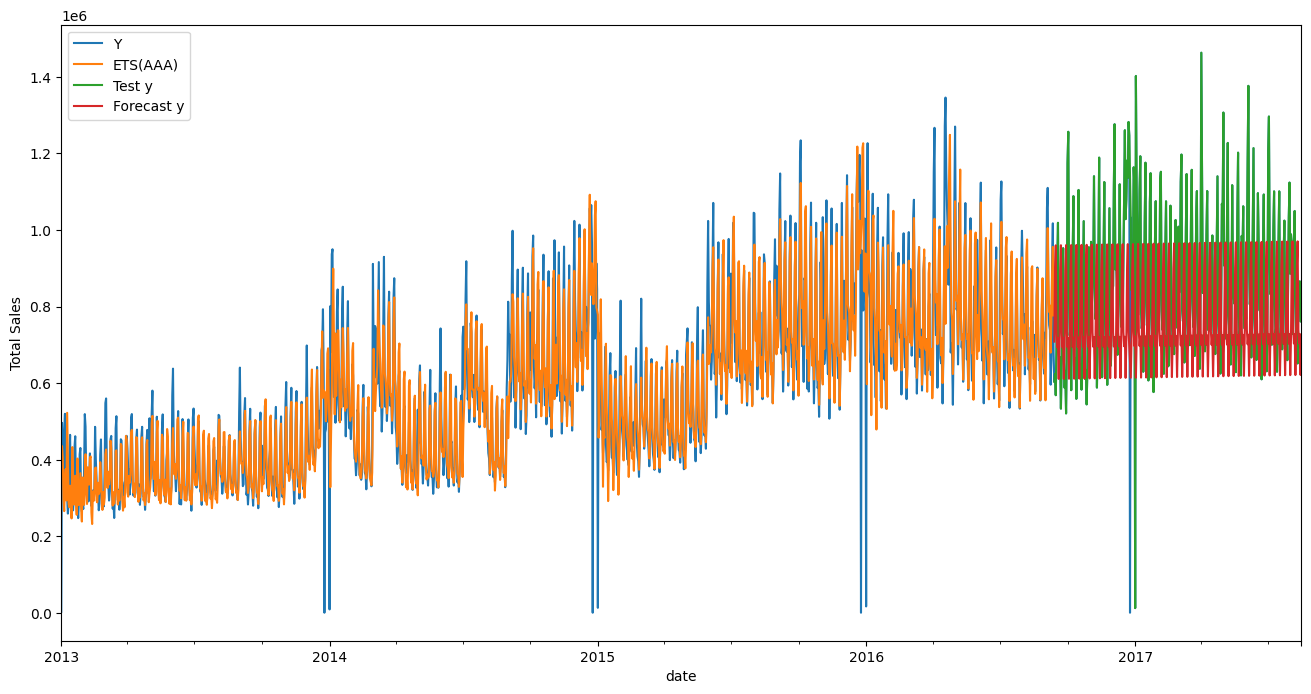

In [31]:
%%time
# PLOT THE ACTUAL, FITTED, AND FORECASTED CUMULATIVE DATA

FittedDailySales_df = pd.DataFrame(CompareTrain.groupby('date')['sales_pred'].sum())
FittedDailySales = pd.Series(FittedDailySales_df['sales_pred'].tolist(), index=FittedDailySales_df.index)

TESTDailySales_df = pd.DataFrame(CompareTest.groupby('date')['sales'].sum())
TESTDailySales = pd.Series(TESTDailySales_df['sales'].tolist(), index=TESTDailySales_df.index)

FORECASTDailySales_df = pd.DataFrame(CompareTest.groupby('date')['sales_pred'].sum())
FORECASTDailySales = pd.Series(FORECASTDailySales_df['sales_pred'].tolist(), index=FORECASTDailySales_df.index)

dailySales.plot(figsize=(16, 8), label="Y") 
plt.ylabel("Total Sales") 
plt.xlabel("Date") 
FittedDailySales.plot(label="ETS(AAA)") 
TESTDailySales.plot(label='Test y') 
FORECASTDailySales.plot(label='Forecast y') 
plt.legend();

##### __Assess residuals to investigate assumptions__

CPU times: total: 125 ms
Wall time: 145 ms


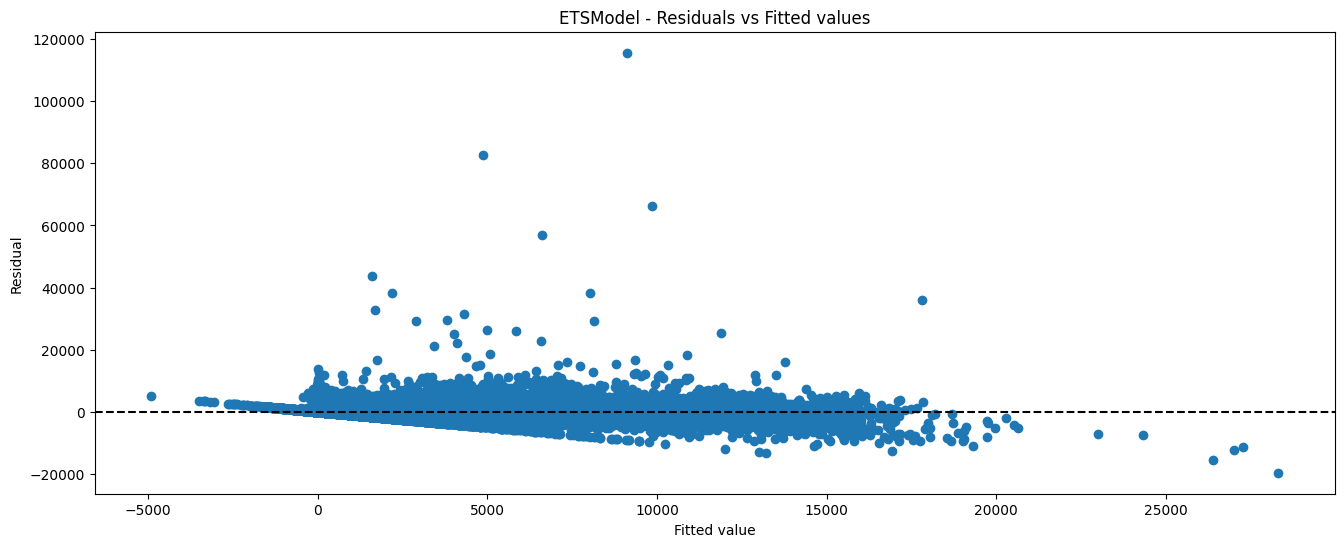

In [32]:
%%time
# scatter plot of residuals vs fitted values to assess homoscedasticity
ETSresiduals = CompareTrain['sales'] - CompareTrain['sales_pred']

ax = plt.subplots(figsize=(16,6))[1]
ax.scatter(CompareTrain['sales_pred'] , ETSresiduals)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.set_title('ETSModel - Residuals vs Fitted values')
ax.axhline(0, c='k', ls='--');

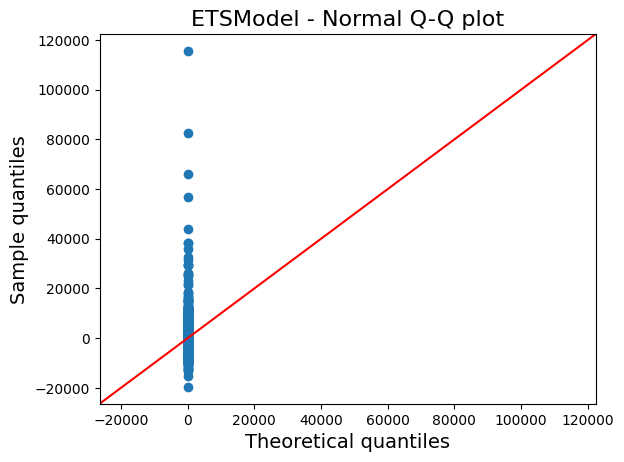

In [33]:
# Normal Q-Q Plot of Residuals to assess normality of residuals
resid = np.ravel(ETSresiduals)
p = sm.qqplot(resid, line='45')
plt.title('ETSModel - Normal Q-Q plot', fontsize=16);
plt.xlabel('Theoretical quantiles', fontsize=14);
plt.ylabel('Sample quantiles', fontsize=14);

#### __Use ETS Model to Generate predictions on the dates in the test data__

In [34]:
# import test data
SalesTest = pd.read_csv(r'./store-sales-time-series-forecasting/test.csv', parse_dates=['date'])
SalesTest

id       date  store_nbr                      family  onpromotion
0      3000888 2017-08-16          1                  AUTOMOTIVE            0
1      3000889 2017-08-16          1                   BABY CARE            0
2      3000890 2017-08-16          1                      BEAUTY            2
3      3000891 2017-08-16          1                   BEVERAGES           20
4      3000892 2017-08-16          1                       BOOKS            0
...        ...        ...        ...                         ...          ...
28507  3029395 2017-08-31          9                     POULTRY            1
28508  3029396 2017-08-31          9              PREPARED FOODS            0
28509  3029397 2017-08-31          9                     PRODUCE            1
28510  3029398 2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9
28511  3029399 2017-08-31          9                     SEAFOOD            0

[28512 rows x 5 columns]

In [35]:
# how many unique stores are there in TEST
TstUniqStore = SalesTest['store_nbr'].nunique()
print(TstUniqStore)

54


In [36]:
# how many unique families are there in TEST
TstUniqFamily = SalesTest['family'].nunique()
print(TstUniqFamily)

33


In [37]:
# how many unique dates are there in TEST
TstUniqDate = SalesTest['date'].nunique()
print(TstUniqDate)

16


In test, there are 54 store_nbr, 33 family, and 16 days from 08/16/2017 to 08/31/2017. So $54 * 33 * 16 = 26730$ total records in TEST. The `Group` variable should have $54 * 33 = 1782$ unique values.

In [38]:
# Feature Engineering on Test
SalesTest['STRstore_nbr'] = SalesTest['store_nbr'].astype(str) 
SalesTest['group']=SalesTest['STRstore_nbr'].str.cat(SalesTest['family'], sep = "-", na_rep = " ")
SalesTest

id       date  store_nbr                      family  onpromotion  \
0      3000888 2017-08-16          1                  AUTOMOTIVE            0   
1      3000889 2017-08-16          1                   BABY CARE            0   
2      3000890 2017-08-16          1                      BEAUTY            2   
3      3000891 2017-08-16          1                   BEVERAGES           20   
4      3000892 2017-08-16          1                       BOOKS            0   
...        ...        ...        ...                         ...          ...   
28507  3029395 2017-08-31          9                     POULTRY            1   
28508  3029396 2017-08-31          9              PREPARED FOODS            0   
28509  3029397 2017-08-31          9                     PRODUCE            1   
28510  3029398 2017-08-31          9  SCHOOL AND OFFICE SUPPLIES            9   
28511  3029399 2017-08-31          9                     SEAFOOD            0   

      STRstore_nbr                         group  
0                1                  1-AUTOMOTIVE  
1                1                   1-BABY CARE  
2                1                      1-BEAUTY  
3                1                   1-BEVERAGES  
4                1                       1-BOOKS  
...            ...                           ...  
28507            9                     9-POULTRY  
28508            9              9-PREPARED FOODS  
28509            9                     9-PRODUCE  
28510            9  9-SCHOOL AND OFFICE SUPPLIES  
28511            9                     9-SEAFOOD  

[28512 rows x 7 columns]

In [39]:
# sort and Horizontally concatenate the ETSforecast and SalesTest dataframes
SalesTest.sort_values(by=['date','group'], ascending=[True, True], inplace=True)
ETSforecast.sort_values(by=['date','group'], ascending=[True, True], inplace=True)

ETSoutput = pd.concat([SalesTest, ETSforecast], axis=1)

# generate output for submission for ETS model
ETSmodel_Submission = ETSoutput[['id','sales']]
ETSmodel_Submission.to_csv(r'./store-sales-time-series-forecasting/ETSmodel_Submission.csv', index = False)
ETSmodel_Submission

id        sales
0      3000888     2.764629
1      3000889     0.000000
2      3000890     2.483723
3      3000891   751.058785
4      3000892     0.062814
...        ...          ...
28507  3029395   390.736857
28508  3029396   109.804219
28509  3029397  1495.496230
28510  3029398   150.662517
28511  3029399    16.518327

[28512 rows x 2 columns]

#### __Autoregressive Integrated Moving Average (ARIMA) Time Series Modeling__

Generate the ACF and PACF Plots for the cumulative daily sales data

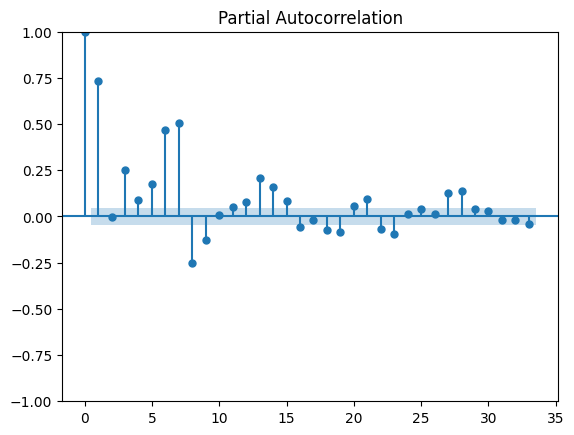

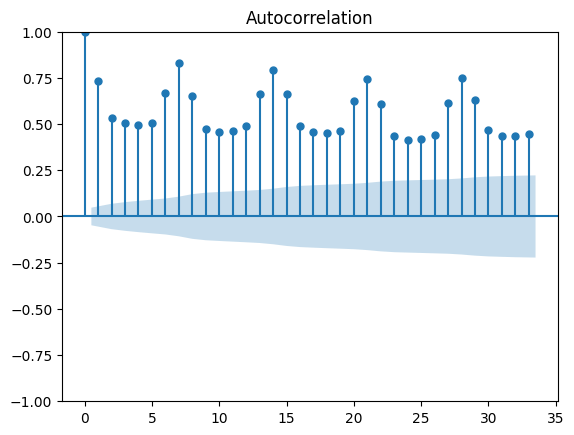

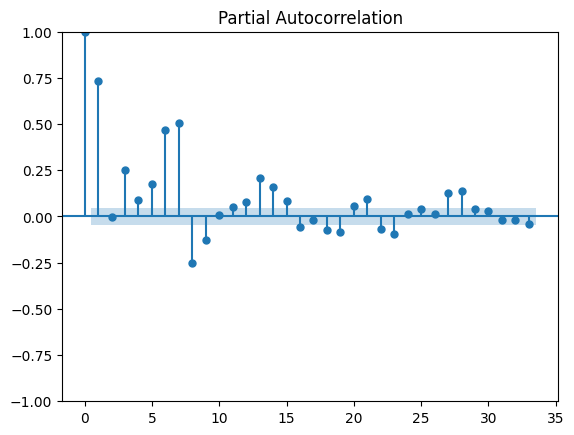

In [40]:
# Autoregressive Integrated Moving Average (ARIMA)
plot_acf(dailySales) 
plot_pacf(dailySales) 

##### __Try ARIMA models on cumulative sales data__

In [41]:
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

# test for stationarity
adf_test =  ADFTest(alpha = 0.05)
adf_test.should_diff(dailySales)

(0.01, False)

The ‘Augmented Dickey-Fuller Test’ is used to check whether the data is stationary. The results show the data is not stationary, so the Integrated parameter of the ARIMA model should be used.

In [42]:
%%time
# use auto_arima to find best parameters for ARIMA model
arima_model = auto_arima(mytrain, start_p=0, d=1, start_q=0, max_p=6, max_q=6, start_P=0, D=1, start_Q=0, max_P=6, max_D=5, max_Q=6, m=7, 
                         seasonal=True, error_action='warn', trace = True, suppress_warnings=True, stepwise=True, random_state=0,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=35286.991, Time=0.08 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=34992.629, Time=0.35 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=0.54 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=35168.102, Time=0.13 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=34894.089, Time=0.78 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=34846.864, Time=1.35 sec
 ARIMA(1,1,0)(4,1,0)[7]             : AIC=34831.667, Time=6.47 sec
 ARIMA(1,1,0)(5,1,0)[7]             : AIC=34787.955, Time=8.15 sec
 ARIMA(1,1,0)(6,1,0)[7]             : AIC=34763.853, Time=11.41 sec
 ARIMA(1,1,0)(6,1,1)[7]             : AIC=inf, Time=21.29 sec
 ARIMA(1,1,0)(5,1,1)[7]             : AIC=inf, Time=14.39 sec
 ARIMA(0,1,0)(6,1,0)[7]             : AIC=34846.348, Time=8.27 sec
 ARIMA(2,1,0)(6,1,0)[7]             : AIC=34701.324, Time=12.68 sec
 ARIMA(2,1,0)(5,1,0)[7]             : AIC=34728.668, Time=9.86 sec
 ARIMA(2,1,0)(6,1,1)[7]          

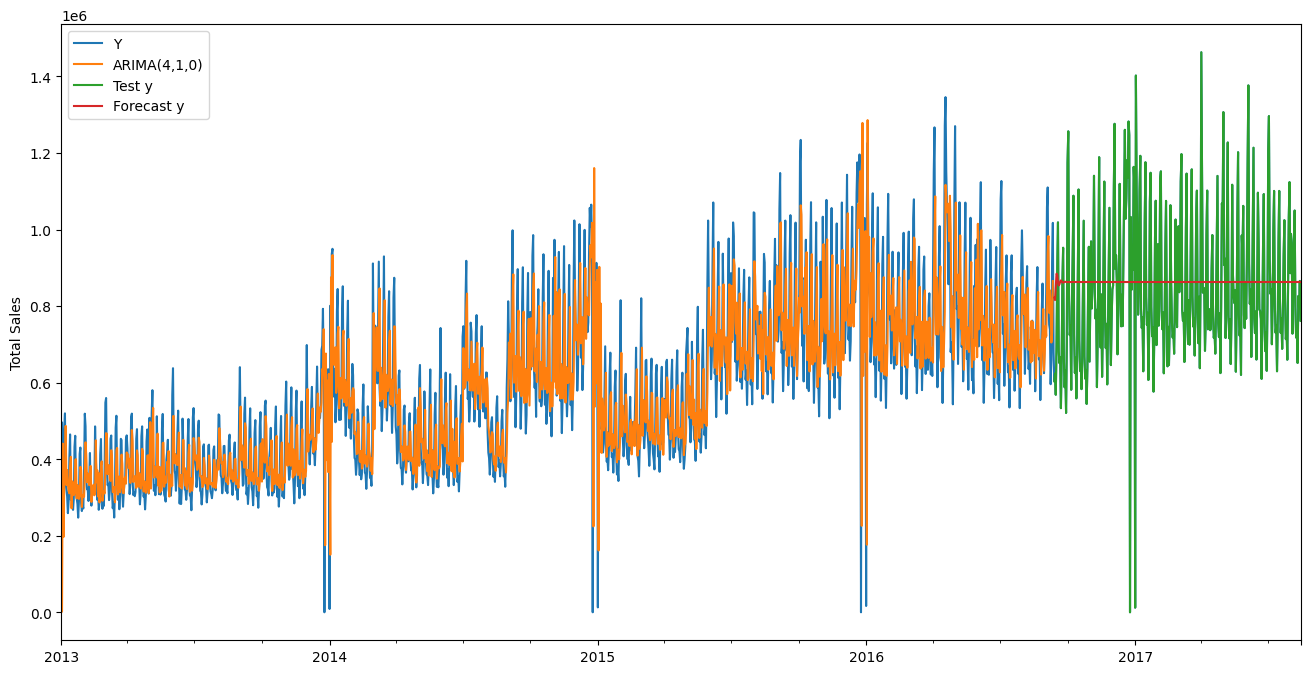

In [43]:
# Non-seasonal ARIMA(4,1,0) model
ARIMA411model = ARIMA(mytrain, order=(4,1,0),) 
fit = ARIMA411model.fit() 
pred = fit.get_prediction(start="2016-09-13", end="2017-08-15") 
df3 = pred.summary_frame() 
df3['test']=mytest 
dailySales.plot(figsize=(16, 8), label="Y") 
plt.ylabel("Total Sales") 
fit.fittedvalues.plot(label="ARIMA(4,1,0)") 
df3['test'].plot(label='Test y') 
df3['mean'].plot(label='Forecast y') 
plt.legend();

CPU times: total: 1.22 s
Wall time: 2.7 s


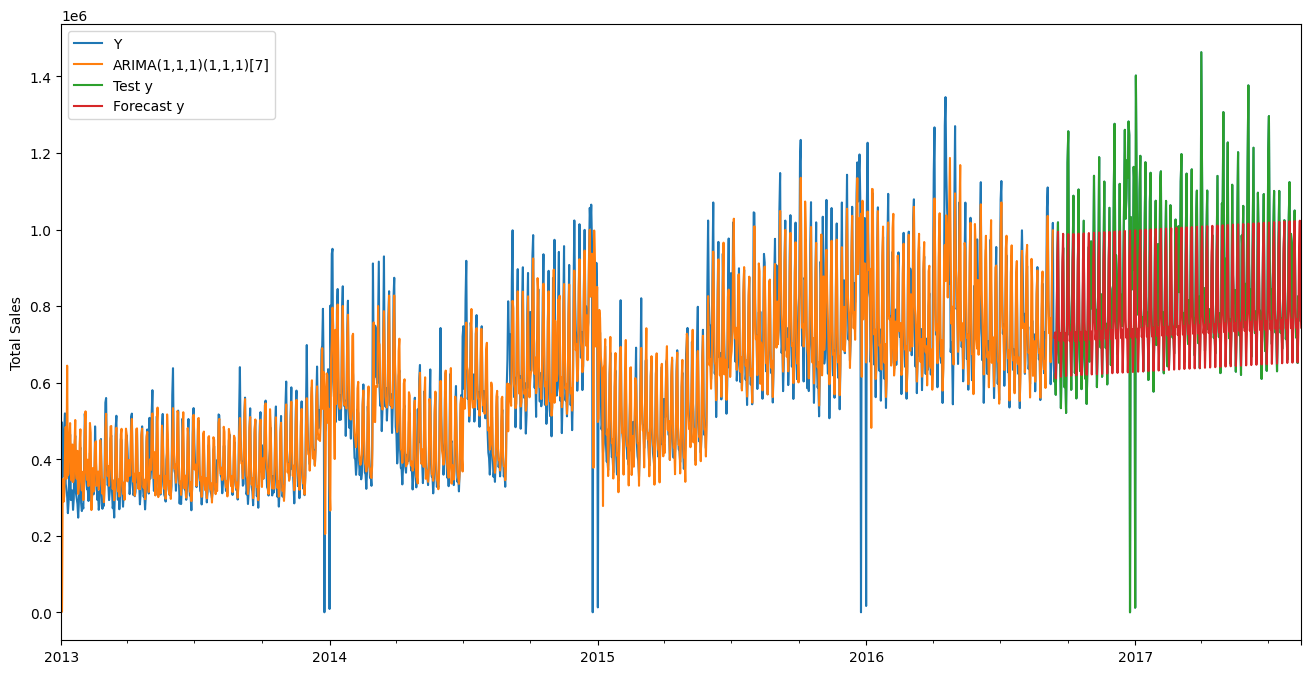

In [44]:
%%time
# Seasonal ARIMA(1,1,1)(1,1,1)[7] Model 
ARIMA1117model = ARIMA(mytrain, order=(1,1,1), seasonal_order=(1,1,1,7),) 
fit = ARIMA1117model.fit() 
pred = fit.get_prediction(start="2016-09-13", end="2017-08-15") 
df4 = pred.summary_frame() 
df4['test']=mytest 
dailySales.plot(figsize=(16, 8), label="Y") 
plt.ylabel("Total Sales") 
fit.fittedvalues.plot(label="ARIMA(1,1,1)(1,1,1)[7]") 
df4['test'].plot(label='Test y') 
df4['mean'].plot(label='Forecast y') 
plt.legend();

CPU times: total: 13.4 s
Wall time: 17.2 s


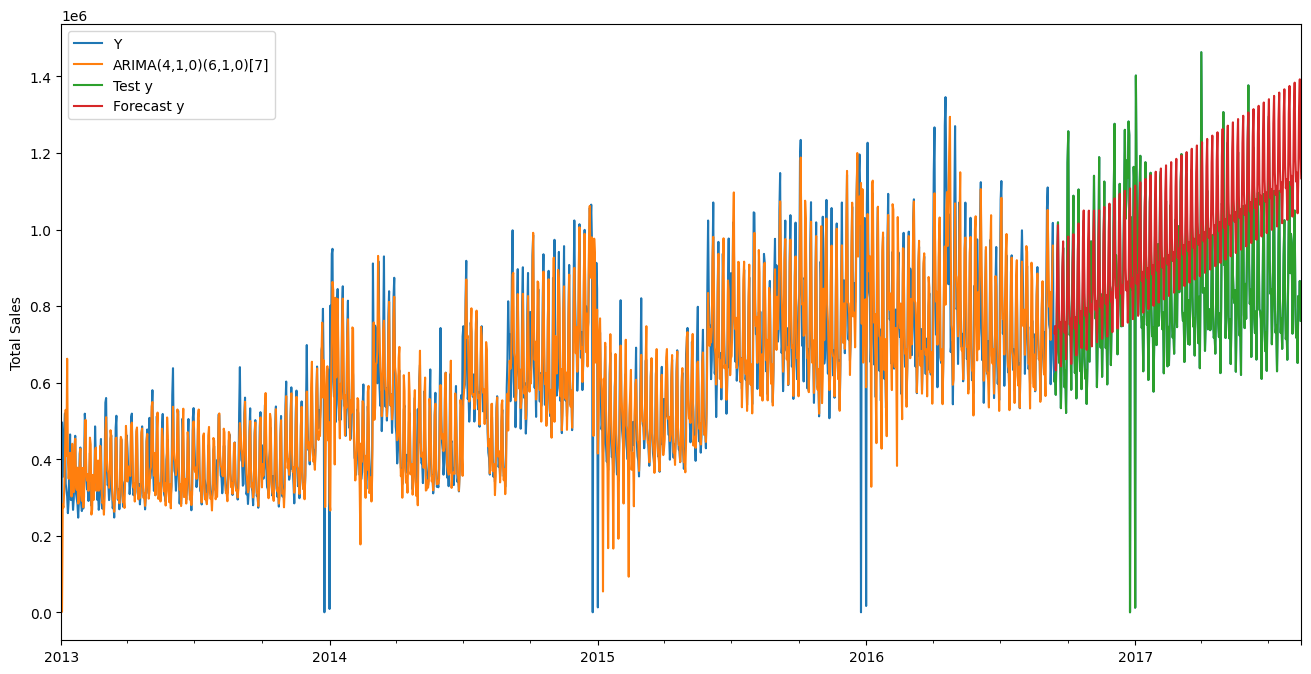

In [45]:
%%time
# Seasonal ARIMA Model 
ARIMA6107model = ARIMA(mytrain, order=(4,1,0), seasonal_order=(6,1,0,7),) 
fit = ARIMA6107model.fit() 
pred = fit.get_prediction(start="2016-09-13", end="2017-08-15") 
df5 = pred.summary_frame() 
df5['test']=mytest 
dailySales.plot(figsize=(16, 8), label="Y") 
plt.ylabel("Total Sales") 
fit.fittedvalues.plot(label="ARIMA(4,1,0)(6,1,0)[7]") 
df5['test'].plot(label='Test y') 
df5['mean'].plot(label='Forecast y') 
plt.legend();

In [46]:
m1=myf(mytest, df['mean']) 
m3=myf(mytest,df3['mean']) 
m4=myf(mytest,df4['mean']) 
m5=myf(mytest,df5['mean']) 
newdf=pd.DataFrame([m1,m3,m4,m5]) 
newdf.index=['ETS(AAA)', 'ARIMA(4,1,0)','ARIMA(1,1,1)(1,1,1)[7]','ARIMA(4,1,0)(6,1,0)[7]'] 
newdf

MSE          RMSE           MAE  MAPE  \
ETS(AAA)                6.111516e+13  7.817618e+06  7.817618e+06   inf   
ARIMA(4,1,0)            3.208005e+13  5.663925e+06  5.663925e+06   inf   
ARIMA(1,1,1)(1,1,1)[7]  3.471870e+14  1.863295e+07  1.863295e+07   inf   
ARIMA(4,1,0)(6,1,0)[7]  2.418096e+15  4.917414e+07  4.917414e+07   inf   

                                  ME  MPE  RMSLE  
ETS(AAA)                7.817618e+06 -inf  0.802  
ARIMA(4,1,0)           -5.663925e+06 -inf  0.807  
ARIMA(1,1,1)(1,1,1)[7]  1.863295e+07 -inf  0.803  
ARIMA(4,1,0)(6,1,0)[7] -4.917414e+07 -inf  0.830

##### __Next, try Seasonal ARIMA(1,1,1)(1,1,1)[7] Model on the store and family groups__

In [47]:
%%time

ARIMAfitted_wide = pd.DataFrame()
ARIMAforecastWide = pd.DataFrame()
ARIMApredSummaryFrame = pd.DataFrame()

for group, group_data in train.groupby('group'):
    ARIMA1117model = ARIMA(group_data['sales'], order=(1,1,1), seasonal_order=(1,1,1,7),) 
    results = ARIMA1117model.fit()
    ARIMAfitted_wide = ARIMAfitted_wide.append(pd.DataFrame({'group': [group], **results.fittedvalues}), ignore_index=True)
    pred = results.get_prediction(start="2017-08-16", end="2017-08-31")
    ARIMApredSummaryFrame = pred.summary_frame() 
    ARIMAforecastWide = ARIMAforecastWide.append(pd.DataFrame({'group': [group], **ARIMApredSummaryFrame['mean']}), ignore_index=True)

# transpose from wide to long
ARIMAfitted = pd.melt(ARIMAfitted_wide, id_vars=['group'], value_vars=ARIMAfitted_wide.columns, var_name='date', value_name='sales')
ARIMAforecast = pd.melt(ARIMAforecastWide, id_vars=['group'], value_vars=ARIMAforecastWide.columns, var_name='date', value_name='sales')
ARIMAforecast

CPU times: total: 12min 49s
Wall time: 1h 13min 16s


group        date        sales
0                      1-AUTOMOTIVE  2017-08-16     2.745434
1                       1-BABY CARE  2017-08-16     0.000000
2                          1-BEAUTY  2017-08-16     2.433592
3                       1-BEVERAGES  2017-08-16   977.517084
4                           1-BOOKS  2017-08-16     0.032540
...                             ...         ...          ...
28507                     9-POULTRY  2017-08-31   397.274848
28508              9-PREPARED FOODS  2017-08-31   111.626139
28509                     9-PRODUCE  2017-08-31  1391.876316
28510  9-SCHOOL AND OFFICE SUPPLIES  2017-08-31   158.228699
28511                     9-SEAFOOD  2017-08-31    16.017320

[28512 rows x 3 columns]

##### __Export ARIMA forecast on test data for submission__

In [48]:
# sort and Horizontally concatenate the ARIMAforecast and SalesTest dataframes
SalesTest.sort_values(by=['date','group'], ascending=[True, True], inplace=True)
ARIMAforecast.sort_values(by=['date','group'], ascending=[True, True], inplace=True)

ARIMAoutput = pd.concat([SalesTest, ARIMAforecast], axis=1)

# generate output for submission for ETS model
ARIMAmodel_Submission = ARIMAoutput[['id','sales']]
ARIMAmodel_Submission.to_csv(r'./store-sales-time-series-forecasting/ARIMAmodel_Submission.csv', index = False)
ARIMAmodel_Submission

id        sales
0      3000888     2.745434
1      3000889     0.000000
2      3000890     2.433592
3      3000891   977.517084
4      3000892     0.032540
...        ...          ...
28507  3029395   397.274848
28508  3029396   111.626139
28509  3029397  1391.876316
28510  3029398   158.228699
28511  3029399    16.017320

[28512 rows x 2 columns]

##### __Evaluate ARIMA Time Series Model__

In [49]:
%%time

ARIMAfitted_wide = pd.DataFrame()
ARIMAforecastWide = pd.DataFrame()
ARIMApredSummaryFrame = pd.DataFrame()

for group, group_data in GroupTrain.groupby('group'):
    ARIMA1117model = ARIMA(group_data['sales'], order=(1,1,1), seasonal_order=(1,1,1,7),)
    results = ARIMA1117model.fit()
    ARIMAfitted_wide = ARIMAfitted_wide.append(pd.DataFrame({'group': [group], **results.fittedvalues}), ignore_index=True)
    pred = results.get_prediction(start="2016-09-13", end="2017-08-15")
    ARIMApredSummaryFrame = pred.summary_frame() 
    ARIMAforecastWide = ARIMAforecastWide.append(pd.DataFrame({'group': [group], **ARIMApredSummaryFrame['mean']}), ignore_index=True)

# transpose from wide to long
ARIMAfitted = pd.melt(ARIMAfitted_wide, id_vars=['group'], value_vars=ARIMAfitted_wide.columns, var_name='date', value_name='sales')
ARIMAforecast = pd.melt(ARIMAforecastWide, id_vars=['group'], value_vars=ARIMAforecastWide.columns, var_name='date', value_name='sales')
ARIMAforecast

CPU times: total: 11min 57s
Wall time: 1h 3min 8s


group        date        sales
0                       1-AUTOMOTIVE  2016-09-13     4.725237
1                        1-BABY CARE  2016-09-13     0.000000
2                           1-BEAUTY  2016-09-13     4.317870
3                        1-BEVERAGES  2016-09-13  2281.607042
4                            1-BOOKS  2016-09-13     0.000000
...                              ...         ...          ...
600529                     9-POULTRY  2017-08-15   482.302693
600530              9-PREPARED FOODS  2017-08-15   112.911458
600531                     9-PRODUCE  2017-08-15  1661.937092
600532  9-SCHOOL AND OFFICE SUPPLIES  2017-08-15   399.825800
600533                     9-SEAFOOD  2017-08-15    23.530990

[600534 rows x 3 columns]

In [50]:
%%time
# COMBINE ACTUAL AND FITTED TRAINING DATAFRAMES TO COMPARE VALUES

# Prepare actual training sales
GroupTrain2 = GroupTrain.copy()
GroupTrain2['date'] = GroupTrain2.index
GroupTrain2['date'] = GroupTrain2['date'].dt.to_timestamp()
GroupTrain2.reset_index(drop=True, inplace=True)

# Prepare fitted sales
ARIMAfitted2 = ARIMAfitted.copy()
ARIMAfitted2['date'] = ARIMAfitted2['date'].dt.to_timestamp()
ARIMAfitted2 = ARIMAfitted2.rename(columns={'sales': 'sales_pred','group': 'group_pred', 'date':'date_pred'})

# sort the dataframes
GroupTrain2.sort_values(by=['date','group'], ascending=[True, True], inplace=True)
ARIMAfitted2.sort_values(by=['date_pred','group_pred'], ascending=[True, True], inplace=True)

# Horizontally concatenate the dataframes
CompareTrain = pd.concat([GroupTrain2, ARIMAfitted2], axis=1)
CompareTrain

CPU times: total: 2.08 s
Wall time: 2.22 s


sales                         group       date  \
0           0.000                  1-AUTOMOTIVE 2013-01-01   
1           0.000                   1-BABY CARE 2013-01-01   
2           0.000                      1-BEAUTY 2013-01-01   
3           0.000                   1-BEVERAGES 2013-01-01   
4           0.000                       1-BOOKS 2013-01-01   
...           ...                           ...        ...   
2402131   381.827                     9-POULTRY 2016-09-12   
2402132    94.039              9-PREPARED FOODS 2016-09-12   
2402133  1301.606                     9-PRODUCE 2016-09-12   
2402134    47.000  9-SCHOOL AND OFFICE SUPPLIES 2016-09-12   
2402135    12.490                     9-SEAFOOD 2016-09-12   

                           group_pred  date_pred   sales_pred  
0                        1-AUTOMOTIVE 2013-01-01     0.000000  
1                         1-BABY CARE 2013-01-01     0.000000  
2                            1-BEAUTY 2013-01-01     0.000000  
3                         1-BEVERAGES 2013-01-01     0.000000  
4                             1-BOOKS 2013-01-01     0.000000  
...                               ...        ...          ...  
2402131                     9-POULTRY 2016-09-12   423.704194  
2402132              9-PREPARED FOODS 2016-09-12   110.587275  
2402133                     9-PRODUCE 2016-09-12  1577.326911  
2402134  9-SCHOOL AND OFFICE SUPPLIES 2016-09-12   140.800074  
2402135                     9-SEAFOOD 2016-09-12    20.313215  

[2402136 rows x 6 columns]

In [51]:
%%time
# COMBINE ACTUAL AND FITTED TEST DATAFRAMES TO COMPARE VALUES

# Prepare actual test sales
GroupTest2 = GroupTest.copy()
GroupTest2['date'] = GroupTest2.index
GroupTest2['date'] = GroupTest2['date'].dt.to_timestamp()
GroupTest2.reset_index(drop=True, inplace=True)

# Prepare forecasted sales
ARIMAforecast2 = ARIMAforecast.copy()
ARIMAforecast2['date'] = ARIMAforecast2['date'].dt.to_timestamp()
ARIMAforecast2 = ARIMAforecast2[ARIMAforecast2['date'] != '2016-12-25']
ARIMAforecast2 = ARIMAforecast2.rename(columns={'sales': 'sales_pred','group': 'group_pred', 'date':'date_pred'})
ARIMAforecast2.reset_index(drop=True, inplace=True)

# sort the dataframes
GroupTest2.sort_values(by=['date','group'], ascending=[True, True], inplace=True)
ARIMAforecast2.sort_values(by=['date_pred','group_pred'], ascending=[True, True], inplace=True)

# Horizontally concatenate the dataframes
CompareTest = pd.concat([GroupTest2, ARIMAforecast2], axis=1)
CompareTest

CPU times: total: 594 ms
Wall time: 628 ms


sales                         group       date  \
0          4.000                  1-AUTOMOTIVE 2016-09-13   
1          0.000                   1-BABY CARE 2016-09-13   
2          3.000                      1-BEAUTY 2016-09-13   
3       1942.000                   1-BEVERAGES 2016-09-13   
4          0.000                       1-BOOKS 2016-09-13   
...          ...                           ...        ...   
598747   438.133                     9-POULTRY 2017-08-15   
598748   154.553              9-PREPARED FOODS 2017-08-15   
598749  2419.729                     9-PRODUCE 2017-08-15   
598750   121.000  9-SCHOOL AND OFFICE SUPPLIES 2017-08-15   
598751    16.000                     9-SEAFOOD 2017-08-15   

                          group_pred  date_pred   sales_pred  
0                       1-AUTOMOTIVE 2016-09-13     4.725237  
1                        1-BABY CARE 2016-09-13     0.000000  
2                           1-BEAUTY 2016-09-13     4.317870  
3                        1-BEVERAGES 2016-09-13  2281.607042  
4                            1-BOOKS 2016-09-13     0.000000  
...                              ...        ...          ...  
598747                     9-POULTRY 2017-08-15   482.302693  
598748              9-PREPARED FOODS 2017-08-15   112.911458  
598749                     9-PRODUCE 2017-08-15  1661.937092  
598750  9-SCHOOL AND OFFICE SUPPLIES 2017-08-15   399.825800  
598751                     9-SEAFOOD 2017-08-15    23.530990  

[598752 rows x 6 columns]

In [52]:
m1 = myf(CompareTrain['sales'], CompareTrain['sales_pred']) 
m2 = myf(CompareTest['sales'], CompareTest['sales_pred']) 
newdf=pd.DataFrame([m1,m2]) 
newdf

MSE          RMSE           MAE  MAPE            ME  MPE  RMSLE
0  9.805716e+12  3.131408e+06  3.131408e+06   inf -3.131408e+06  NaN  0.626
1  6.019464e+14  2.453460e+07  2.453460e+07   inf  2.453460e+07  NaN  0.969

CPU times: total: 188 ms
Wall time: 230 ms


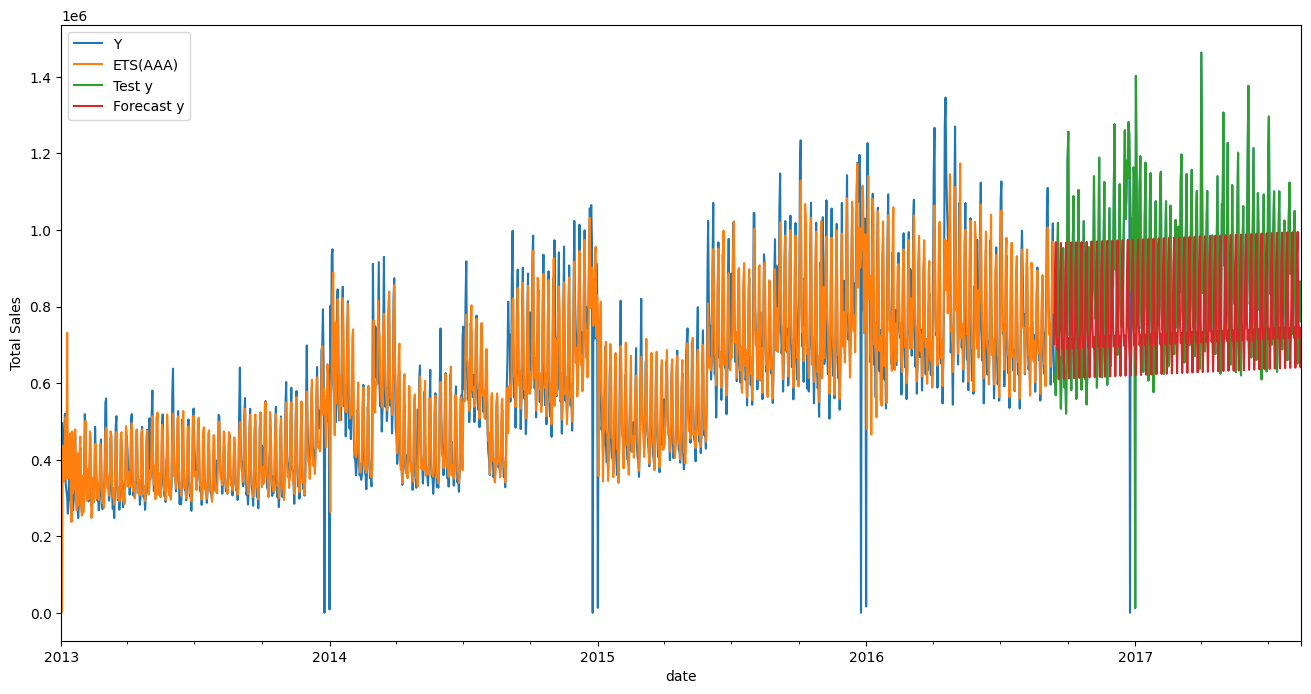

In [53]:
%%time
# PLOT THE ACTUAL, FITTED, AND FORECASTED CUMULATIVE DATA

FittedDailySales_df = pd.DataFrame(CompareTrain.groupby('date')['sales_pred'].sum())
FittedDailySales = pd.Series(FittedDailySales_df['sales_pred'].tolist(), index=FittedDailySales_df.index)

TESTDailySales_df = pd.DataFrame(CompareTest.groupby('date')['sales'].sum())
TESTDailySales = pd.Series(TESTDailySales_df['sales'].tolist(), index=TESTDailySales_df.index)

FORECASTDailySales_df = pd.DataFrame(CompareTest.groupby('date')['sales_pred'].sum())
FORECASTDailySales = pd.Series(FORECASTDailySales_df['sales_pred'].tolist(), index=FORECASTDailySales_df.index)

dailySales.plot(figsize=(16, 8), label="Y") 
plt.ylabel("Total Sales") 
plt.xlabel("Date") 
FittedDailySales.plot(label="ETS(AAA)") 
TESTDailySales.plot(label='Test y') 
FORECASTDailySales.plot(label='Forecast y') 
plt.legend();

##### __Assess residuals to investigate assumptions__

CPU times: total: 156 ms
Wall time: 274 ms


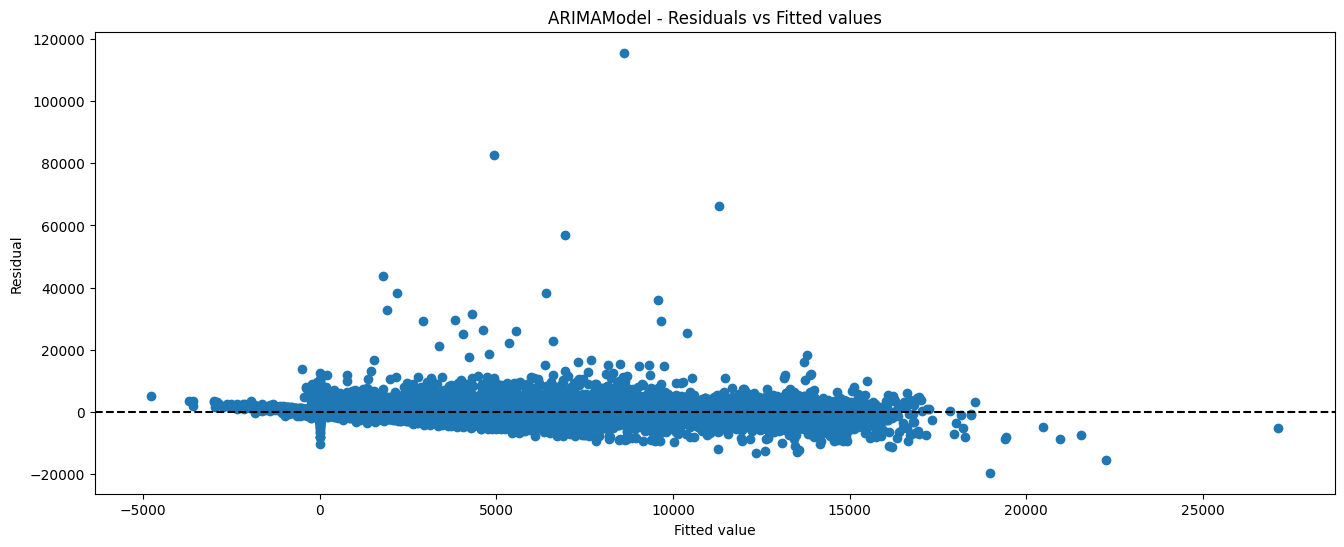

In [54]:
%%time
# scatter plot of residuals vs fitted values to assess homoscedasticity
ARIMAresiduals = CompareTrain['sales'] - CompareTrain['sales_pred']

ax = plt.subplots(figsize=(16,6))[1]
ax.scatter(CompareTrain['sales_pred'] , ETSresiduals)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.set_title('ARIMAModel - Residuals vs Fitted values')
ax.axhline(0, c='k', ls='--');

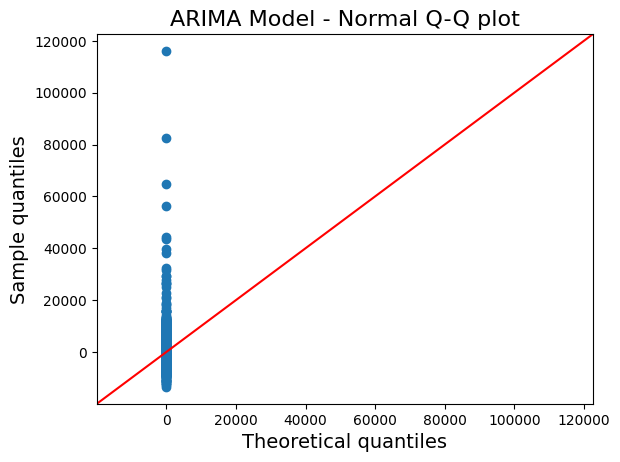

In [55]:
# Normal Q-Q Plot of Residuals to assess normality of residuals
resid = np.ravel(ARIMAresiduals)
p = sm.qqplot(resid, line='45')
plt.title('ARIMA Model - Normal Q-Q plot', fontsize=16);
plt.xlabel('Theoretical quantiles', fontsize=14);
plt.ylabel('Sample quantiles', fontsize=14);

In [56]:
# clear objects stored in RAM to free-up memory for next steps

del addETSmodel
del ARIMA1117model
del ARIMA411model
del ARIMAfitted_wide
del ARIMAfitted2
del ARIMAforecast
del ARIMAforecast2
del ARIMAforecastWide
del ARIMAoutput
del ARIMApredSummaryFrame
del CompareTest
del CompareTrain
del DateRange
del df
del df3
del df4
del ETSfitted
del ETSfitted_wide
del ETSforecast
del ETSmodel
del ETSoutput
del ETSresiduals
del ARIMAresiduals
del familySales
del fit
del FittedDailySales
del FittedDailySales_df
del FORECASTDailySales
del FORECASTDailySales_df
del ForecastSummaryFrame
del ForecastVals
del ForecastWide
del GroupPreds
del GroupPreds2
del GroupPredSummaryFrame
del GroupPredsWide
del GroupTest
del GroupTest2
del GroupTrain
del GroupTrain2
del GroupTrainFitted
del GroupTrainFitted_wide
del GroupTrainFitted2
del mytest
del mytrain
del newdf
del pred
del results
del resid
del SalesOverDateRange
del SalesPerDay
del SalesTest
del SalesTrain
del store_nbrSales
del TESTDailySales
del TESTDailySales_df
del train
del TstUniqDate
del TstUniqFamily
del TstUniqStore
del uniquefamily
del uniqueGroup
del Valpreds
del ValResults
del ZeroSales

# Force garbage collection
gc.collect()

104680

### __2. Compete in the House Prices Advanced Regression Techniques competition on Kaggle.com__
https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques

Submit two regression models for evaluation. Use dichotomous variables and interactions, polynomial terms.  Investigate subsets and evaluate transformations along with dimension reduction. Investigate assumptions. Interpret findings.

#### __EDA and Preprocessing__

In [57]:
# import training data
HousePriceTrain = pd.read_csv(r'./house-prices-advanced-regression-techniques/train.csv',index_col=0)
HousePriceTrain

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1             60       RL         65.0     8450   Pave   NaN      Reg   
2             20       RL         80.0     9600   Pave   NaN      Reg   
3             60       RL         68.0    11250   Pave   NaN      IR1   
4             70       RL         60.0     9550   Pave   NaN      IR1   
5             60       RL         84.0    14260   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
1456          60       RL         62.0     7917   Pave   NaN      Reg   
1457          20       RL         85.0    13175   Pave   NaN      Reg   
1458          70       RL         66.0     9042   Pave   NaN      Reg   
1459          20       RL         68.0     9717   Pave   NaN      Reg   
1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... PoolArea PoolQC  Fence MiscFeature  \
Id                                    ...                                      
1            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
2            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
3            Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
4            Lvl    AllPub    Corner  ...        0    NaN    NaN         NaN   
5            Lvl    AllPub       FR2  ...        0    NaN    NaN         NaN   
...          ...       ...       ...  ...      ...    ...    ...         ...   
1456         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1457         Lvl    AllPub    Inside  ...        0    NaN  MnPrv         NaN   
1458         Lvl    AllPub    Inside  ...        0    NaN  GdPrv        Shed   
1459         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   
1460         Lvl    AllPub    Inside  ...        0    NaN    NaN         NaN   

     MiscVal MoSold  YrSold  SaleType  SaleCondition  SalePrice  
Id                                                               
1          0      2    2008        WD         Normal     208500  
2          0      5    2007        WD         Normal     181500  
3          0      9    2008        WD         Normal     223500  
4          0      2    2006        WD        Abnorml     140000  
5          0     12    2008        WD         Normal     250000  
...      ...    ...     ...       ...            ...        ...  
1456       0      8    2007        WD         Normal     175000  
1457       0      2    2010        WD         Normal     210000  
1458    2500      5    2010        WD         Normal     266500  
1459       0      4    2010        WD         Normal     142125  
1460       0      6    2008        WD         Normal     147500  

[1460 rows x 80 columns]

In [58]:
# check for missing values
missing_values = HousePriceTrain.isnull().sum()
print(missing_values)

MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
Street             0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 80, dtype: int64


In [59]:
# drop the columns with missing values
HousePriceTrain.dropna(axis=1, inplace=True)

# Get the data type for remaining features
HousePriceTrain.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 61 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   int64 
 1   MSZoning       1460 non-null   object
 2   LotArea        1460 non-null   int64 
 3   Street         1460 non-null   object
 4   LotShape       1460 non-null   object
 5   LandContour    1460 non-null   object
 6   Utilities      1460 non-null   object
 7   LotConfig      1460 non-null   object
 8   LandSlope      1460 non-null   object
 9   Neighborhood   1460 non-null   object
 10  Condition1     1460 non-null   object
 11  Condition2     1460 non-null   object
 12  BldgType       1460 non-null   object
 13  HouseStyle     1460 non-null   object
 14  OverallQual    1460 non-null   int64 
 15  OverallCond    1460 non-null   int64 
 16  YearBuilt      1460 non-null   int64 
 17  YearRemodAdd   1460 non-null   int64 
 18  RoofStyle      1460 non-null

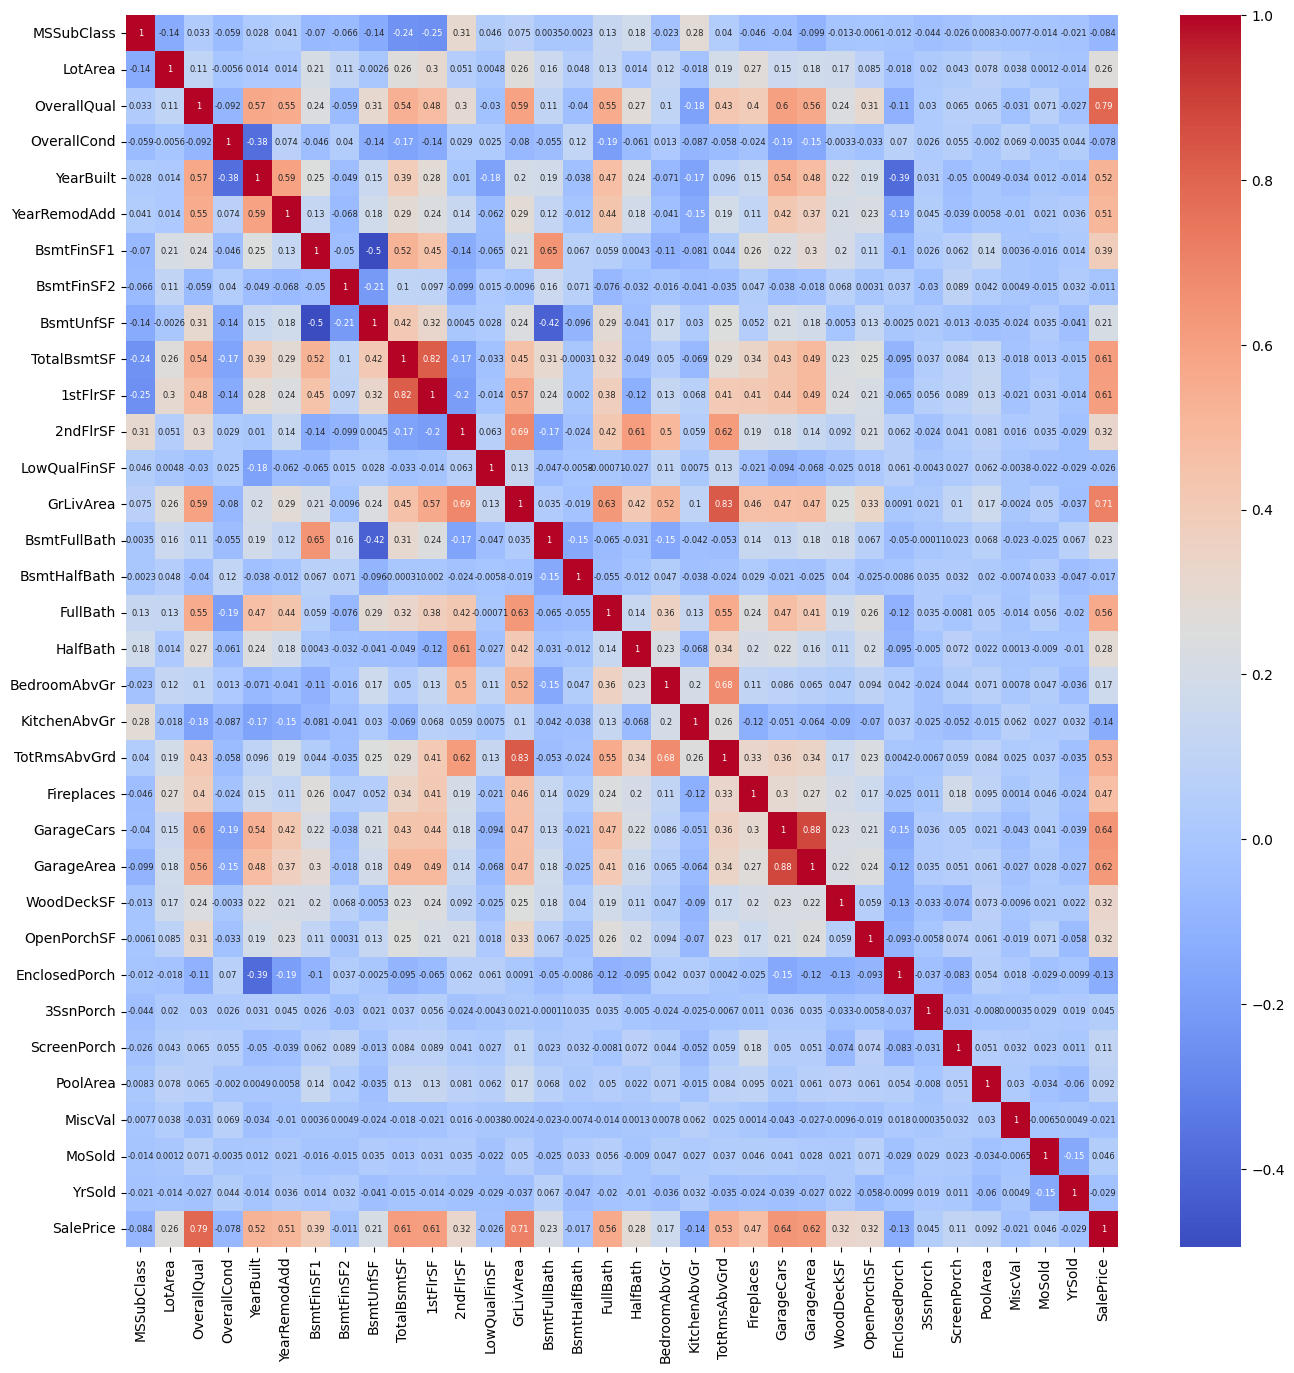

In [60]:
# compute correlation matrix
plt.figure(figsize=(16, 16)) 
corr_matrix = HousePriceTrain.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={'size': 6})
plt.show()

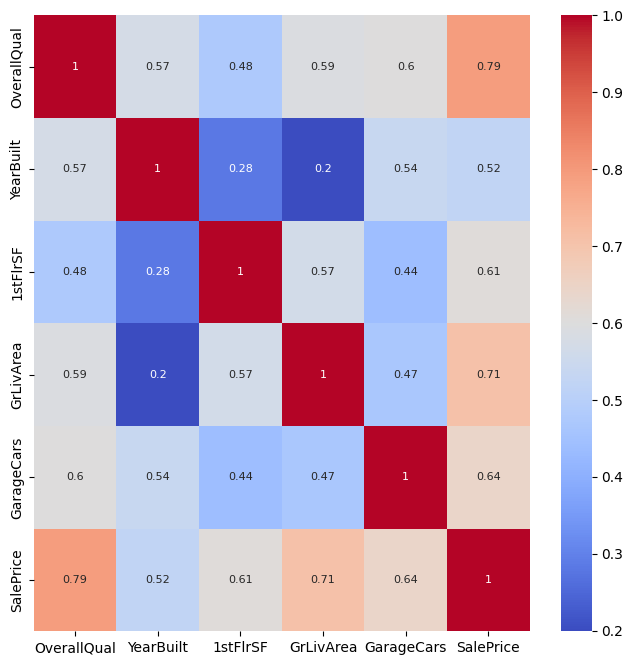

In [61]:
HousePriceTrainQuant = HousePriceTrain[['OverallQual','YearBuilt','1stFlrSF','GrLivArea','GarageCars','SalePrice']]
plt.figure(figsize=(8, 8)) 
corr_matrix = HousePriceTrainQuant.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={'size': 8})
plt.show()

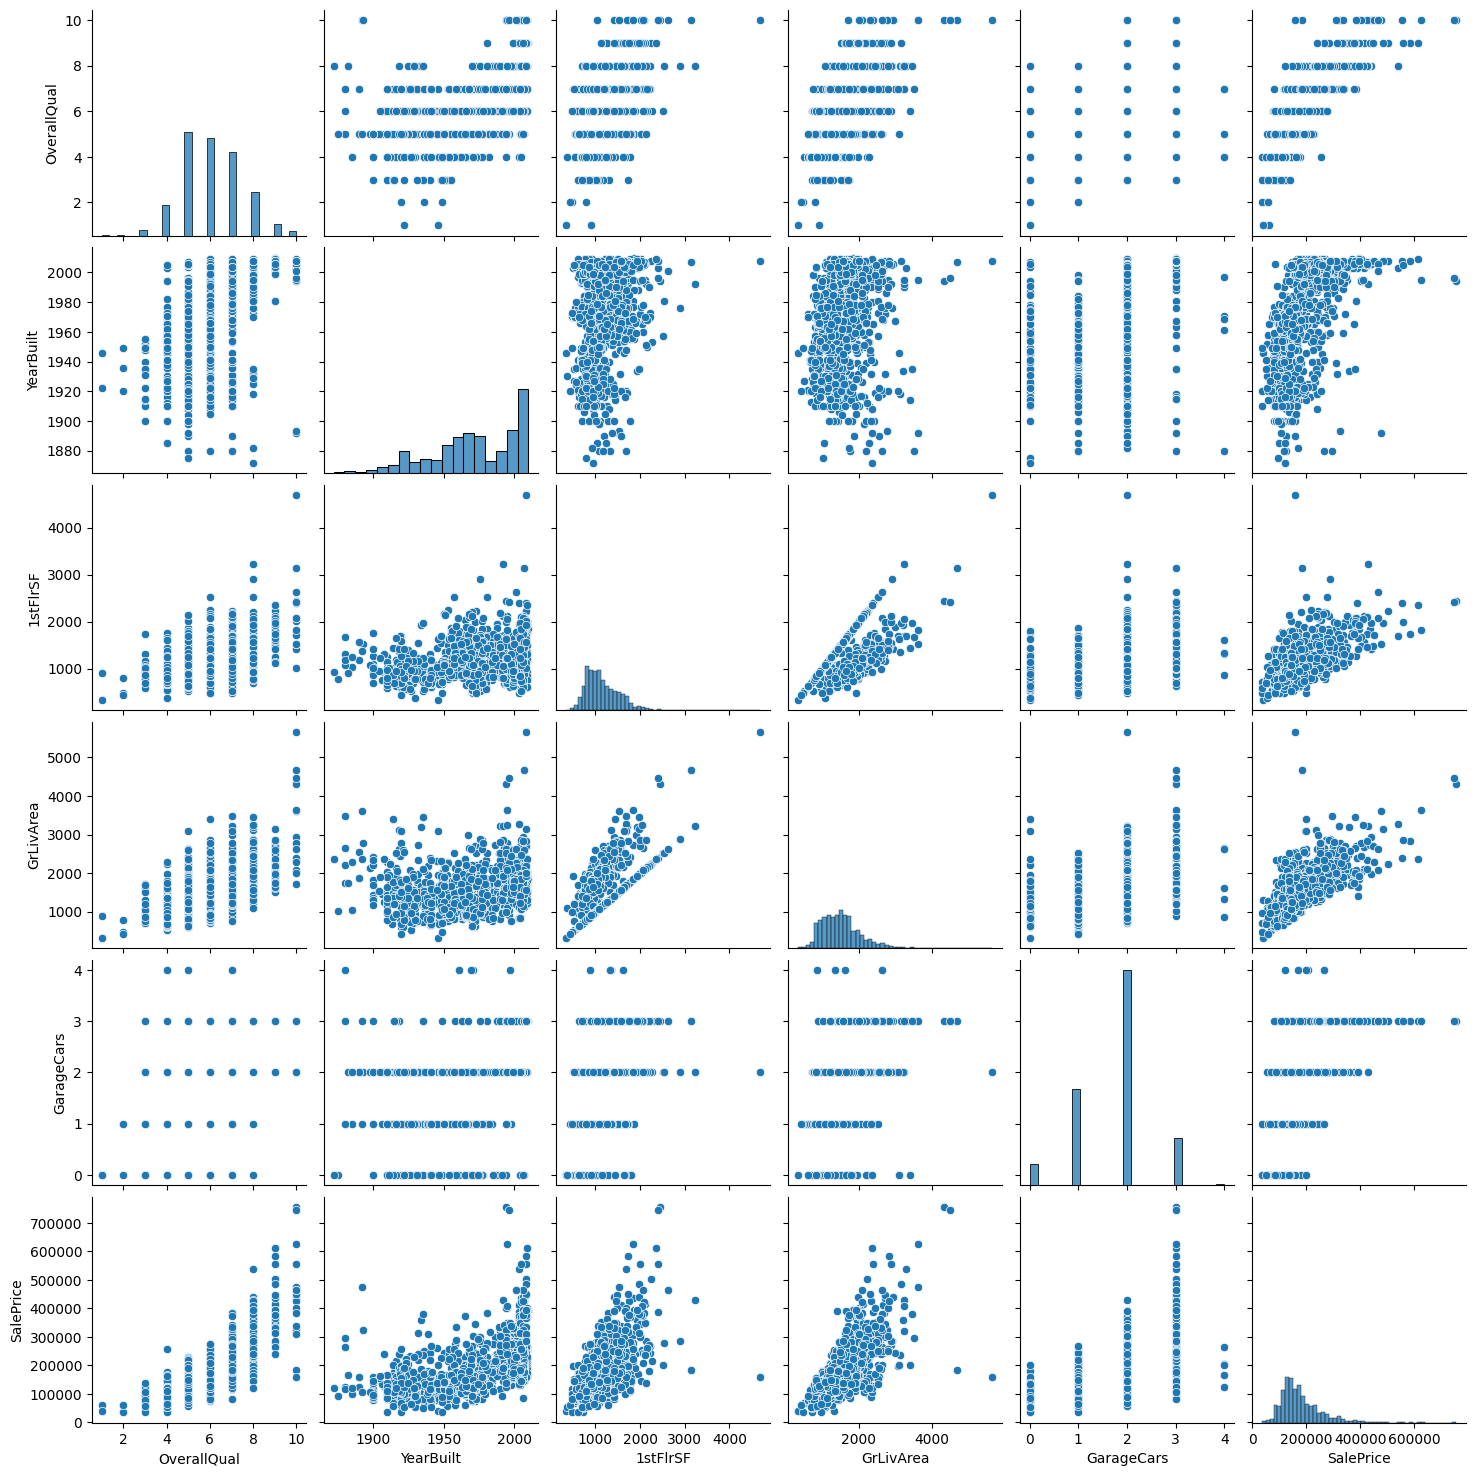

In [62]:
# check distribution of selected quantitative variables
sns.pairplot(HousePriceTrainQuant)
plt.show()

In [63]:
# Generate descriptive statistics for numeric variables
HousePriceTrainQuant.describe()

OverallQual    YearBuilt     1stFlrSF    GrLivArea   GarageCars  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean      6.099315  1971.267808  1162.626712  1515.463699     1.767123   
std       1.382997    30.202904   386.587738   525.480383     0.747315   
min       1.000000  1872.000000   334.000000   334.000000     0.000000   
25%       5.000000  1954.000000   882.000000  1129.500000     1.000000   
50%       6.000000  1973.000000  1087.000000  1464.000000     2.000000   
75%       7.000000  2000.000000  1391.250000  1776.750000     2.000000   
max      10.000000  2010.000000  4692.000000  5642.000000     4.000000   

           SalePrice  
count    1460.000000  
mean   180921.195890  
std     79442.502883  
min     34900.000000  
25%    129975.000000  
50%    163000.000000  
75%    214000.000000  
max    755000.000000

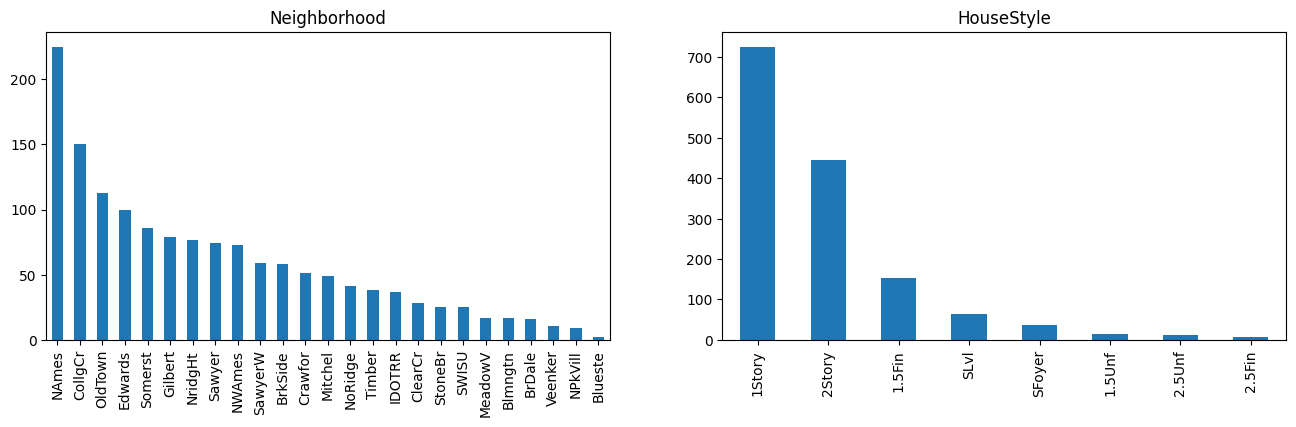

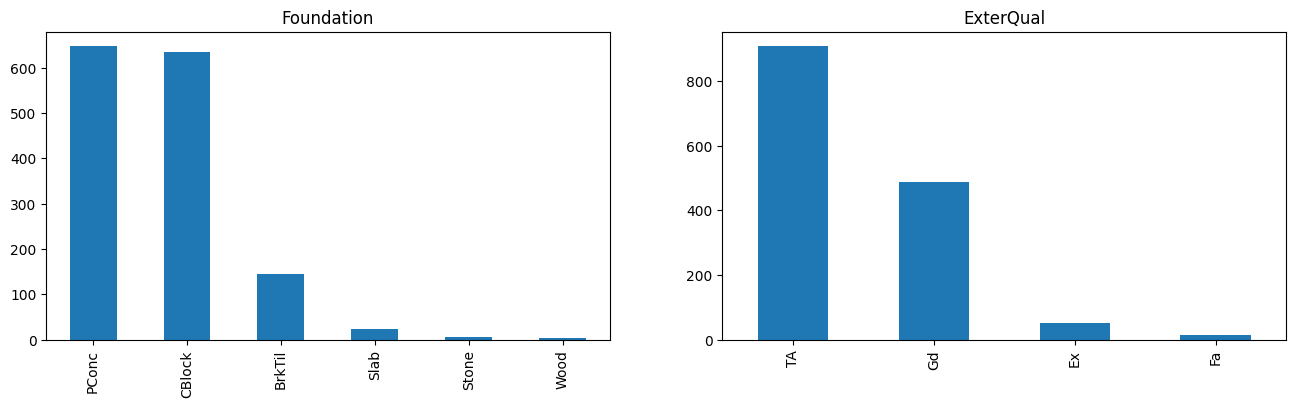

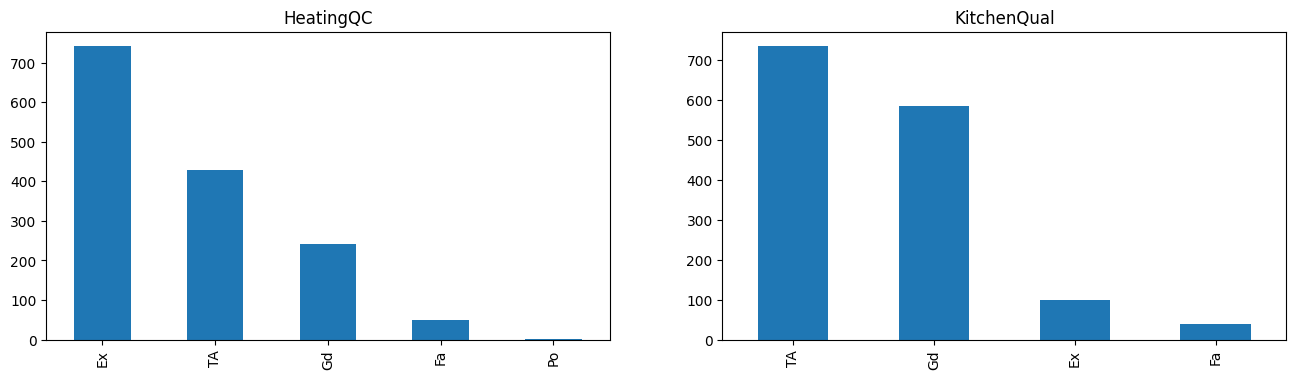

In [64]:
# check distribution of some qualitative variables

fig1 = plt.figure(figsize=(16,4))
ax1 = fig1.add_subplot(1, 2, 1) # 1 row, 2 columns, 1st subplot
HousePriceTrain['Neighborhood'].value_counts().plot(kind='bar')
ax1.set_title('Neighborhood')

ax2 = fig1.add_subplot(1, 2, 2) # 1 row, 2 columns, 2nd subplot
HousePriceTrain['HouseStyle'].value_counts().plot(kind='bar')
ax2.set_title('HouseStyle');

fig2 = plt.figure(figsize=(16,4))
ax3 = fig2.add_subplot(1, 2, 1) # 1 row, 2 columns, 1st subplot
HousePriceTrain['Foundation'].value_counts().plot(kind='bar')
ax3.set_title('Foundation');

ax4 = fig2.add_subplot(1, 2, 2) # 1 row, 2 columns, 2nd subplot
HousePriceTrain['ExterQual'].value_counts().plot(kind='bar')
ax4.set_title('ExterQual');

fig3 = plt.figure(figsize=(16,4))
ax5 = fig3.add_subplot(1, 2, 1) # 1 row, 2 columns, 1st subplot
HousePriceTrain['HeatingQC'].value_counts().plot(kind='bar')
ax5.set_title('HeatingQC');

ax6 = fig3.add_subplot(1, 2, 2) # 1 row, 2 columns, 2nd subplot
HousePriceTrain['KitchenQual'].value_counts().plot(kind='bar')
ax6.set_title('KitchenQual');

#### __Feature Engineering__
1. Combine categories to make a new categorical feature
2. Generate dummy variables for categorical feature
3. The distributions of the variables were skewed, so the data will be transformed with the transformation $\sqrt{x+1}$;
4. Scale and standardize the quantitative dependent variables

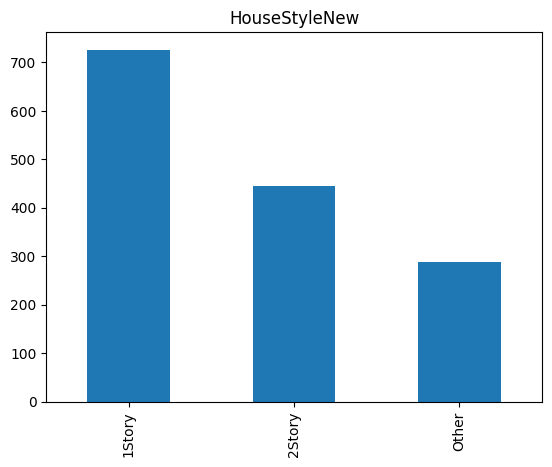

In [65]:
# Make a new qualitative variable which combines values of HouseStyle other than 1Story and 2Story
HousePriceTrain.loc[HousePriceTrain['HouseStyle'] == '1Story', 'HouseStyleNew'] = '1Story'
HousePriceTrain.loc[HousePriceTrain['HouseStyle'] == '2Story', 'HouseStyleNew'] = '2Story'
HousePriceTrain.loc[~HousePriceTrain['HouseStyle'].isin(['1Story','2Story']), 'HouseStyleNew'] = 'Other'

fig1 = plt.figure()
ax = fig1.add_subplot()
HousePriceTrain['HouseStyleNew'].value_counts().plot(kind='bar')
ax.set_title('HouseStyleNew');

In [66]:
# Generate dummy variables for HouseStyleNew
HouseStyleNewDummies = HousePriceTrain[['HouseStyleNew']]
HouseStyleNewDummies = pd.get_dummies(HouseStyleNewDummies,columns=['HouseStyleNew'],drop_first=False)
HouseStyleNewDummies.drop(['HouseStyleNew_Other'], axis=1, inplace=True)
HouseStyleNewDummies

HouseStyleNew_1Story  HouseStyleNew_2Story
Id                                              
1                        0                     1
2                        1                     0
3                        0                     1
4                        0                     1
5                        0                     1
...                    ...                   ...
1456                     0                     1
1457                     1                     0
1458                     0                     1
1459                     1                     0
1460                     1                     0

[1460 rows x 2 columns]

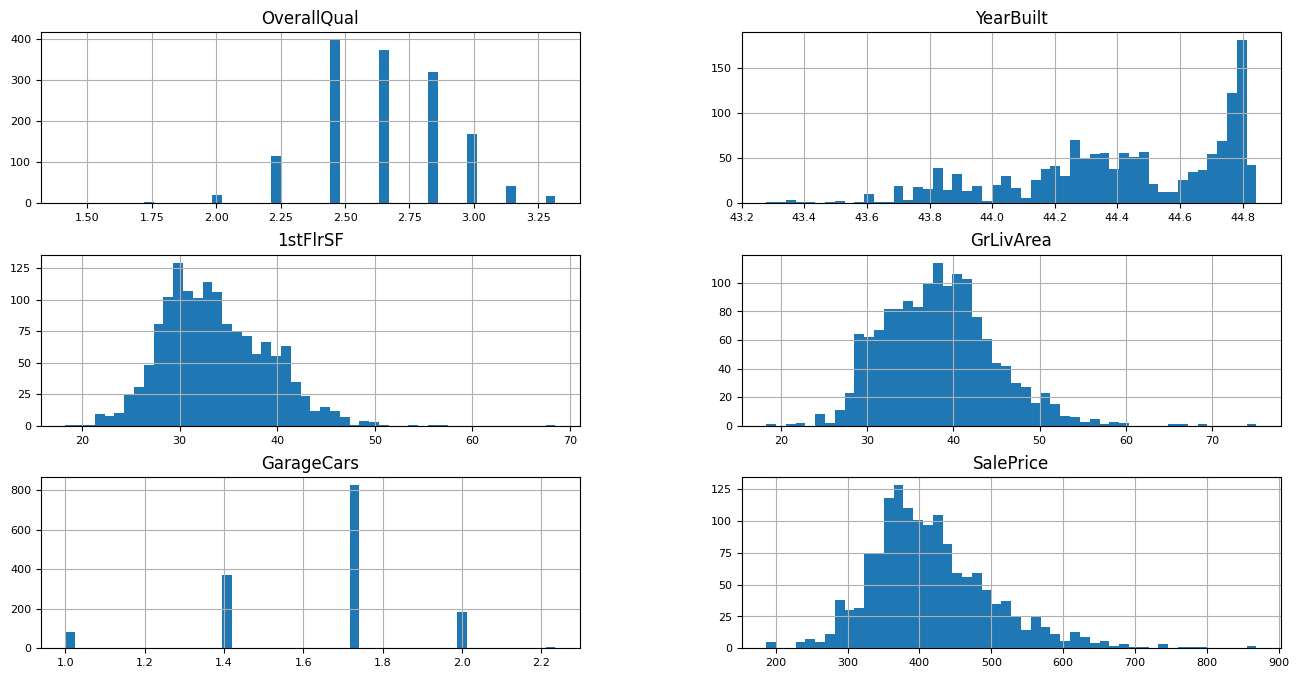

In [67]:
# Create new square root transformed features
HousePriceTrainQuantTrans = np.sqrt(HousePriceTrainQuant+1)
HousePriceTrainQuantTrans.hist(figsize=(16, 8), bins=50, xlabelsize=8, ylabelsize=8);

In [68]:
# make X and y for modeling
y = HousePriceTrainQuantTrans['SalePrice']
X = HousePriceTrainQuantTrans.drop(['SalePrice'], axis=1)
X

OverallQual  YearBuilt   1stFlrSF  GrLivArea  GarageCars
Id                                                            
1        2.828427  44.766059  29.274562  41.364236    1.732051
2        2.645751  44.463468  35.538711  35.538711    1.732051
3        2.828427  44.743715  30.347982  42.272923    1.732051
4        2.828427  43.772137  31.016125  41.448764    2.000000
5        3.000000  44.732538  33.852622  46.893496    2.000000
...           ...        ...        ...        ...         ...
1456     2.645751  44.721360  30.886890  40.595566    1.732051
1457     2.645751  44.485953  45.541190  45.541190    1.732051
1458     2.828427  44.068129  34.481879  48.383882    1.414214
1459     2.449490  44.170126  32.848135  32.848135    1.414214
1460     2.449490  44.339599  35.454196  35.454196    1.414214

[1460 rows x 5 columns]

In [69]:
# Scale and standardize the quantitative dependent variables
scaler = StandardScaler(with_std=True , with_mean=True)
Xscaled = scaler.fit_transform(X)

# make data frame to check variance and mean
Xscaled_df = pd.DataFrame(Xscaled,columns = X.columns, index=X.index)
Xscaled_df.describe()

OverallQual     YearBuilt      1stFlrSF     GrLivArea    GarageCars
count  1.460000e+03  1.460000e+03  1.460000e+03  1.460000e+03  1.460000e+03
mean   1.187482e-15 -3.219343e-15  2.737536e-16 -5.815744e-16 -1.017147e-15
std    1.000343e+00  1.000343e+00  1.000343e+00  1.000343e+00  1.000343e+00
min   -4.730563e+00 -3.318359e+00 -2.837605e+00 -3.113819e+00 -2.690990e+00
25%   -7.726213e-01 -5.679538e-01 -7.314694e-01 -7.405222e-01 -9.656711e-01
50%   -2.229799e-02  6.105632e-02 -1.280803e-01 -1.978955e-02  3.582123e-01
75%    6.760859e-01  9.497283e-01  6.706541e-01  5.825315e-01  3.582123e-01
max    2.542504e+00  1.277343e+00  6.427232e+00  5.688023e+00  2.457589e+00

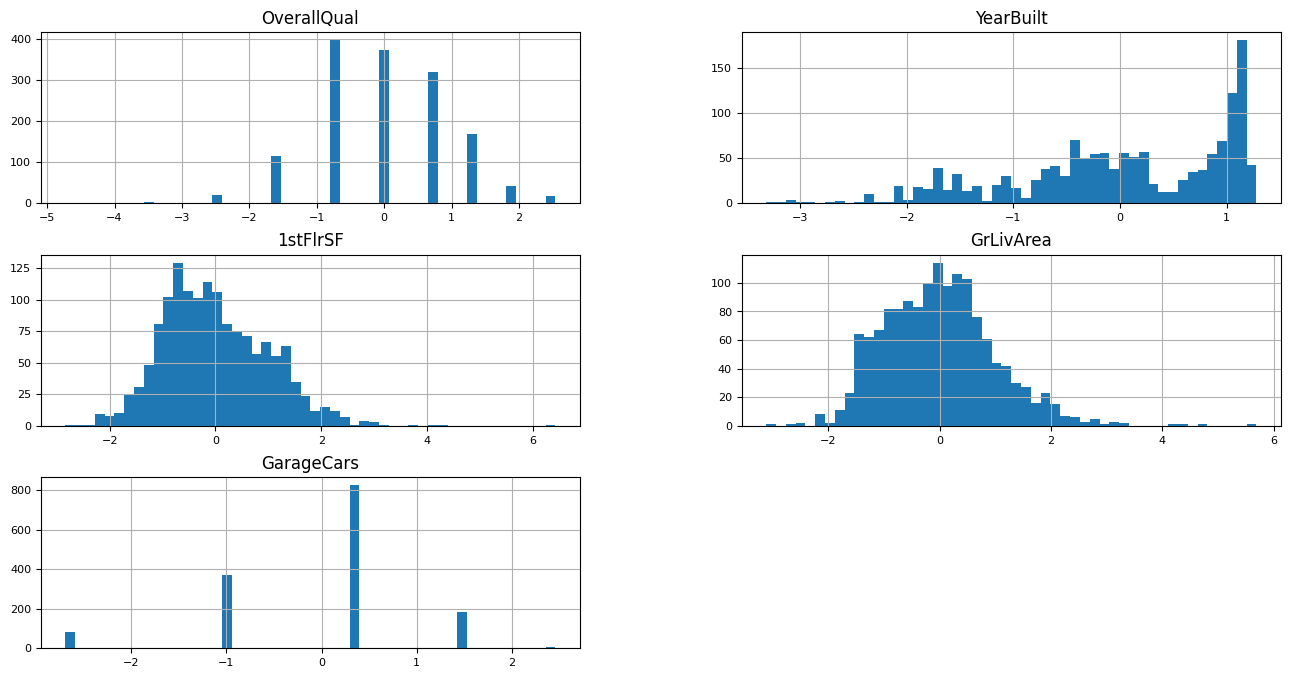

In [70]:
Xscaled_df.hist(figsize=(16, 8), bins=50, xlabelsize=8, ylabelsize=8);

In [71]:
# add dummy variables to Xscaled_df
Xscaled_df['HouseStyleNew_1Story'] = HouseStyleNewDummies['HouseStyleNew_1Story']
Xscaled_df['HouseStyleNew_2Story'] = HouseStyleNewDummies['HouseStyleNew_2Story']

# add interaction variables to to Xscaled_df
Xscaled_df['interaction1Story'] = Xscaled_df['OverallQual']*Xscaled_df['HouseStyleNew_1Story']
Xscaled_df['interaction2Story'] = Xscaled_df['OverallQual']*Xscaled_df['HouseStyleNew_2Story']
Xscaled_df

OverallQual  YearBuilt  1stFlrSF  GrLivArea  GarageCars  \
Id                                                              
1        0.676086   1.048099 -0.812810   0.458733    0.358212   
2       -0.022298   0.160097  0.343235  -0.443734    0.358212   
3        0.676086   0.982527 -0.614711   0.599503    0.358212   
4        0.676086  -1.868729 -0.491406   0.471828    1.474298   
5        1.332022   0.949728  0.032068   1.315303    1.474298   
...           ...        ...       ...        ...         ...   
1456    -0.022298   0.916922 -0.515256   0.339654    0.358212   
1457    -0.022298   0.226082  2.189187   1.105810    0.358212   
1458     0.676086  -1.000092  0.148197   1.546188   -0.965671   
1459    -0.772621  -0.700766 -0.153309  -0.860547   -0.965671   
1460    -0.772621  -0.203419  0.327638  -0.456826   -0.965671   

      HouseStyleNew_1Story  HouseStyleNew_2Story  interaction1Story  \
Id                                                                    
1                        0                     1           0.000000   
2                        1                     0          -0.022298   
3                        0                     1           0.000000   
4                        0                     1           0.000000   
5                        0                     1           0.000000   
...                    ...                   ...                ...   
1456                     0                     1          -0.000000   
1457                     1                     0          -0.022298   
1458                     0                     1           0.000000   
1459                     1                     0          -0.772621   
1460                     1                     0          -0.772621   

      interaction2Story  
Id                       
1              0.676086  
2             -0.000000  
3              0.676086  
4              0.676086  
5              1.332022  
...                 ...  
1456          -0.022298  
1457          -0.000000  
1458           0.676086  
1459          -0.000000  
1460          -0.000000  

[1460 rows x 9 columns]

#### __Regression Model 1: Polynomial Regression with dichotomous variables and interactions__

In [72]:
# perform hypothesis tests decide on the degree of the polynomial to use
models = [MS([poly('OverallQual', degree=d)])
          for d in range(1, 7)]

Xs = [model.fit_transform(Xscaled_df) for model in models]
anova_lm(*[sm.OLS(y, X_).fit()
           for X_ in Xs])

df_resid           ssr  df_diff        ss_diff           F        Pr(>F)
0    1458.0  3.792516e+06      0.0            NaN         NaN           NaN
1    1457.0  3.411325e+06      1.0  381191.362583  165.940457  4.870623e-36
2    1456.0  3.366177e+06      1.0   45147.724374   19.653735  9.978283e-06
3    1455.0  3.364367e+06      1.0    1810.379357    0.788095  3.748234e-01
4    1454.0  3.339883e+06      1.0   24483.618347   10.658224  1.121314e-03
5    1453.0  3.337770e+06      1.0    2113.563652    0.920078  3.376141e-01

The hypothesis test in the ANOVA table tests the null hypothesis that there is no difference between two models, against the alternative hypothesis that the larger model is statistically significantly better. The null hypothesis is rejected in favor of the alternative hypothesis when the p-value is less than $\alpha$ (0.05).  
*  The p-value comparing the linear model[0] to the quadratic model[1] is 7.952085e-36, which is statistically significant and shows that a quadratic model is better than a linear model.
*  The p-value comparing the quadratic model[1] to the cubic model[2] is 1.066312e-05, which is statistically significant and shows that a cubic model is better than a quadratic model.
* The p-value comparing the cubic model[2] to the quartic model[3] is 0.376, which is not statistically significant, therefore the null hypothesis cannot be rejected, thus there is no difference between the cubic and quartic models, so the simpler cubic model is selected.

In [73]:
# perform cubic polynomial regression and include dichotomous dummy variables and interactions
Xpoly = MS([poly('OverallQual', degree=3),'YearBuilt','1stFlrSF','GrLivArea','GarageCars',
            'HouseStyleNew_1Story','HouseStyleNew_2Story','interaction1Story','interaction2Story']).fit(Xscaled_df)

PolyRegModel = sm.OLS(y, Xpoly.transform(Xscaled_df)).fit()

summarize(PolyRegModel)

coef  std err        t  P>|t|
intercept                        413.4034    2.559  161.520  0.000
poly(OverallQual, degree=3)[0]  1092.6666  112.711    9.694  0.000
poly(OverallQual, degree=3)[1]   377.1356   38.571    9.778  0.000
poly(OverallQual, degree=3)[2]   167.8131   37.834    4.435  0.000
YearBuilt                         14.6333    1.357   10.783  0.000
1stFlrSF                           7.8613    2.515    3.125  0.002
GrLivArea                         30.5247    2.644   11.543  0.000
GarageCars                        10.5946    1.280    8.276  0.000
HouseStyleNew_1Story               7.2753    3.785    1.922  0.055
HouseStyleNew_2Story              -3.4051    3.986   -0.854  0.393
interaction1Story                  4.8307    3.141    1.538  0.124
interaction2Story                  7.0810    3.642    1.944  0.052

In [74]:
#view model summary
print(PolyRegModel.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     610.9
Date:                Fri, 03 Jan 2025   Prob (F-statistic):               0.00
Time:                        10:50:17   Log-Likelihood:                -7307.6
No. Observations:                1460   AIC:                         1.464e+04
Df Residuals:                    1448   BIC:                         1.470e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
intercept   

##### __Evaluate Polynomial Regression with dichotomous variables and interactions__

In [75]:
# define function to calculate ME, MPE, MAPE, MAE, MSE, RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

def myf(y,yhat):
    r2 = r2_score(y, yhat)
    ME=np.round(np.mean(y-yhat),3)
    MPE=np.round(np.mean((y-yhat)/y),3)
    myMAE=np.round(MAE(y,yhat),3)
    myMSE=np.round(MSE(y,yhat),3)
    RMSE=np.round(myMSE**.5,3)
    myMAPE=np.round(MAPE(y,yhat),3)
    myRMSLE=np.round(rmsle(y,yhat),3)
    print("\n","R-squared:", np.round(r2,3),"\n","ME:", np.round(ME,3),"\n","MPE:",MPE,"\n",
          "MAE:", myMAE,"\n", "MAPE:",myMAPE,"\n", "MSE:", myMSE,"\n","RMSE:",RMSE,"\n","RMSLE:",myRMSLE)

In [76]:
# evaluate PolyRegModel
y_pred = PolyRegModel.predict(Xpoly.transform(Xscaled_df))
myf(y, y_pred)


 R-squared: 0.823 
 ME: 0.0 
 MPE: -0.007 
 MAE: 25.165 
 MAPE: 0.062 
 MSE: 1303.138 
 RMSE: 36.099 
 RMSLE: 0.084


##### __Assess residuals of PolyRegModel to investigate assumptions__

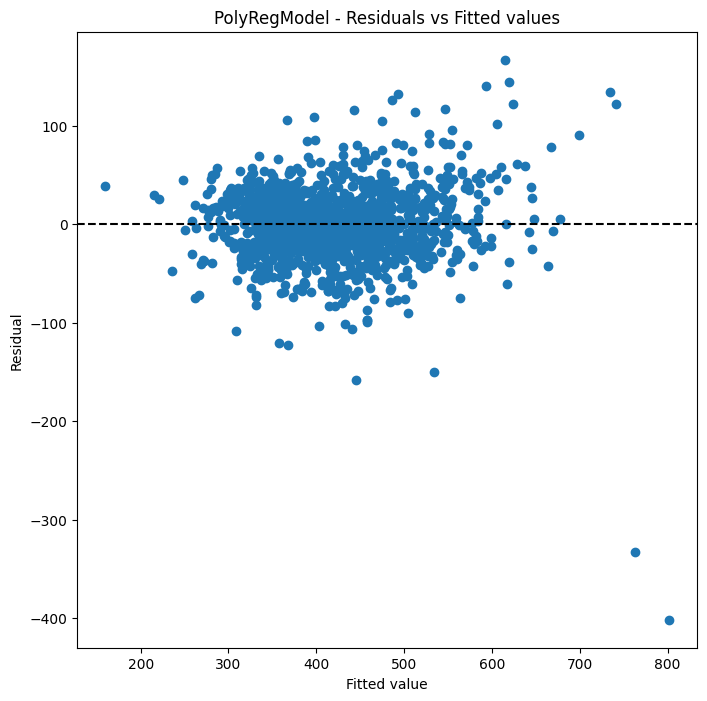

In [77]:
# scatter plot of residuals vs fitted values to assess homoscedasticity
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(PolyRegModel.fittedvalues , PolyRegModel.resid)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.set_title('PolyRegModel - Residuals vs Fitted values')
ax.axhline(0, c='k', ls='--');

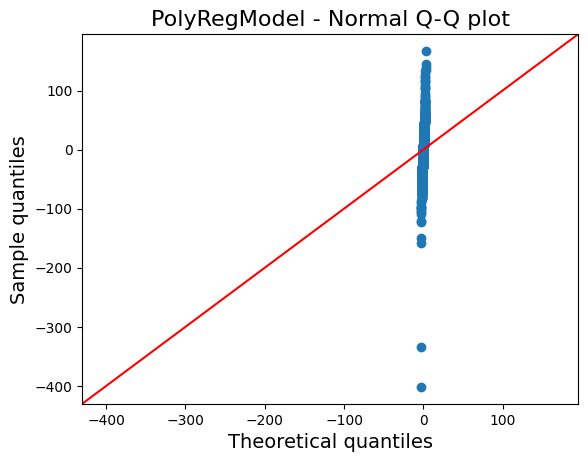

In [78]:
# Normal Q-Q Plot of Residuals to assess normality of residuals
resid = np.ravel(PolyRegModel.resid)
p = sm.qqplot(resid, line='45')
plt.title('PolyRegModel - Normal Q-Q plot', fontsize=16);
plt.xlabel('Theoretical quantiles', fontsize=14);
plt.ylabel('Sample quantiles', fontsize=14);

375

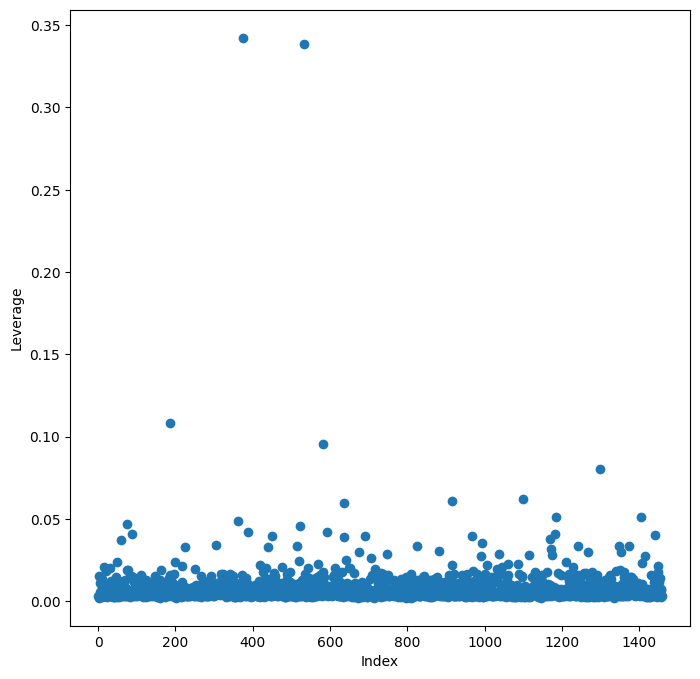

In [79]:
# Calculate Leverage statistics to identify high leverage observations
x = Xpoly.transform(Xscaled_df)
infl = PolyRegModel.get_influence()
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(np.arange(x.shape[0]), infl.hat_matrix_diag)
ax.set_xlabel('Index')
ax.set_ylabel('Leverage')
np.argmax(infl.hat_matrix_diag)

In [80]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x.values, i) for i in range(x.shape[1])]
vif["features"] = x.columns
print(vif)

    VIF Factor                        features
0     7.279029                       intercept
1     9.668523  poly(OverallQual, degree=3)[0]
2     1.132244  poly(OverallQual, degree=3)[1]
3     1.089430  poly(OverallQual, degree=3)[2]
4     2.046439                       YearBuilt
5     7.030520                        1stFlrSF
6     7.770512                       GrLivArea
7     1.820851                      GarageCars
8     3.979163            HouseStyleNew_1Story
9     3.740023            HouseStyleNew_2Story
10    6.443214               interaction1Story
11    3.640086               interaction2Story


#### __Regression Model 2: Principal Components Regression to investigate subsets and dimensionality reduction__

In [81]:
Xpcr = Xpoly.transform(Xscaled_df)
Xpcr = Xpcr.drop('intercept', axis=1)

pca = PCA(n_components=5)
linreg = skl.LinearRegression()
PCRmodel = Pipeline([('pca', pca), ('linreg', linreg)])
PCRmodel.fit(Xpcr, y)

# Print the ratio of explained variance
PCRmodel.named_steps['pca'].explained_variance_ratio_

array([0.47617324, 0.16952546, 0.15600006, 0.07992676, 0.07475961])

In [82]:
#print regression coefficients
pd.DataFrame(zip(Xpcr.columns, PCRmodel.named_steps['linreg'].coef_))

0          1
0  poly(OverallQual, degree=3)[0]  47.028779
1  poly(OverallQual, degree=3)[1]  -5.052939
2  poly(OverallQual, degree=3)[2]  -7.522781
3                       YearBuilt -11.846855
4                        1stFlrSF  -6.131622

In [83]:
# set K = 10 for cross-validation
K = 10
kfold = skm.KFold(K, random_state=0, shuffle=True)

param_grid = {'pca__n_components': range(1, 12)}
grid = skm.GridSearchCV(PCRmodel , param_grid , cv=kfold , scoring='neg_mean_squared_error')
grid.fit(Xpcr, y)

GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=Pipeline(steps=[('pca', PCA(n_components=5)),
                                       ('linreg', LinearRegression())]),
             param_grid={'pca__n_components': range(1, 12)},
             scoring='neg_mean_squared_error')

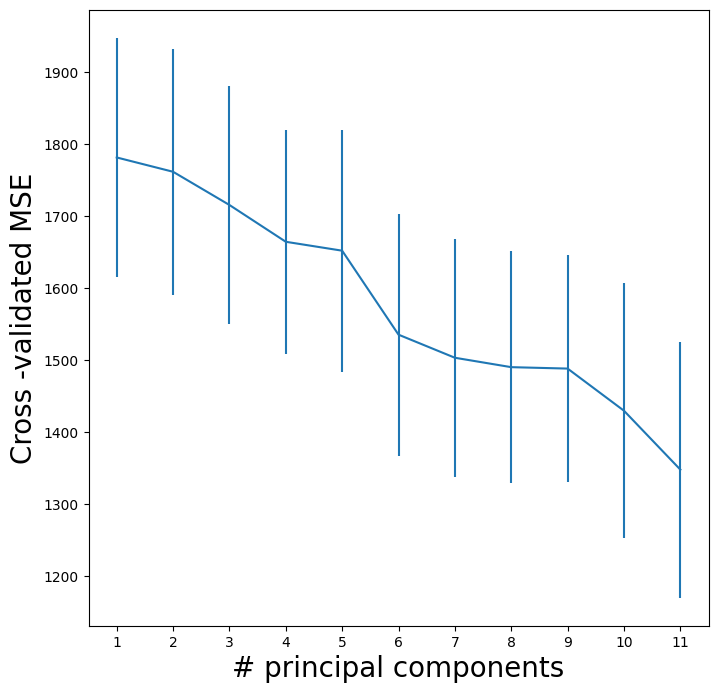

In [84]:
# plot the cross-validated MSE vs principal components
pcr_fig , ax = subplots(figsize=(8,8))
n_comp = param_grid['pca__n_components']
ax.errorbar(n_comp , -grid.cv_results_['mean_test_score'], grid.cv_results_['std_test_score'] / np.sqrt(K))
ax.set_ylabel('Cross -validated MSE', fontsize=20)
ax.set_xlabel('# principal components', fontsize=20)
ax.set_xticks(n_comp [::1]);

In [85]:
# Get the fitted values
y_pred = PCRmodel.predict(Xpcr)

# Evaluate the model
myf(y, y_pred)


 R-squared: 0.779 
 ME: 0.0 
 MPE: -0.008 
 MAE: 28.242 
 MAPE: 0.069 
 MSE: 1626.772 
 RMSE: 40.333 
 RMSLE: 0.094


##### __Assess residuals of PCRmodel to investigate assumptions__

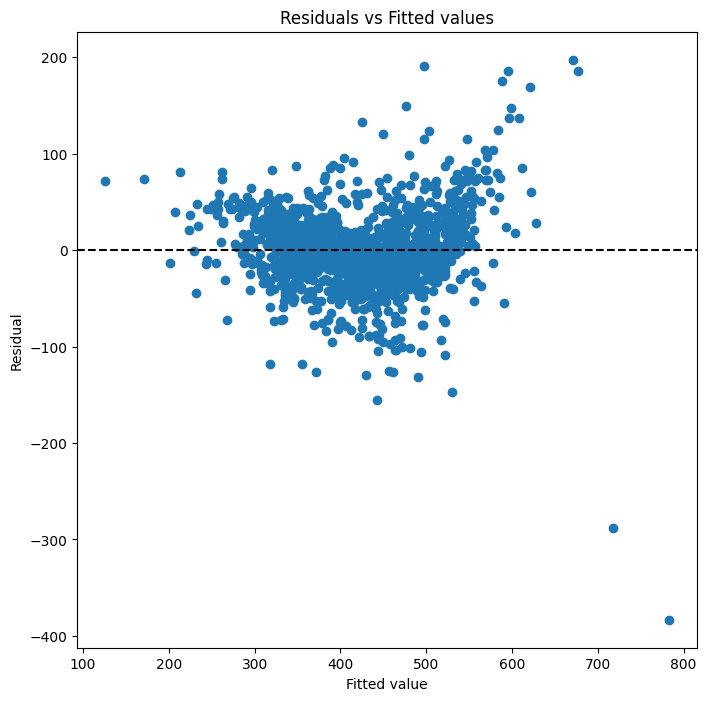

In [86]:
# Get the residuals
residuals = y - y_pred
# scatter plot of residuals vs fitted values to assess homoscedasticity
ax = plt.subplots(figsize=(8,8))[1]
ax.scatter(y_pred , residuals)
ax.set_xlabel('Fitted value')
ax.set_ylabel('Residual')
ax.set_title('Residuals vs Fitted values')
ax.axhline(0, c='k', ls='--');

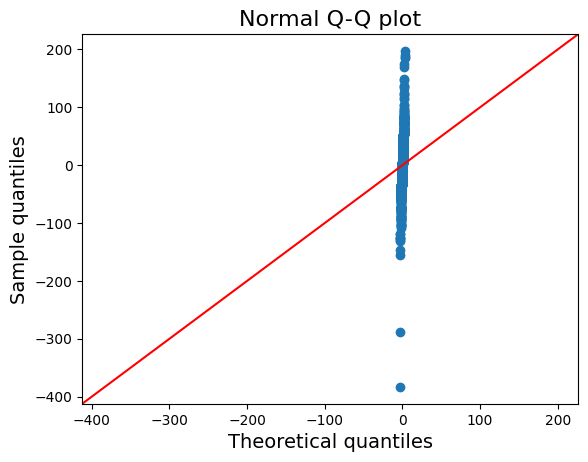

In [87]:
# Normal Q-Q Plot of Residuals to assess normality of residuals
resid = np.ravel(residuals)
p = sm.qqplot(resid, line='45')
plt.title('Normal Q-Q plot', fontsize=16);
plt.xlabel('Theoretical quantiles', fontsize=14);
plt.ylabel('Sample quantiles', fontsize=14);

In [88]:
# calculate VIF to assess multicollinearity
x_pcr = Xpcr[['poly(OverallQual, degree=3)[0]','poly(OverallQual, degree=3)[1]','poly(OverallQual, degree=3)[2]',
             'YearBuilt','1stFlrSF']]
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(x_pcr.values, i) for i in range(x_pcr.shape[1])]
vif["features"] = x_pcr.columns
print(vif)

   VIF Factor                        features
0    1.741654  poly(OverallQual, degree=3)[0]
1    1.038379  poly(OverallQual, degree=3)[1]
2    1.045499  poly(OverallQual, degree=3)[2]
3    1.510978                       YearBuilt
4    1.348913                        1stFlrSF


#### __Generate predictions on the test data__
Preprocessing and Feature Engineering on the Test data

In [89]:
# import test data
HousePriceTest = pd.read_csv(r'./house-prices-advanced-regression-techniques/test.csv',index_col=0)
HousePriceTest

MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
Id                                                                      
1461          20       RH         80.0    11622   Pave   NaN      Reg   
1462          20       RL         81.0    14267   Pave   NaN      IR1   
1463          60       RL         74.0    13830   Pave   NaN      IR1   
1464          60       RL         78.0     9978   Pave   NaN      IR1   
1465         120       RL         43.0     5005   Pave   NaN      IR1   
...          ...      ...          ...      ...    ...   ...      ...   
2915         160       RM         21.0     1936   Pave   NaN      Reg   
2916         160       RM         21.0     1894   Pave   NaN      Reg   
2917          20       RL        160.0    20000   Pave   NaN      Reg   
2918          85       RL         62.0    10441   Pave   NaN      Reg   
2919          60       RL         74.0     9627   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch PoolArea PoolQC  Fence  \
Id                                    ...                                      
1461         Lvl    AllPub    Inside  ...         120        0    NaN  MnPrv   
1462         Lvl    AllPub    Corner  ...           0        0    NaN    NaN   
1463         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
1464         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
1465         HLS    AllPub    Inside  ...         144        0    NaN    NaN   
...          ...       ...       ...  ...         ...      ...    ...    ...   
2915         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2916         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2917         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   
2918         Lvl    AllPub    Inside  ...           0        0    NaN  MnPrv   
2919         Lvl    AllPub    Inside  ...           0        0    NaN    NaN   

     MiscFeature MiscVal  MoSold  YrSold  SaleType  SaleCondition  
Id                                                                 
1461         NaN       0       6    2010        WD         Normal  
1462        Gar2   12500       6    2010        WD         Normal  
1463         NaN       0       3    2010        WD         Normal  
1464         NaN       0       6    2010        WD         Normal  
1465         NaN       0       1    2010        WD         Normal  
...          ...     ...     ...     ...       ...            ...  
2915         NaN       0       6    2006        WD         Normal  
2916         NaN       0       4    2006        WD        Abnorml  
2917         NaN       0       9    2006        WD        Abnorml  
2918        Shed     700       7    2006        WD         Normal  
2919         NaN       0      11    2006        WD         Normal  

[1459 rows x 79 columns]

In [90]:
# select quantitative variables for modeling
HousePriceTestQuant = HousePriceTest[['OverallQual','YearBuilt','1stFlrSF','GrLivArea','GarageCars']]

# Create new square root transformed features
HousePriceTestQuantTrans = np.sqrt(HousePriceTestQuant+1)
HousePriceTestQuantTrans

OverallQual  YearBuilt   1stFlrSF  GrLivArea  GarageCars
Id                                                            
1461     2.449490  44.294469  29.949958  29.949958    1.414214
1462     2.645751  44.260592  36.469165  36.469165    1.414214
1463     2.449490  44.698993  30.479501  40.373258    1.732051
1464     2.645751  44.710178  30.446675  40.062451    1.732051
1465     3.000000  44.643029  35.791060  35.791060    1.732051
...           ...        ...        ...        ...         ...
2915     2.236068  44.395946  23.388031  33.060551    1.000000
2916     2.236068  44.395946  23.388031  33.060551    1.414214
2917     2.449490  44.283180  35.000000  35.000000    1.732051
2918     2.449490  44.643029  31.160873  31.160873    1.000000
2919     2.828427  44.654227  31.575307  44.732538    2.000000

[1459 rows x 5 columns]

In [91]:
# Make a new qualitative variable which combines values of HouseStyle other than 1Story and 2Story
HousePriceTest.loc[HousePriceTest['HouseStyle'] == '1Story', 'HouseStyleNew'] = '1Story'
HousePriceTest.loc[HousePriceTest['HouseStyle'] == '2Story', 'HouseStyleNew'] = '2Story'
HousePriceTest.loc[~HousePriceTest['HouseStyle'].isin(['1Story','2Story']), 'HouseStyleNew'] = 'Other'

# Generate dummy variables for HouseStyleNew
HouseStyleNewTstDummies = HousePriceTest[['HouseStyleNew']]
HouseStyleNewTstDummies = pd.get_dummies(HouseStyleNewTstDummies,columns=['HouseStyleNew'],drop_first=False)
HouseStyleNewTstDummies.drop(['HouseStyleNew_Other'], axis=1, inplace=True)
HouseStyleNewTstDummies

HouseStyleNew_1Story  HouseStyleNew_2Story
Id                                              
1461                     1                     0
1462                     1                     0
1463                     0                     1
1464                     0                     1
1465                     1                     0
...                    ...                   ...
2915                     0                     1
2916                     0                     1
2917                     1                     0
2918                     0                     0
2919                     0                     1

[1459 rows x 2 columns]

In [92]:
# make Xtest for predictions
Xtest = HousePriceTestQuantTrans

# Scale and standardize the quantitative dependent variables
XtestScaled = scaler.fit_transform(Xtest)

# make data frame 
XtestScaled_df = pd.DataFrame(XtestScaled,columns = Xtest.columns, index=Xtest.index)

# add dummy variables to XtestScaled_df
XtestScaled_df['HouseStyleNew_1Story'] = HouseStyleNewTstDummies['HouseStyleNew_1Story']
XtestScaled_df['HouseStyleNew_2Story'] = HouseStyleNewTstDummies['HouseStyleNew_2Story']

# add interaction variables to to XtestScaled_df
XtestScaled_df['interaction1Story'] = XtestScaled_df['OverallQual']*XtestScaled_df['HouseStyleNew_1Story']
XtestScaled_df['interaction2Story'] = XtestScaled_df['OverallQual']*XtestScaled_df['HouseStyleNew_2Story']
XtestScaled_df

OverallQual  YearBuilt  1stFlrSF  GrLivArea  GarageCars  \
Id                                                              
1461    -0.721611  -0.336736 -0.648447  -1.339836   -0.939416   
1462    -0.002936  -0.435553  0.521526  -0.265683   -0.939416   
1463    -0.721611   0.843228 -0.553412   0.377584    0.354724   
1464    -0.002936   0.875852 -0.559303   0.326373    0.354724   
1465     1.294259   0.679983  0.399830  -0.377413    0.354724   
...           ...        ...       ...        ...         ...   
2915    -1.503124  -0.040737 -1.826087  -0.827312   -2.625973   
2916    -1.503124  -0.040737 -1.826087  -0.827312   -0.939416   
2917    -0.721611  -0.369667  0.257862  -0.507754    0.354724   
2918    -0.721611   0.679983 -0.431129  -1.140316   -2.625973   
2919     0.665990   0.712649 -0.356753   1.095851    1.445735   

      HouseStyleNew_1Story  HouseStyleNew_2Story  interaction1Story  \
Id                                                                    
1461                     1                     0          -0.721611   
1462                     1                     0          -0.002936   
1463                     0                     1          -0.000000   
1464                     0                     1          -0.000000   
1465                     1                     0           1.294259   
...                    ...                   ...                ...   
2915                     0                     1          -0.000000   
2916                     0                     1          -0.000000   
2917                     1                     0          -0.721611   
2918                     0                     0          -0.000000   
2919                     0                     1           0.000000   

      interaction2Story  
Id                       
1461          -0.000000  
1462          -0.000000  
1463          -0.721611  
1464          -0.002936  
1465           0.000000  
...                 ...  
2915          -1.503124  
2916          -1.503124  
2917          -0.000000  
2918          -0.000000  
2919           0.665990  

[1459 rows x 9 columns]

Generate predictions on TEST using the polynomial regression model

In [93]:
# Get the predicted values
XtestPoly = MS([poly('OverallQual', degree=3),'YearBuilt','1stFlrSF','GrLivArea','GarageCars',
            'HouseStyleNew_1Story','HouseStyleNew_2Story','interaction1Story','interaction2Story']).fit(XtestScaled_df)

yPred_PolyRegModel = PolyRegModel.predict(XtestPoly.transform(XtestScaled_df))

# use back-transfomration to get predicted rings
OutputPolyRegModel = HousePriceTest
OutputPolyRegModel['SalePrice'] = np.round((np.square(yPred_PolyRegModel) - 1), 0)
OutputPolyRegModel['SalePrice'] = OutputPolyRegModel['SalePrice'].fillna(0) # fill blanks with zero
OutputPolyRegModel['id'] = OutputPolyRegModel.index

# generate output for submission for PolyRegModel
PolyRegModel_Submission = OutputPolyRegModel[['id','SalePrice']]
PolyRegModel_Submission.to_csv(r'./house-prices-advanced-regression-techniques/PolyRegModel_Submission.csv', index = False)
PolyRegModel_Submission

id  SalePrice
Id                   
1461  1461   111457.0
1462  1462   153810.0
1463  1463   164589.0
1464  1464   179756.0
1465  1465   224491.0
...    ...        ...
2915  2915    89668.0
2916  2916   100689.0
2917  2917   144100.0
2918  2918   112138.0
2919  2919   234208.0

[1459 rows x 2 columns]

Generate predictions on TEST using the PCR model

In [94]:
# Get the predicted values
XtestPCR = XtestPoly.transform(XtestScaled_df)
XtestPCR = XtestPCR.drop('intercept', axis=1)
XtestPCR.fillna(0, inplace=True) # feature GarageCars has a missing value not accepted by PCR, so it is replaced with 0

yPred_PCRmodel = PCRmodel.predict(XtestPCR)

# use back-transfomration to get predicted rings
OutputPCRmodel = HousePriceTest
OutputPCRmodel['SalePrice'] = np.round((np.square(yPred_PCRmodel) - 1), 0)
OutputPCRmodel['id'] = OutputPCRmodel.index

# generate output for submission for PCRmodel
PCRmodel_Submission = OutputPCRmodel[['id','SalePrice']]
PCRmodel_Submission.to_csv(r'./house-prices-advanced-regression-techniques/PCRmodel_Submission.csv', index = False)
PCRmodel_Submission

id  SalePrice
Id                   
1461  1461   106088.0
1462  1462   153704.0
1463  1463   195046.0
1464  1464   200006.0
1465  1465   202472.0
...    ...        ...
2915  2915    98397.0
2916  2916   112407.0
2917  2917   148452.0
2918  2918   125995.0
2919  2919   241270.0

[1459 rows x 2 columns]

In [95]:
# clear objects stored in RAM to free-up memory for next steps
del corr_matrix
del grid
del HousePriceTest
del HousePriceTestQuant
del HousePriceTestQuantTrans
del HousePriceTrain
del HousePriceTrainQuant
del HousePriceTrainQuantTrans
del HouseStyleNewDummies
del HouseStyleNewTstDummies
del infl
del kfold
del linreg
del models
del OutputPCRmodel
del OutputPolyRegModel
del pca
del PCRmodel
del PolyRegModel
del resid
del residuals
del vif
del x
del x_pcr
del Xpcr
del Xpoly
del Xs
del Xscaled
del Xscaled_df
del Xtest
del XtestPCR
del XtestPoly
del XtestScaled
del XtestScaled_df
del y_pred
del yPred_PCRmodel
del yPred_PolyRegModel

# Force garbage collection
gc.collect()

188013

### __3. Compete in the San Francisco Crime Classification competition (late submission) on Kaggle.com__
https://www.kaggle.com/competitions/sf-crime

Submit two tree models and one Support Vector Machine. Investigate assumptions. Interpret findings.

#### __EDA and Preprocessing__

In [96]:
# import training data and Convert Dates to datetime 
SFcrimeTrain = pd.read_csv(r'./sf-crime/train.csv', parse_dates=['Dates'])

# Descript and Resolution are only in training data, so drop those columns
SFcrimeTrain = SFcrimeTrain.drop(['Descript','Resolution'], axis=1)
SFcrimeTrain

Dates                Category  DayOfWeek PdDistrict  \
0      2015-05-13 23:53:00                WARRANTS  Wednesday   NORTHERN   
1      2015-05-13 23:53:00          OTHER OFFENSES  Wednesday   NORTHERN   
2      2015-05-13 23:33:00          OTHER OFFENSES  Wednesday   NORTHERN   
3      2015-05-13 23:30:00           LARCENY/THEFT  Wednesday   NORTHERN   
4      2015-05-13 23:30:00           LARCENY/THEFT  Wednesday       PARK   
...                    ...                     ...        ...        ...   
878044 2003-01-06 00:15:00                 ROBBERY     Monday    TARAVAL   
878045 2003-01-06 00:01:00           LARCENY/THEFT     Monday  INGLESIDE   
878046 2003-01-06 00:01:00           LARCENY/THEFT     Monday   SOUTHERN   
878047 2003-01-06 00:01:00               VANDALISM     Monday   SOUTHERN   
878048 2003-01-06 00:01:00  FORGERY/COUNTERFEITING     Monday    BAYVIEW   

                           Address           X          Y  
0               OAK ST / LAGUNA ST -122.425892  37.774599  
1               OAK ST / LAGUNA ST -122.425892  37.774599  
2        VANNESS AV / GREENWICH ST -122.424363  37.800414  
3         1500 Block of LOMBARD ST -122.426995  37.800873  
4        100 Block of BRODERICK ST -122.438738  37.771541  
...                            ...         ...        ...  
878044  FARALLONES ST / CAPITOL AV -122.459033  37.714056  
878045        600 Block of EDNA ST -122.447364  37.731948  
878046          5TH ST / FOLSOM ST -122.403390  37.780266  
878047        TOWNSEND ST / 2ND ST -122.390531  37.780607  
878048    1800 Block of NEWCOMB AV -122.394926  37.738212  

[878049 rows x 7 columns]

In [97]:
# check for missing values
missing_values = SFcrimeTrain.isnull().sum()
print(missing_values)

Dates         0
Category      0
DayOfWeek     0
PdDistrict    0
Address       0
X             0
Y             0
dtype: int64


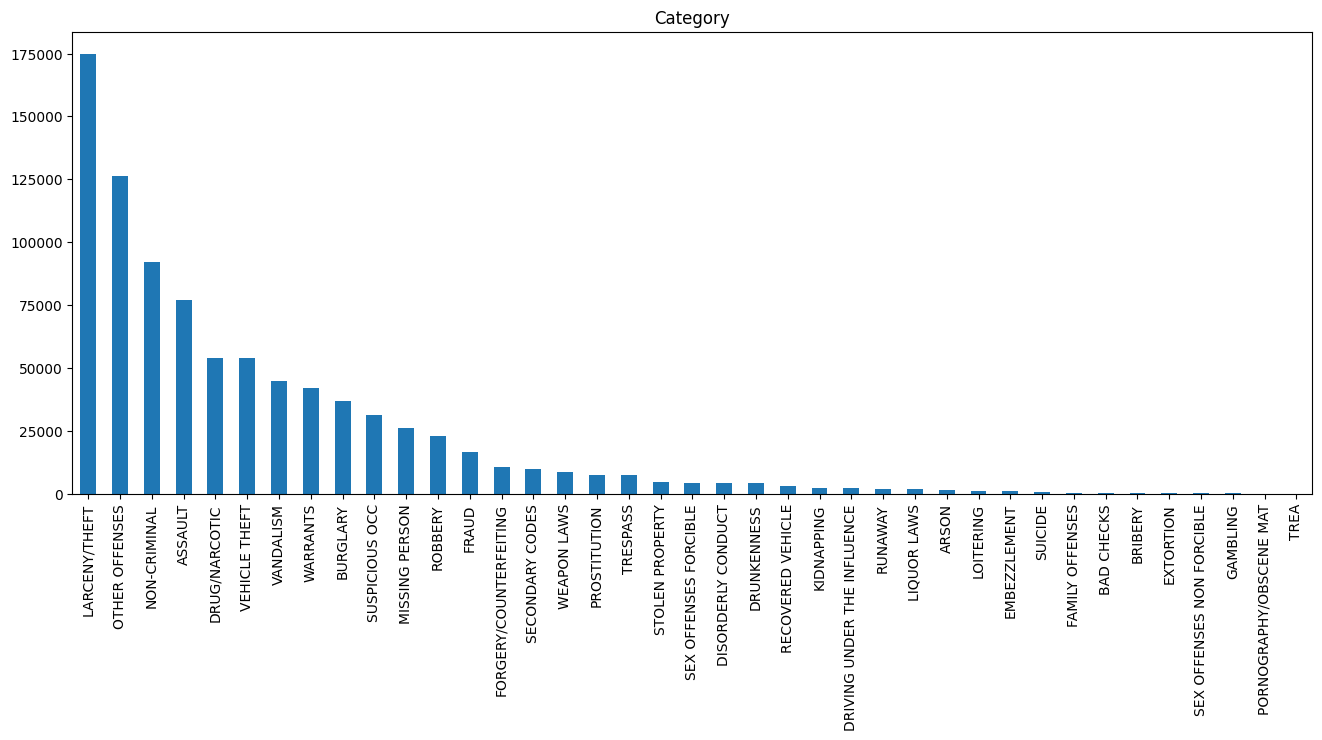

In [98]:
# find distribution of target variable Category
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot() 
SFcrimeTrain['Category'].value_counts().plot(kind='bar')
ax.set_title('Category');

In [99]:
SFcrimeTrain['Category'].value_counts()

LARCENY/THEFT                  174900
OTHER OFFENSES                 126182
NON-CRIMINAL                    92304
ASSAULT                         76876
DRUG/NARCOTIC                   53971
VEHICLE THEFT                   53781
VANDALISM                       44725
WARRANTS                        42214
BURGLARY                        36755
SUSPICIOUS OCC                  31414
MISSING PERSON                  25989
ROBBERY                         23000
FRAUD                           16679
FORGERY/COUNTERFEITING          10609
SECONDARY CODES                  9985
WEAPON LAWS                      8555
PROSTITUTION                     7484
TRESPASS                         7326
STOLEN PROPERTY                  4540
SEX OFFENSES FORCIBLE            4388
DISORDERLY CONDUCT               4320
DRUNKENNESS                      4280
RECOVERED VEHICLE                3138
KIDNAPPING                       2341
DRIVING UNDER THE INFLUENCE      2268
RUNAWAY                          1946
LIQUOR LAWS 

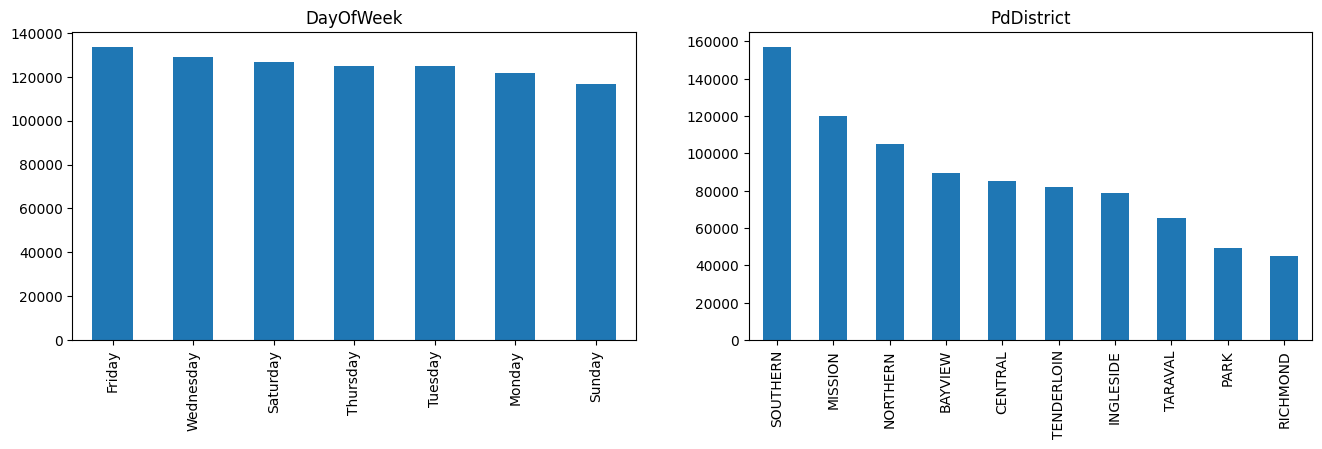

In [100]:
# check distribution of DayOfWeek and PdDistrict
fig1 = plt.figure(figsize=(16,4))

ax1 = fig1.add_subplot(1, 2, 1) # 1 row, 2 columns, 1st subplot
SFcrimeTrain['DayOfWeek'].value_counts().plot(kind='bar')
ax1.set_title('DayOfWeek')

ax2 = fig1.add_subplot(1, 2, 2) # 1 row, 2 columns, 2nd subplot
SFcrimeTrain['PdDistrict'].value_counts().plot(kind='bar')
ax2.set_title('PdDistrict');

In [101]:
SFcrimeTrain['PdDistrict'].value_counts()

SOUTHERN      157182
MISSION       119908
NORTHERN      105296
BAYVIEW        89431
CENTRAL        85460
TENDERLOIN     81809
INGLESIDE      78845
TARAVAL        65596
PARK           49313
RICHMOND       45209
Name: PdDistrict, dtype: int64

#### __Feature Engineering__
1. Numerically code the dependent variable with a category as the referent
2. Extract month, day, year, hour, minute, from Dates
3. Create dummy variables for DayOfWeek and PdDistrict
4. Scale and standardize the quantitative dependent variables

In [102]:
# Code the dependent variable Category as numeric with a category as the referent
Category_mapping = {'ARSON':0,'ASSAULT':1,'BAD CHECKS':2,'BRIBERY':3,'BURGLARY':4,'DISORDERLY CONDUCT':5,
                    'DRIVING UNDER THE INFLUENCE':6,'DRUG/NARCOTIC':7,'DRUNKENNESS':8,'EMBEZZLEMENT':9,
                    'EXTORTION':10,'FAMILY OFFENSES':11,'FORGERY/COUNTERFEITING':12,'FRAUD':13,
                    'GAMBLING':14,'KIDNAPPING':15,'LARCENY/THEFT':16,'LIQUOR LAWS':17,'LOITERING':18,
                    'MISSING PERSON':19,'NON-CRIMINAL':20,'OTHER OFFENSES':21,'PORNOGRAPHY/OBSCENE MAT':22,
                    'PROSTITUTION':23,'RECOVERED VEHICLE':24,'ROBBERY':25,'RUNAWAY':26,'SECONDARY CODES':27,
                    'SEX OFFENSES FORCIBLE':28,'SEX OFFENSES NON FORCIBLE':29,'STOLEN PROPERTY':30,'SUICIDE':31,
                    'SUSPICIOUS OCC':32,'TREA':33,'TRESPASS':34,'VANDALISM':35,'VEHICLE THEFT':36,'WARRANTS':37,'WEAPON LAWS':38
                     }

SFcrimeTrain = SFcrimeTrain.assign(CatNum = SFcrimeTrain.Category.map(Category_mapping))

In [103]:
# extract month, day, year, hour, minute, from Dates
SFcrimeTrain['Day'] = SFcrimeTrain['Dates'].dt.day
SFcrimeTrain['WeekDay'] = SFcrimeTrain['Dates'].dt.dayofweek
SFcrimeTrain['Month'] = SFcrimeTrain['Dates'].dt.month
SFcrimeTrain['Year'] = SFcrimeTrain['Dates'].dt.year
SFcrimeTrain['Hour'] = SFcrimeTrain['Dates'].dt.hour
SFcrimeTrain['Minute'] = SFcrimeTrain['Dates'].dt.minute

SFcrimeTrain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 14 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   Dates       878049 non-null  datetime64[ns]
 1   Category    878049 non-null  object        
 2   DayOfWeek   878049 non-null  object        
 3   PdDistrict  878049 non-null  object        
 4   Address     878049 non-null  object        
 5   X           878049 non-null  float64       
 6   Y           878049 non-null  float64       
 7   CatNum      878049 non-null  int64         
 8   Day         878049 non-null  int64         
 9   WeekDay     878049 non-null  int64         
 10  Month       878049 non-null  int64         
 11  Year        878049 non-null  int64         
 12  Hour        878049 non-null  int64         
 13  Minute      878049 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(7), object(4)
memory usage: 93.8+ MB


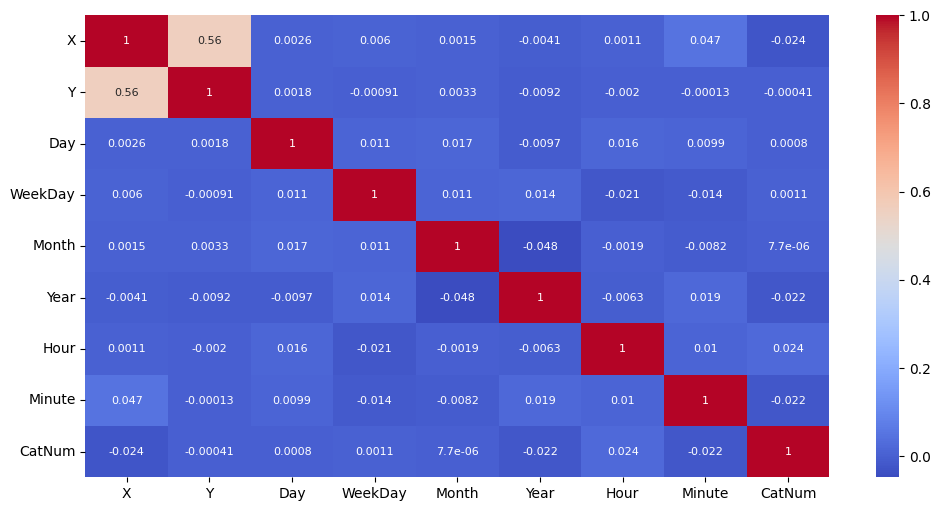

In [104]:
# check correlation and distribution of quantitative features
SFcrimeTrainQuant = SFcrimeTrain[['X','Y','Day','WeekDay','Month','Year','Hour','Minute','CatNum']]
plt.figure(figsize=(12, 6)) 
corr_matrix = SFcrimeTrainQuant.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', annot_kws={'size': 8})
plt.show()

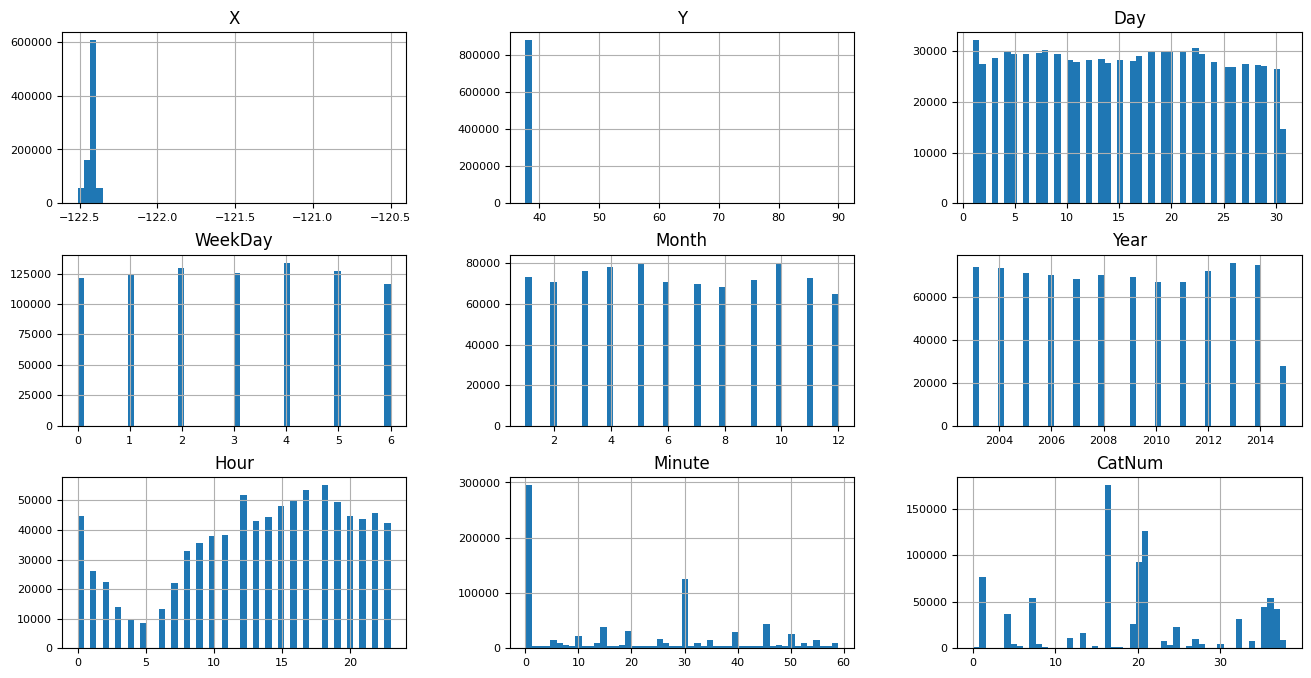

In [105]:
SFcrimeTrainQuant.hist(figsize=(16, 8), bins=50, xlabelsize=8, ylabelsize=8);

In [106]:
# Generate dummy variables 
SFcrimeTrainDummies = SFcrimeTrain[['PdDistrict']]
SFcrimeTrainDummies = pd.get_dummies(SFcrimeTrainDummies,columns=['PdDistrict'], drop_first=True)
SFcrimeTrainDummies

PdDistrict_CENTRAL  PdDistrict_INGLESIDE  PdDistrict_MISSION  \
0                        0                     0                   0   
1                        0                     0                   0   
2                        0                     0                   0   
3                        0                     0                   0   
4                        0                     0                   0   
...                    ...                   ...                 ...   
878044                   0                     0                   0   
878045                   0                     1                   0   
878046                   0                     0                   0   
878047                   0                     0                   0   
878048                   0                     0                   0   

        PdDistrict_NORTHERN  PdDistrict_PARK  PdDistrict_RICHMOND  \
0                         1                0                    0   
1                         1                0                    0   
2                         1                0                    0   
3                         1                0                    0   
4                         0                1                    0   
...                     ...              ...                  ...   
878044                    0                0                    0   
878045                    0                0                    0   
878046                    0                0                    0   
878047                    0                0                    0   
878048                    0                0                    0   

        PdDistrict_SOUTHERN  PdDistrict_TARAVAL  PdDistrict_TENDERLOIN  
0                         0                   0                      0  
1                         0                   0                      0  
2                         0                   0                      0  
3                         0                   0                      0  
4                         0                   0                      0  
...                     ...                 ...                    ...  
878044                    0                   1                      0  
878045                    0                   0                      0  
878046                    1                   0                      0  
878047                    1                   0                      0  
878048                    0                   0                      0  

[878049 rows x 9 columns]

In [107]:
# make X and y for modeling
y = SFcrimeTrainQuant['CatNum']
X = SFcrimeTrainQuant.drop(['CatNum'], axis=1)
X

X          Y  Day  WeekDay  Month  Year  Hour  Minute
0      -122.425892  37.774599   13        2      5  2015    23      53
1      -122.425892  37.774599   13        2      5  2015    23      53
2      -122.424363  37.800414   13        2      5  2015    23      33
3      -122.426995  37.800873   13        2      5  2015    23      30
4      -122.438738  37.771541   13        2      5  2015    23      30
...            ...        ...  ...      ...    ...   ...   ...     ...
878044 -122.459033  37.714056    6        0      1  2003     0      15
878045 -122.447364  37.731948    6        0      1  2003     0       1
878046 -122.403390  37.780266    6        0      1  2003     0       1
878047 -122.390531  37.780607    6        0      1  2003     0       1
878048 -122.394926  37.738212    6        0      1  2003     0       1

[878049 rows x 8 columns]

In [108]:
# Scale and standardize the quantitative dependent variables
scaler = StandardScaler(with_std=True , with_mean=True)
Xscaled = scaler.fit_transform(X)

# make data frame to check variance and mean
XscaledDF = pd.DataFrame(Xscaled,columns = X.columns, index=X.index)
XscaledDF.describe()

X             Y           Day       WeekDay         Month  \
count  8.780490e+05  8.780490e+05  8.780490e+05  8.780490e+05  8.780490e+05   
mean   5.629200e-13 -9.705472e-15 -1.294766e-17 -4.195043e-17  1.274050e-16   
std    1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00  1.000001e+00   
min   -2.998840e+00 -1.381971e-01 -1.658957e+00 -1.517575e+00 -1.585464e+00   
25%   -3.404912e-01 -4.069427e-02 -8.619632e-01 -1.010481e+00 -1.002198e+00   
50%    2.041550e-01  9.631161e-03  4.888728e-02  3.706545e-03 -1.273002e-01   
75%    5.158463e-01  2.921524e-02  8.458815e-01  1.017894e+00  7.475980e-01   
max    6.334063e+01  1.143134e+02  1.756732e+00  1.524988e+00  1.622496e+00   

               Year          Hour        Minute  
count  8.780490e+05  8.780490e+05  8.780490e+05  
mean   1.632027e-14 -1.313864e-16 -6.363777e-17  
std    1.000001e+00  1.000001e+00  1.000001e+00  
min   -1.573050e+00 -2.047868e+00 -1.083900e+00  
25%   -7.468748e-01 -6.737321e-01 -1.083900e+00  
50%    7.930022e-02  8.967695e-02 -6.211516e-02  
75%    9.054753e-01  8.530860e-01  6.907793e-01  
max    1.731650e+00  1.463813e+00  2.089012e+00

In [109]:
# add dummy variables to Xscaled_df
Xscaled_df = XscaledDF.join(SFcrimeTrainDummies)
Xscaled_df

X         Y       Day   WeekDay     Month     Year      Hour  \
0      -0.107902  0.007832 -0.292682 -0.503387 -0.418933  1.73165  1.463813   
1      -0.107902  0.007832 -0.292682 -0.503387 -0.418933  1.73165  1.463813   
2      -0.057541  0.064335 -0.292682 -0.503387 -0.418933  1.73165  1.463813   
3      -0.144262  0.065338 -0.292682 -0.503387 -0.418933  1.73165  1.463813   
4      -0.531112  0.001140 -0.292682 -0.503387 -0.418933  1.73165  1.463813   
...          ...       ...       ...       ...       ...      ...       ...   
878044 -1.199747 -0.124677 -1.089676 -1.517575 -1.585464 -1.57305 -2.047868   
878045 -0.815292 -0.085518 -1.089676 -1.517575 -1.585464 -1.57305 -2.047868   
878046  0.633404  0.020235 -1.089676 -1.517575 -1.585464 -1.57305 -2.047868   
878047  1.057042  0.020983 -1.089676 -1.517575 -1.585464 -1.57305 -2.047868   
878048  0.912272 -0.071808 -1.089676 -1.517575 -1.585464 -1.57305 -2.047868   

          Minute  PdDistrict_CENTRAL  PdDistrict_INGLESIDE  \
0       1.766343                   0                     0   
1       1.766343                   0                     0   
2       0.690779                   0                     0   
3       0.529445                   0                     0   
4       0.529445                   0                     0   
...          ...                 ...                   ...   
878044 -0.277228                   0                     0   
878045 -1.030122                   0                     1   
878046 -1.030122                   0                     0   
878047 -1.030122                   0                     0   
878048 -1.030122                   0                     0   

        PdDistrict_MISSION  PdDistrict_NORTHERN  PdDistrict_PARK  \
0                        0                    1                0   
1                        0                    1                0   
2                        0                    1                0   
3                        0                    1                0   
4                        0                    0                1   
...                    ...                  ...              ...   
878044                   0                    0                0   
878045                   0                    0                0   
878046                   0                    0                0   
878047                   0                    0                0   
878048                   0                    0                0   

        PdDistrict_RICHMOND  PdDistrict_SOUTHERN  PdDistrict_TARAVAL  \
0                         0                    0                   0   
1                         0                    0                   0   
2                         0                    0                   0   
3                         0                    0                   0   
4                         0                    0                   0   
...                     ...                  ...                 ...   
878044                    0                    0                   1   
878045                    0                    0                   0   
878046                    0                    1                   0   
878047                    0                    1                   0   
878048                    0                    0                   0   

        PdDistrict_TENDERLOIN  
0                           0  
1                           0  
2                           0  
3                           0  
4                           0  
...                       ...  
878044                      0  
878045                      0  
878046                      0  
878047                      0  
878048                      0  

[878049 rows x 17 columns]

#### __Import Test data and performing Feature Engineering steps__

In [110]:
# import Testing data and Convert Dates to datetime 
SFcrimeTest = pd.read_csv(r'./sf-crime/test.csv', parse_dates=['Dates'],index_col=0)

# extract month, day, year, hour, minute, from Dates
SFcrimeTest['Day'] = SFcrimeTest['Dates'].dt.day
SFcrimeTest['WeekDay'] = SFcrimeTest['Dates'].dt.dayofweek
SFcrimeTest['Month'] = SFcrimeTest['Dates'].dt.month
SFcrimeTest['Year'] = SFcrimeTest['Dates'].dt.year
SFcrimeTest['Hour'] = SFcrimeTest['Dates'].dt.hour
SFcrimeTest['Minute'] = SFcrimeTest['Dates'].dt.minute

#TestID = SFcrimeTest[['Id']]
SFcrimeTestQuant = SFcrimeTest[['X','Y','Day','WeekDay','Month','Year','Hour','Minute']]

SFcrimeTestDummies = SFcrimeTest[['PdDistrict']]
SFcrimeTestDummies = pd.get_dummies(SFcrimeTestDummies,columns=['PdDistrict'], drop_first=True)
SFcrimeTestDummies

# make X for modeling
Xtest = SFcrimeTestQuant

# Scale and standardize the quantitative dependent variables
scaler = StandardScaler(with_std=True , with_mean=True)
XtestScaled = scaler.fit_transform(Xtest)

# make data frame
XtestScaledDF = pd.DataFrame(XtestScaled,columns = Xtest.columns, index=Xtest.index)

# add dummy variables to Xscaled_df
XtestScaled_df = XtestScaledDF.join(SFcrimeTestDummies)
XtestScaled_df

X         Y       Day   WeekDay     Month      Year      Hour  \
Id                                                                             
0       0.745700 -0.075130 -0.636670  1.530967 -0.379014  1.730764  1.464267   
1       1.005982 -0.080531 -0.636670  1.530967 -0.379014  1.730764  1.464267   
2      -0.106786  0.042772 -0.636670  1.530967 -0.379014  1.730764  1.464267   
3      -0.474449 -0.103262 -0.636670  1.530967 -0.379014  1.730764  1.464267   
4      -0.474449 -0.103262 -0.636670  1.530967 -0.379014  1.730764  1.464267   
...          ...       ...       ...       ...       ...       ...       ...   
884257  0.442465 -0.040198 -1.650781 -0.500419 -1.532728 -1.567889 -2.042421   
884258 -0.085497  0.043739 -1.650781 -0.500419 -1.532728 -1.567889 -2.042421   
884259 -0.733421 -0.122521 -1.650781 -0.500419 -1.532728 -1.567889 -2.042421   
884260  1.139232 -0.065996 -1.650781 -0.500419 -1.532728 -1.567889 -2.042421   
884261 -2.163010 -0.077401 -1.650781 -0.500419 -1.532728 -1.567889 -2.042421   

          Minute  PdDistrict_CENTRAL  PdDistrict_INGLESIDE  \
Id                                                           
0       2.087371                   0                     0   
1       1.657505                   0                     0   
2       1.603771                   0                     0   
3       1.335105                   0                     1   
4       1.335105                   0                     1   
...          ...                 ...                   ...   
884257 -1.029158                   0                     0   
884258 -1.029158                   0                     0   
884259 -1.029158                   0                     1   
884260 -1.029158                   0                     0   
884261 -1.029158                   0                     0   

        PdDistrict_MISSION  PdDistrict_NORTHERN  PdDistrict_PARK  \
Id                                                                 
0                        0                    0                0   
1                        0                    0                0   
2                        0                    1                0   
3                        0                    0                0   
4                        0                    0                0   
...                    ...                  ...              ...   
884257                   1                    0                0   
884258                   0                    1                0   
884259                   0                    0                0   
884260                   0                    0                0   
884261                   0                    0                0   

        PdDistrict_RICHMOND  PdDistrict_SOUTHERN  PdDistrict_TARAVAL  \
Id                                                                     
0                         0                    0                   0   
1                         0                    0                   0   
2                         0                    0                   0   
3                         0                    0                   0   
4                         0                    0                   0   
...                     ...                  ...                 ...   
884257                    0                    0                   0   
884258                    0                    0                   0   
884259                    0                    0                   0   
884260                    0                    0                   0   
884261                    0                    0                   1   

        PdDistrict_TENDERLOIN  
Id                             
0                           0  
1                           0  
2                           0  
3                           0  
4                           0  
...                       ...  
884257                      0  
884258                      0  
884259                   

#### __Tree Model 1: Decision Tree__

In [111]:
%%time
# use gridsearchcv

# Define the model
DT_model = DTC(random_state = 0)

# Define the set of Hyperparameter
param_grid = {
    'max_depth': [3,40],
    'criterion':  ['gini', 'entropy'],
    'class_weight':['balanced','None']
}

# Running the GridSearchCV
grid_search = GridSearchCV(estimator=DT_model, param_grid=param_grid, scoring='accuracy', cv=5, n_jobs=-1)
grid_search.fit(Xscaled_df, y)

print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Hyperparameters: {'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': 40}
Best Score: 0.08924557633272391
CPU times: total: 17.3 s
Wall time: 1min 41s


In [112]:
%%time

# Initialize the model
DT_model = DTC(criterion='gini', max_depth=40, random_state=0, class_weight='balanced')

# evaluate the model and collect the scores
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(DT_model, Xscaled_df, y, scoring='accuracy', cv=cv, n_jobs=-1)

# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)))

# Fit the model
DT_model = DT_model.fit(Xscaled_df, y)
print( DT_model.score(Xscaled_df, y))
y_pred_DT=DT_model.predict(Xscaled_df)
print(cr(y,y_pred_DT))

Mean Accuracy: 0.216 (0.002)
0.8190032674714054
              precision    recall  f1-score   support

           0       0.76      1.00      0.86      1513
           1       0.88      0.69      0.77     76876
           2       0.70      1.00      0.82       406
           3       0.35      0.99      0.52       289
           4       0.82      0.91      0.86     36755
           5       0.50      0.86      0.64      4320
           6       0.59      0.99      0.74      2268
           7       0.71      0.79      0.75     53971
           8       0.46      0.95      0.62      4280
           9       0.73      1.00      0.84      1166
          10       0.49      1.00      0.65       256
          11       0.65      1.00      0.78       491
          12       0.71      0.94      0.81     10609
          13       0.62      0.92      0.74     16679
          14       0.64      1.00      0.78       146
          15       0.39      0.94      0.55      2341
          16       0.99      0.86

The decision tree has `max_depth=40` which is too big to display graphically. 

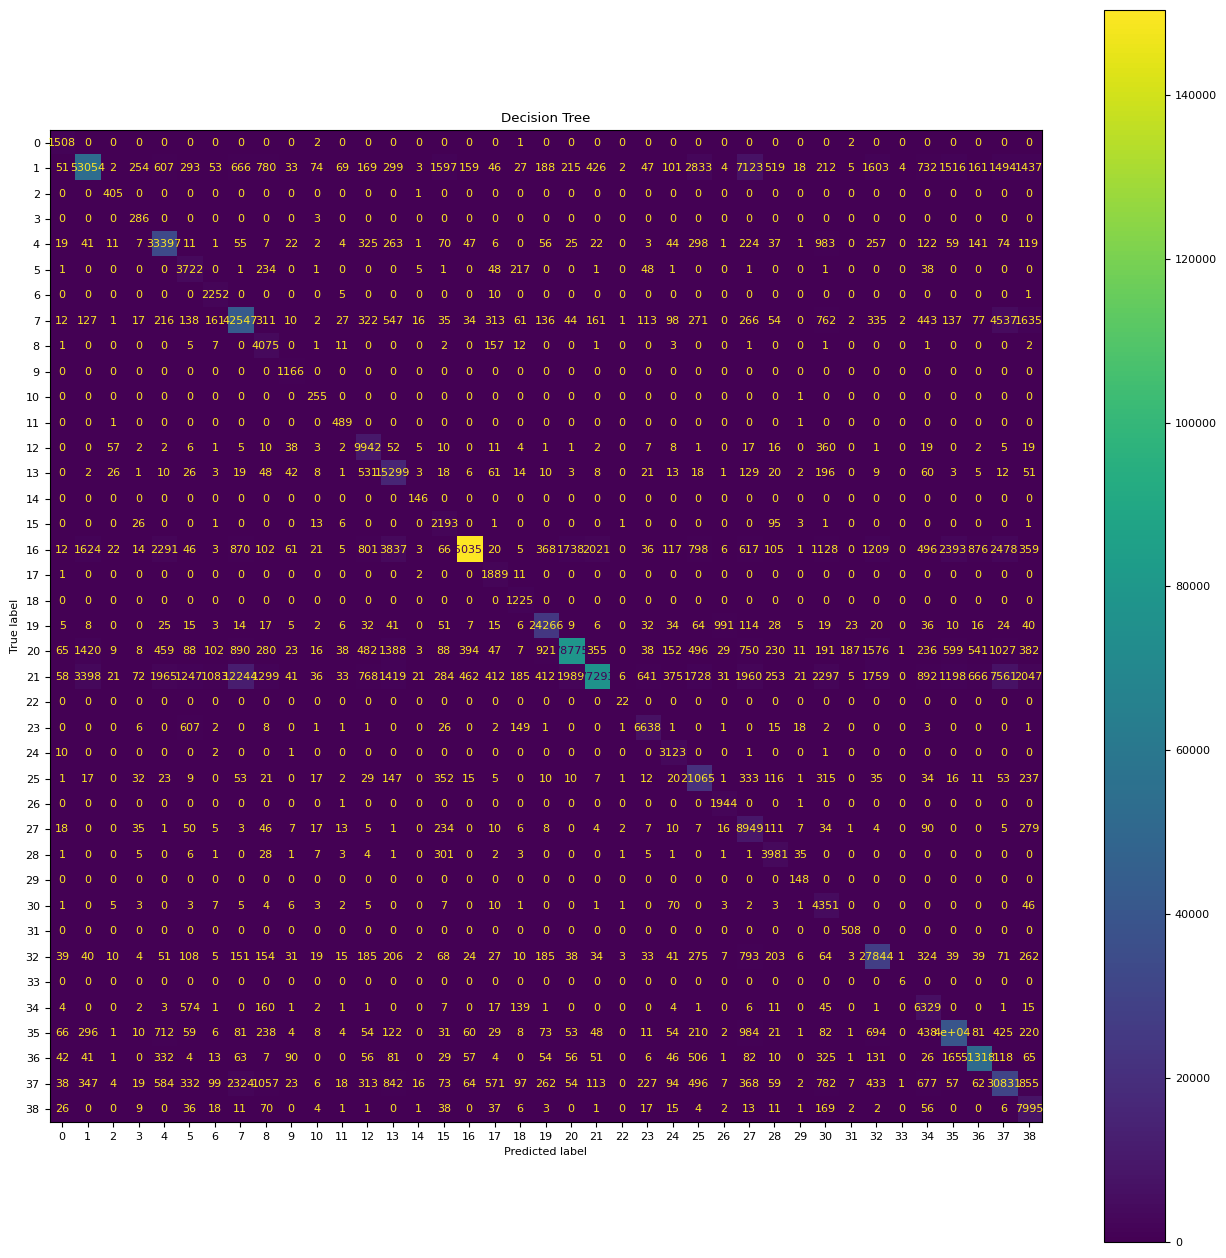

<Figure size 1200x600 with 0 Axes>

In [113]:
# Confusion matrix
cm = confusion_matrix(y, y_pred_DT)

plt.rcParams.update({'font.size': 8, 'figure.figsize': (16,16)})
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_plot.plot()
cm_plot.ax_.set_title('Decision Tree')
plt.figure(figsize=(12, 6))
plt.show();

##### __Use Decision Tree Model to Predict on test__

In [114]:
DT_y_prob = pd.DataFrame(DT_model.predict_proba(XtestScaled_df))
DT_y_prob = DT_y_prob.rename(columns={0: 'ARSON', 1: 'ASSAULT', 2: 'BAD CHECKS', 3: 'BRIBERY', 4: 'BURGLARY', 5: 'DISORDERLY CONDUCT', 
                                      6: 'DRIVING UNDER THE INFLUENCE', 7: 'DRUG/NARCOTIC', 8: 'DRUNKENNESS', 9: 'EMBEZZLEMENT', 
                                      10: 'EXTORTION', 11: 'FAMILY OFFENSES', 12: 'FORGERY/COUNTERFEITING', 13: 'FRAUD', 14: 'GAMBLING', 
                                      15: 'KIDNAPPING', 16: 'LARCENY/THEFT', 17: 'LIQUOR LAWS', 18: 'LOITERING', 19: 'MISSING PERSON', 
                                      20: 'NON-CRIMINAL', 21: 'OTHER OFFENSES', 22: 'PORNOGRAPHY/OBSCENE MAT', 23: 'PROSTITUTION', 
                                      24: 'RECOVERED VEHICLE', 25: 'ROBBERY', 26: 'RUNAWAY', 27: 'SECONDARY CODES', 28: 'SEX OFFENSES FORCIBLE', 
                                      29: 'SEX OFFENSES NON FORCIBLE', 30: 'STOLEN PROPERTY', 31: 'SUICIDE', 32: 'SUSPICIOUS OCC', 33: 'TREA', 
                                      34: 'TRESPASS', 35: 'VANDALISM', 36: 'VEHICLE THEFT', 37: 'WARRANTS', 38: 'WEAPON LAWS'})
DT_y_prob.reset_index(inplace=True)
DT_y_prob.rename(columns={'index':'Id'},inplace=True)
DT_y_prob.to_csv(r'./sf-crime/DTmodel_Submission.csv', index = False)
DT_y_prob

Id  ARSON  ASSAULT  BAD CHECKS  BRIBERY  BURGLARY  \
0            0    0.0      0.0         0.0      0.0       0.0   
1            1    0.0      0.0         0.0      0.0       0.0   
2            2    0.0      0.0         0.0      0.0       0.0   
3            3    0.0      0.0         0.0      0.0       0.0   
4            4    0.0      0.0         0.0      0.0       0.0   
...        ...    ...      ...         ...      ...       ...   
884257  884257    0.0      0.0         0.0      0.0       0.0   
884258  884258    0.0      0.0         0.0      0.0       0.0   
884259  884259    0.0      0.0         0.0      0.0       0.0   
884260  884260    0.0      0.0         0.0      0.0       0.0   
884261  884261    0.0      0.0         0.0      0.0       0.0   

        DISORDERLY CONDUCT  DRIVING UNDER THE INFLUENCE  DRUG/NARCOTIC  \
0                      0.0                          0.0            0.0   
1                      0.0                          0.0            0.0   
2                      0.0                          0.0            0.0   
3                      0.0                          0.0            0.0   
4                      0.0                          0.0            0.0   
...                    ...                          ...            ...   
884257                 0.0                          0.0            0.0   
884258                 0.0                          0.0            0.0   
884259                 0.0                          0.0            0.0   
884260                 0.0                          0.0            0.0   
884261                 0.0                          0.0            0.0   

        DRUNKENNESS  ...  SEX OFFENSES NON FORCIBLE  STOLEN PROPERTY  SUICIDE  \
0               0.0  ...                        0.0              0.0      0.0   
1               0.0  ...                        0.0              0.0      0.0   
2               0.0  ...                        0.0              0.0      0.0   
3               0.0  ...                        0.0              0.0      0.0   
4               0.0  ...                        0.0              0.0      0.0   
...             ...  ...                        ...              ...      ...   
884257          0.0  ...                        0.0              0.0      0.0   
884258          0.0  ...                        0.0              0.0      0.0   
884259          0.0  ...                        0.0              0.0      0.0   
884260          0.0  ...                        0.0              0.0      0.0   
884261          0.0  ...                        0.0              0.0      0.0   

        SUSPICIOUS OCC  TREA  TRESPASS  VANDALISM  VEHICLE THEFT  WARRANTS  \
0                  0.0   0.0       0.0        0.0            0.0  0.000000   
1                  0.0   0.0       0.0        0.0            0.0  0.749317   
2                  0.0   0.0       0.0        0.0            0.0  0.000000   
3                  0.0   0.0       0.0        0.0            0.0  0.000000   
4                  0.0   0.0       0.0        0.0            0.0  0.000000   
...                ...   ...       ...        ...            ...       ...   
884257             0.0   0.0       0.0        0.0            1.0  0.000000   
884258             0.0   0.0       0.0        0.0            0.0  0.000000   
884259             0.0   0.0       0.0        0.0            1.0  0.000000   
884260             0.0   0.0       0.0        0.0            0.0  0.000000   
884261             0.0   0.0       0.0        0.0            0.0  0.000000   

        WEAPON LAWS  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0  
...             ...  
884257          0.0  
884258          0.0  
884259          0.0  
884260          0.0  
884261          0.0  

[884262 rows x 40 columns]

In [115]:
# clear objects stored in RAM to free-up memory for next steps
del DT_model
del param_grid
del grid_search
del cv
del n_scores
del y_pred_DT
del cm
del cm_plot
del DT_y_prob

# Force garbage collection
gc.collect()

91867

#### __Tree Model 2: Bagged Model__

In [116]:
%%time
# Initialize the model - UPDATE PARAMETERS AFTER RUNNING ABOVE GridSearchCV
BAG_model = RandomForestClassifier(max_features=Xscaled_df.shape[1], random_state=0, n_estimators=100)

# Fit the model
BAG_model = BAG_model.fit(Xscaled_df, y)
print( BAG_model.score(Xscaled_df,y))

y_pred_BM=BAG_model.predict(Xscaled_df)
print(cr(y,y_pred_BM, digits=4))

0.8577311744560953
              precision    recall  f1-score   support

           0     0.8844    0.8645    0.8743      1513
           1     0.8046    0.8513    0.8273     76876
           2     0.8740    0.7857    0.8275       406
           3     0.4684    0.3080    0.3716       289
           4     0.9107    0.8843    0.8973     36755
           5     0.6234    0.5343    0.5754      4320
           6     0.7924    0.6446    0.7109      2268
           7     0.7373    0.8185    0.7758     53971
           8     0.5494    0.4792    0.5119      4280
           9     0.9004    0.8062    0.8507      1166
          10     0.7079    0.5586    0.6245       256
          11     0.8114    0.7800    0.7954       491
          12     0.8451    0.8299    0.8374     10609
          13     0.7815    0.6919    0.7340     16679
          14     0.8071    0.7740    0.7902       146
          15     0.5522    0.4272    0.4817      2341
          16     0.9375    0.9605    0.9489    174900
        

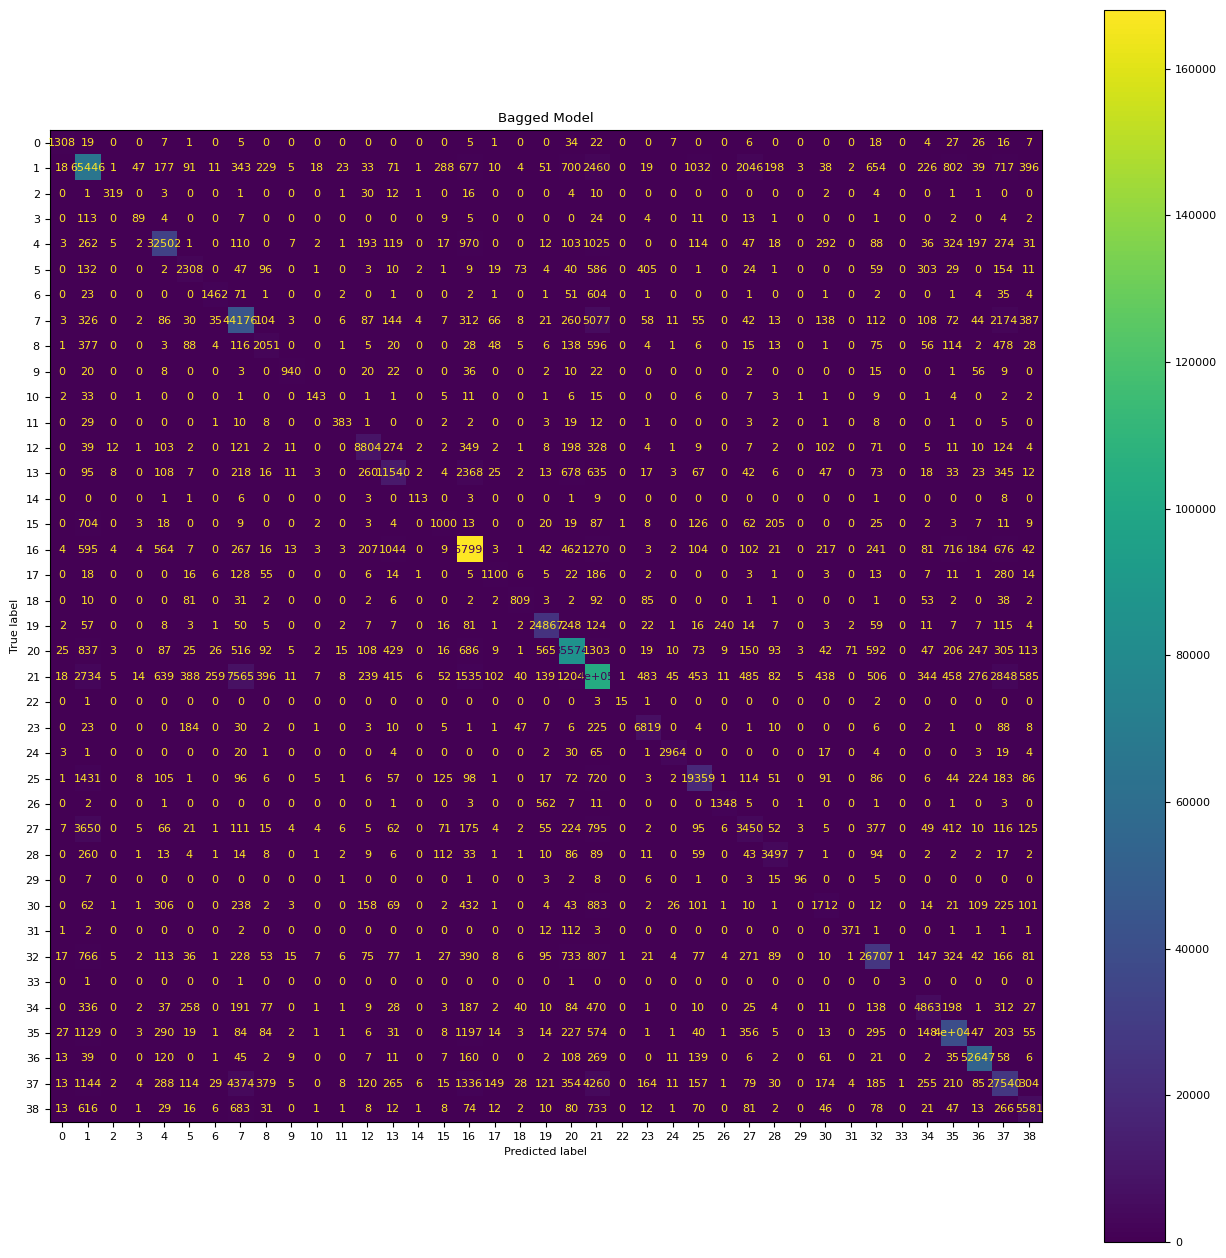

<Figure size 1200x600 with 0 Axes>

In [117]:
# Confusion matrix
cm = confusion_matrix(y, y_pred_BM)

plt.rcParams.update({'font.size': 8, 'figure.figsize': (16,16)})
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_plot.plot()
cm_plot.ax_.set_title('Bagged Model')
plt.figure(figsize=(12, 6))
plt.show();

In [118]:
# Get feature importance
importance = pd.DataFrame(
    data={
        'feature': Xscaled_df.columns,
        'importance': BAG_model.feature_importances_,
    }
).sort_values('importance', ascending=False)

importance

feature  importance
1                       Y    0.160601
0                       X    0.159810
2                     Day    0.152156
4                   Month    0.117757
6                    Hour    0.114193
5                    Year    0.096119
3                 WeekDay    0.094771
7                  Minute    0.089985
16  PdDistrict_TENDERLOIN    0.004353
14    PdDistrict_SOUTHERN    0.001673
11    PdDistrict_NORTHERN    0.001653
10     PdDistrict_MISSION    0.001627
12        PdDistrict_PARK    0.001565
9    PdDistrict_INGLESIDE    0.001339
8      PdDistrict_CENTRAL    0.000873
13    PdDistrict_RICHMOND    0.000860
15     PdDistrict_TARAVAL    0.000665

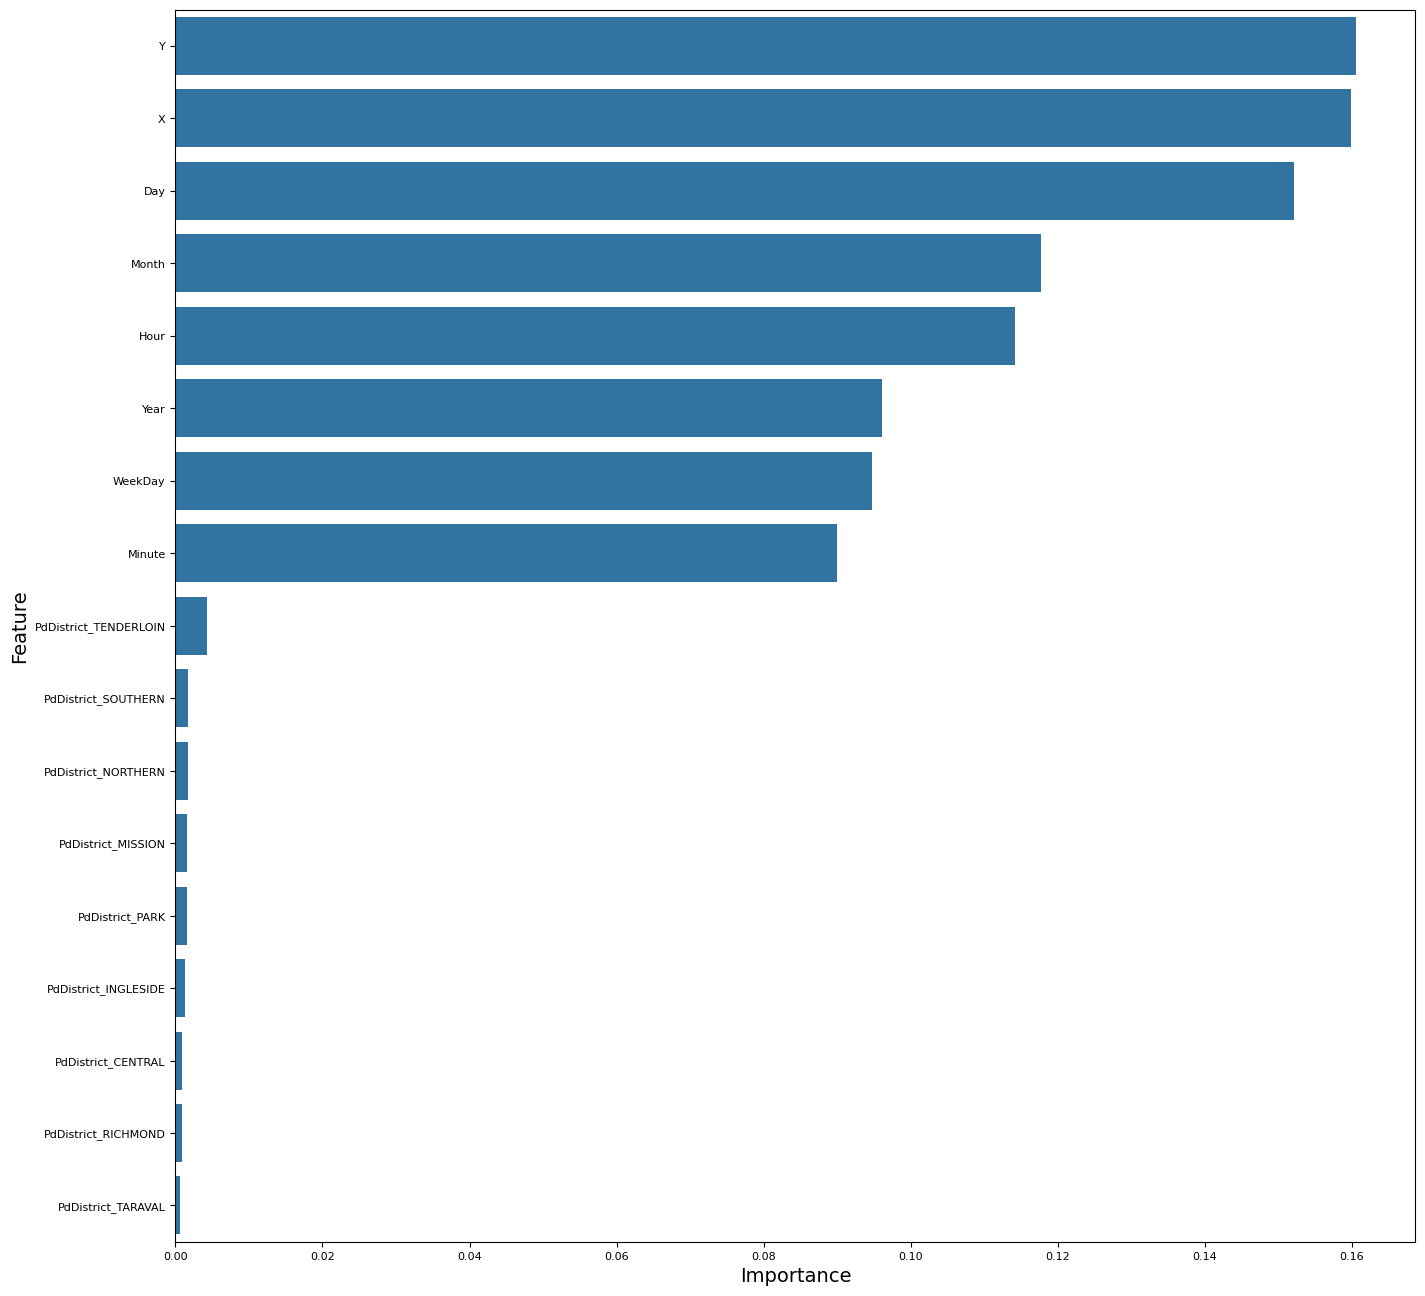

In [119]:
# Plot feature importance
p = sns.barplot(data=importance, y='feature', x='importance')
p.set_xlabel('Importance', fontsize=14)
p.set_ylabel('Feature', fontsize=14)
plt.show();

##### __Use Bagged Model to Predict on test__

In [120]:
%%time
BM_y_prob = pd.DataFrame(BAG_model.predict_proba(XtestScaled_df))
BM_y_prob = BM_y_prob.rename(columns={0: 'ARSON', 1: 'ASSAULT', 2: 'BAD CHECKS', 3: 'BRIBERY', 4: 'BURGLARY', 5: 'DISORDERLY CONDUCT', 
                                      6: 'DRIVING UNDER THE INFLUENCE', 7: 'DRUG/NARCOTIC', 8: 'DRUNKENNESS', 9: 'EMBEZZLEMENT', 
                                      10: 'EXTORTION', 11: 'FAMILY OFFENSES', 12: 'FORGERY/COUNTERFEITING', 13: 'FRAUD', 14: 'GAMBLING', 
                                      15: 'KIDNAPPING', 16: 'LARCENY/THEFT', 17: 'LIQUOR LAWS', 18: 'LOITERING', 19: 'MISSING PERSON', 
                                      20: 'NON-CRIMINAL', 21: 'OTHER OFFENSES', 22: 'PORNOGRAPHY/OBSCENE MAT', 23: 'PROSTITUTION', 
                                      24: 'RECOVERED VEHICLE', 25: 'ROBBERY', 26: 'RUNAWAY', 27: 'SECONDARY CODES', 28: 'SEX OFFENSES FORCIBLE', 
                                      29: 'SEX OFFENSES NON FORCIBLE', 30: 'STOLEN PROPERTY', 31: 'SUICIDE', 32: 'SUSPICIOUS OCC', 33: 'TREA', 
                                      34: 'TRESPASS', 35: 'VANDALISM', 36: 'VEHICLE THEFT', 37: 'WARRANTS', 38: 'WEAPON LAWS'})

BM_y_prob.reset_index(inplace=True)
BM_y_prob.rename(columns={'index':'Id'},inplace=True)
BM_y_prob.to_csv(r'./sf-crime/BAGmodel_Submission.csv', index = False)
BM_y_prob

CPU times: total: 2min 8s
Wall time: 3min 12s


Id  ARSON   ASSAULT  BAD CHECKS   BRIBERY  BURGLARY  \
0            0   0.00  0.052500       0.000  0.000000  0.091538   
1            1   0.00  0.038333       0.000  0.000000  0.040000   
2            2   0.04  0.085000       0.000  0.000000  0.095472   
3            3   0.00  0.072333       0.000  0.005000  0.020000   
4            4   0.00  0.072333       0.000  0.005000  0.020000   
...        ...    ...       ...         ...       ...       ...   
884257  884257   0.00  0.165000       0.000  0.000000  0.000000   
884258  884258   0.00  0.100000       0.010  0.000000  0.110000   
884259  884259   0.00  0.108000       0.005  0.008333  0.010000   
884260  884260   0.01  0.072143       0.000  0.000000  0.030000   
884261  884261   0.00  0.044167       0.000  0.000000  0.080000   

        DISORDERLY CONDUCT  DRIVING UNDER THE INFLUENCE  DRUG/NARCOTIC  \
0                    0.000                          0.0       0.071714   
1                    0.002                          0.0       0.074073   
2                    0.000                          0.0       0.008472   
3                    0.000                          0.0       0.015000   
4                    0.000                          0.0       0.015000   
...                    ...                          ...            ...   
884257               0.000                          0.0       0.020000   
884258               0.000                          0.0       0.000000   
884259               0.000                          0.0       0.010000   
884260               0.000                          0.0       0.040000   
884261               0.000                          0.0       0.000000   

        DRUNKENNESS  ...  SEX OFFENSES NON FORCIBLE  STOLEN PROPERTY  SUICIDE  \
0            0.0000  ...                       0.00         0.003333      0.0   
1            0.0100  ...                       0.00         0.000000      0.0   
2            0.0175  ...                       0.00         0.000000      0.0   
3            0.0100  ...                       0.00         0.000000      0.0   
4            0.0100  ...                       0.00         0.000000      0.0   
...             ...  ...                        ...              ...      ...   
884257       0.0000  ...                       0.01         0.000000      0.0   
884258       0.0000  ...                       0.00         0.000000      0.0   
884259       0.0000  ...                       0.01         0.000000      0.0   
884260       0.0000  ...                       0.00         0.010000      0.0   
884261       0.0000  ...                       0.00         0.000000      0.0   

        SUSPICIOUS OCC  TREA  TRESPASS  VANDALISM  VEHICLE THEFT  WARRANTS  \
0             0.060000   0.0  0.010000   0.085000           0.01  0.038571   
1             0.158167   0.0  0.010000   0.000000           0.02  0.054000   
2             0.024167   0.0  0.010000   0.091667           0.01  0.005000   
3             0.026667   0.0  0.000000   0.073333           0.05  0.050000   
4             0.026667   0.0  0.000000   0.073333           0.05  0.050000   
...                ...   ...       ...        ...            ...       ...   
884257        0.020000   0.0  0.082833   0.200000           0.03  0.000000   
884258        0.178000   0.0  0.000000   0.010000           0.00  0.000000   
884259        0.040000   0.0  0.000000   0.050000           0.06  0.043333   
884260        0.012857   0.0  0.002500   0.075500           0.15  0.010000   
884261        0.000000   0.0  0.000000   0.010000           0.04  0.000000   

        WEAPON LAWS  
0          0.105798  
1          0.080982  
2          0.010000  
3          0.006000  
4          0.006000  
...             ...  
884257     0.000000  
884258     0.000000  
884259     0.003333  
884260     0.003333  
884261     0.000000  

[884262 rows x 40 columns]

In [121]:
# clear objects stored in RAM to free-up memory for next steps
del BAG_model
del BM_y_prob
del cm
del cm_plot
del importance
del p

# Force garbage collection
gc.collect()

95218

#### __Model 3: Support Vector Machine (SVM)__

In [122]:
# Drop the dummy variables for the SVM model to reduce the dimensionality
Xscaled_df.drop(['PdDistrict_TENDERLOIN', 'PdDistrict_SOUTHERN','PdDistrict_NORTHERN','PdDistrict_MISSION','PdDistrict_PARK',
                'PdDistrict_INGLESIDE','PdDistrict_CENTRAL','PdDistrict_RICHMOND','PdDistrict_TARAVAL'], axis=1, inplace=True)
Xscaled_df

X         Y       Day   WeekDay     Month     Year      Hour  \
0      -0.107902  0.007832 -0.292682 -0.503387 -0.418933  1.73165  1.463813   
1      -0.107902  0.007832 -0.292682 -0.503387 -0.418933  1.73165  1.463813   
2      -0.057541  0.064335 -0.292682 -0.503387 -0.418933  1.73165  1.463813   
3      -0.144262  0.065338 -0.292682 -0.503387 -0.418933  1.73165  1.463813   
4      -0.531112  0.001140 -0.292682 -0.503387 -0.418933  1.73165  1.463813   
...          ...       ...       ...       ...       ...      ...       ...   
878044 -1.199747 -0.124677 -1.089676 -1.517575 -1.585464 -1.57305 -2.047868   
878045 -0.815292 -0.085518 -1.089676 -1.517575 -1.585464 -1.57305 -2.047868   
878046  0.633404  0.020235 -1.089676 -1.517575 -1.585464 -1.57305 -2.047868   
878047  1.057042  0.020983 -1.089676 -1.517575 -1.585464 -1.57305 -2.047868   
878048  0.912272 -0.071808 -1.089676 -1.517575 -1.585464 -1.57305 -2.047868   

          Minute  
0       1.766343  
1       1.766343  
2       0.690779  
3       0.529445  
4       0.529445  
...          ...  
878044 -0.277228  
878045 -1.030122  
878046 -1.030122  
878047 -1.030122  
878048 -1.030122  

[878049 rows x 8 columns]

In [123]:
%%time
# use C=1 on 20% of the data since SVM is slow to train on full training set
(X_train , X_val , y_train, y_val) = skm.train_test_split(Xscaled_df, y, test_size=0.2, random_state=0)

SVMlinear = svm.SVC(kernel='linear', probability=True, random_state=0, C=1, class_weight='balanced')

SVM1=SVMlinear.fit(X_val, y_val)
print( SVM1.score(X_val, y_val))
SVMlinearPred=SVM1.predict(X_val)
print(cr(y_val,SVMlinearPred))

0.05267353795341951
              precision    recall  f1-score   support

           0       0.00      0.02      0.01       306
           1       0.11      0.00      0.00     15354
           2       0.00      0.32      0.00        82
           3       0.00      0.17      0.00        48
           4       0.04      0.00      0.00      7344
           5       0.02      0.22      0.03       799
           6       0.01      0.24      0.01       478
           7       0.13      0.10      0.11     10996
           8       0.01      0.03      0.01       842
           9       0.01      0.21      0.01       230
          10       0.00      0.10      0.00        52
          11       0.00      0.07      0.00        98
          12       0.01      0.00      0.00      2127
          13       0.02      0.01      0.02      3283
          14       0.00      0.09      0.00        35
          15       0.00      0.00      0.00       466
          16       0.31      0.14      0.20     34711
       

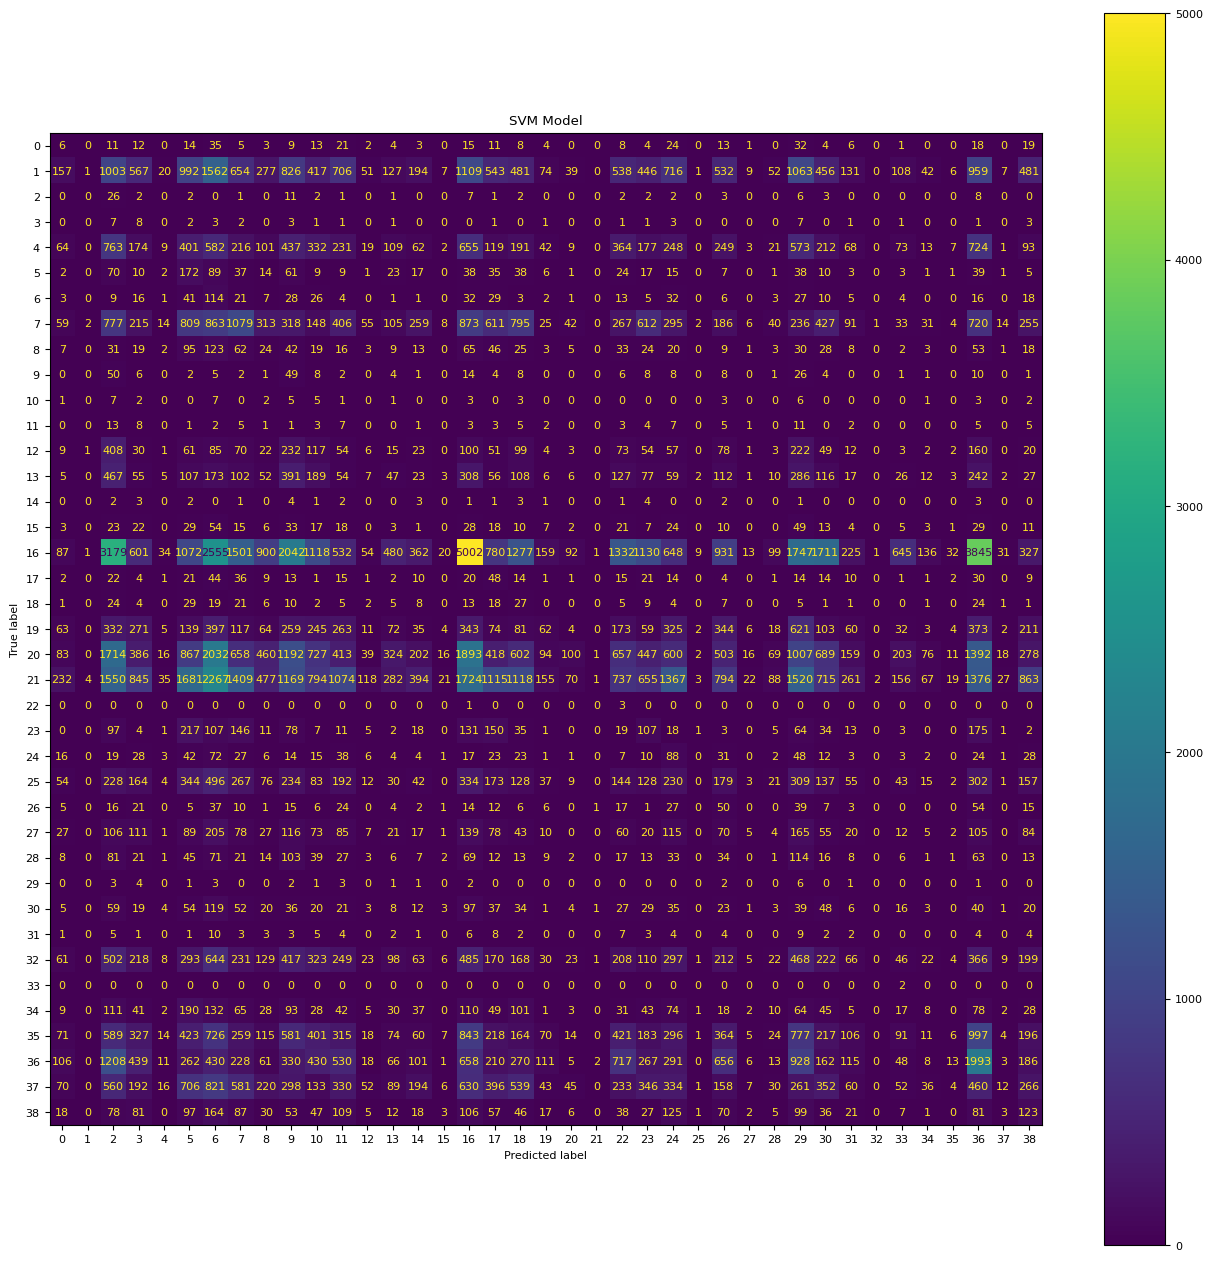

<Figure size 1200x600 with 0 Axes>

In [124]:
# Confusion matrix
cm = confusion_matrix(y_val, SVMlinearPred)

plt.rcParams.update({'font.size': 8, 'figure.figsize': (16,16)})
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm)
cm_plot.plot()
cm_plot.ax_.set_title('SVM Model')
plt.figure(figsize=(12, 6))
plt.show();

##### __Use SVM Model to Predict on test__

In [125]:
# Drop the dummy variables for the SVM model on Test to reduce the dimensionality
XtestScaled_df.drop(['PdDistrict_TENDERLOIN', 'PdDistrict_SOUTHERN','PdDistrict_NORTHERN','PdDistrict_MISSION','PdDistrict_PARK',
                     'PdDistrict_INGLESIDE','PdDistrict_CENTRAL','PdDistrict_RICHMOND','PdDistrict_TARAVAL'], axis=1, inplace=True)
XtestScaled_df

X         Y       Day   WeekDay     Month      Year      Hour  \
Id                                                                             
0       0.745700 -0.075130 -0.636670  1.530967 -0.379014  1.730764  1.464267   
1       1.005982 -0.080531 -0.636670  1.530967 -0.379014  1.730764  1.464267   
2      -0.106786  0.042772 -0.636670  1.530967 -0.379014  1.730764  1.464267   
3      -0.474449 -0.103262 -0.636670  1.530967 -0.379014  1.730764  1.464267   
4      -0.474449 -0.103262 -0.636670  1.530967 -0.379014  1.730764  1.464267   
...          ...       ...       ...       ...       ...       ...       ...   
884257  0.442465 -0.040198 -1.650781 -0.500419 -1.532728 -1.567889 -2.042421   
884258 -0.085497  0.043739 -1.650781 -0.500419 -1.532728 -1.567889 -2.042421   
884259 -0.733421 -0.122521 -1.650781 -0.500419 -1.532728 -1.567889 -2.042421   
884260  1.139232 -0.065996 -1.650781 -0.500419 -1.532728 -1.567889 -2.042421   
884261 -2.163010 -0.077401 -1.650781 -0.500419 -1.532728 -1.567889 -2.042421   

          Minute  
Id                
0       2.087371  
1       1.657505  
2       1.603771  
3       1.335105  
4       1.335105  
...          ...  
884257 -1.029158  
884258 -1.029158  
884259 -1.029158  
884260 -1.029158  
884261 -1.029158  

[884262 rows x 8 columns]

In [126]:
%%time
SVM_y_prob = pd.DataFrame(SVMlinear.predict_proba(XtestScaled_df))
SVM_y_prob = SVM_y_prob.rename(columns={0: 'ARSON', 1: 'ASSAULT', 2: 'BAD CHECKS', 3: 'BRIBERY', 4: 'BURGLARY', 5: 'DISORDERLY CONDUCT', 
                                      6: 'DRIVING UNDER THE INFLUENCE', 7: 'DRUG/NARCOTIC', 8: 'DRUNKENNESS', 9: 'EMBEZZLEMENT', 
                                      10: 'EXTORTION', 11: 'FAMILY OFFENSES', 12: 'FORGERY/COUNTERFEITING', 13: 'FRAUD', 14: 'GAMBLING', 
                                      15: 'KIDNAPPING', 16: 'LARCENY/THEFT', 17: 'LIQUOR LAWS', 18: 'LOITERING', 19: 'MISSING PERSON', 
                                      20: 'NON-CRIMINAL', 21: 'OTHER OFFENSES', 22: 'PORNOGRAPHY/OBSCENE MAT', 23: 'PROSTITUTION', 
                                      24: 'RECOVERED VEHICLE', 25: 'ROBBERY', 26: 'RUNAWAY', 27: 'SECONDARY CODES', 28: 'SEX OFFENSES FORCIBLE', 
                                      29: 'SEX OFFENSES NON FORCIBLE', 30: 'STOLEN PROPERTY', 31: 'SUICIDE', 32: 'SUSPICIOUS OCC', 33: 'TREA', 
                                      34: 'TRESPASS', 35: 'VANDALISM', 36: 'VEHICLE THEFT', 37: 'WARRANTS', 38: 'WEAPON LAWS'})

SVM_y_prob.reset_index(inplace=True)
SVM_y_prob.rename(columns={'index':'Id'},inplace=True)
SVM_y_prob.to_csv(r'./sf-crime/SVMmodel_Submission.csv', index = False)
SVM_y_prob

CPU times: total: 10h 58min 28s
Wall time: 1h 29min 57s


Id     ARSON   ASSAULT  BAD CHECKS   BRIBERY  BURGLARY  \
0            0  0.003637  0.100547    0.000109  0.000328  0.033655   
1            1  0.003679  0.099197    0.000111  0.000421  0.032624   
2            2  0.001241  0.084043    0.000091  0.000121  0.031325   
3            3  0.003341  0.095407    0.000112  0.000575  0.035180   
4            4  0.003341  0.095407    0.000112  0.000575  0.035180   
...        ...       ...       ...         ...       ...       ...   
884257  884257  0.002816  0.097614    0.001525  0.000347  0.054071   
884258  884258  0.001011  0.088109    0.001435  0.000107  0.049630   
884259  884259  0.003634  0.096436    0.001136  0.000489  0.051667   
884260  884260  0.003391  0.099969    0.001562  0.000511  0.050888   
884261  884261  0.002980  0.092998    0.001171  0.000349  0.054209   

        DISORDERLY CONDUCT  DRIVING UNDER THE INFLUENCE  DRUG/NARCOTIC  \
0                 0.002552                     0.006957       0.088463   
1                 0.002278                     0.007037       0.085320   
2                 0.002923                     0.006140       0.093526   
3                 0.002164                     0.007515       0.058548   
4                 0.002164                     0.007515       0.058548   
...                    ...                          ...            ...   
884257            0.009185                     0.001062       0.036296   
884258            0.008084                     0.000987       0.043274   
884259            0.004819                     0.001452       0.027842   
884260            0.008841                     0.001088       0.039112   
884261            0.005601                     0.002001       0.024256   

        DRUNKENNESS  ...  SEX OFFENSES NON FORCIBLE  STOLEN PROPERTY  \
0          0.008169  ...                   0.000068         0.007228   
1          0.007656  ...                   0.000078         0.007065   
2          0.007657  ...                   0.000041         0.007175   
3          0.006395  ...                   0.000096         0.006226   
4          0.006395  ...                   0.000096         0.006226   
...             ...  ...                        ...              ...   
884257     0.002965  ...                   0.000573         0.003148   
884258     0.003553  ...                   0.000363         0.003529   
884259     0.002746  ...                   0.000636         0.003053   
884260     0.003036  ...                   0.000626         0.003223   
884261     0.003210  ...                   0.000503         0.003048   

         SUICIDE  SUSPICIOUS OCC      TREA  TRESPASS  VANDALISM  \
0       0.000662        0.036872  0.000015  0.008081   0.045658   
1       0.000640        0.036313  0.000031  0.007431   0.047379   
2       0.000553        0.032511  0.000006  0.008566   0.042120   
3       0.000933        0.039799  0.000006  0.006353   0.052860   
4       0.000933        0.039799  0.000006  0.006353   0.052860   
...          ...             ...       ...       ...        ...   
884257  0.000286        0.045113  0.000004  0.011037   0.056904   
884258  0.000275        0.038652  0.000004  0.009714   0.050050   
884259  0.000492        0.043296  0.000005  0.006634   0.065239   
884260  0.000292        0.041511  0.000005  0.011305   0.056806   
884261  0.000569        0.044045  0.000005  0.005258   0.064456   

        VEHICLE THEFT  WARRANTS  WEAPON LAWS  
0            0.028387  0.070024     0.023658  
1            0.030035  0.068231     0.023932  
2            0.027147  0.065440     0.011373  
3            0.030382  0.055013     0.023118  
4            0.030382  0.055013     0.023118  
...               ...       ...          ...  
884257       0.086866  0.036194     0.007102  
884258       0.086886  0.040861     0.004299  
884259       0.098374  0.032023     0.010512  
884260       0.081563  0.037513     0.009851  
884261       0.103269  0.027468     0.007116  

[884262 rows x 40 columns]

In [127]:
# Print Python version
import sys
print(sys.version)

# Print Jupyter notebook version
import notebook
notebook.__version__

3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]


'7.2.2'

In [128]:
!jupyter --version

Selected Jupyter core packages...
IPython          : 8.29.0
ipykernel        : 6.29.5
ipywidgets       : not installed
jupyter_client   : 8.6.3
jupyter_core     : 5.7.2
jupyter_server   : 2.14.2
jupyterlab       : 4.2.6
nbclient         : 0.10.0
nbconvert        : 7.16.4
nbformat         : 5.10.4
notebook         : 7.2.2
qtconsole        : not installed
traitlets        : 5.14.3
